In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip -q install numpy scipy scikit-learn tqdm matplotlib torch

import os, time, math, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy import signal

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix
)


In [ ]:
@dataclass
class CFG:
    # ---- PATH (YOUR DRIVE FOLDER) ----
    data_root: str = "/content/drive/MyDrive/Ninapro"

    # ---- SUBJECTS ----
    n_subjects: int = 20
    exercise: int = 1

    # ---- ORIGINAL EMG ----
    fs: int = 2000   # original sampling (Hz)

    # ---- DOWNSAMPLE ----
    downsample_to: int = 200   # 2000 Hz -> 200 Hz

    # ---- WINDOWING (at 200 Hz) ----
    win_ms: int = 400          # 400 ms = 80 samples
    hop_ms: int = 100          # 100 ms = 20 samples
    min_label_fraction: float = 0.9
    drop_rest: bool = True

    # ---- PREPROCESS ----
    detrend: bool = True
    use_notch: bool = True
    notch_freq: float = 50.0   # set 60.0 if needed
    notch_q: float = 30.0

    use_bandpass: bool = True
    bp_low: float = 20.0
    bp_high: float = 95.0      # safe for fs=200 (Nyquist=100)

    rectify: bool = False
    envelope_rms: bool = False

    standardize_per_channel: bool = True

    # ---- TRAIN ----
    device: str = "cuda"
    seed: int = 42
    num_workers: int = 2

    epochs: int = 10
    batch_size: int = 256
    lr: float = 1e-3

    # ---- TSMAE ----
    tsmae_pretrain_epochs: int = 10
    tsmae_pretrain_lr: float = 2e-4
    patch_len: int = 10        # 80 samples -> 8 patches
    mask_ratio: float = 0.6
    d_model: int = 128
    n_heads: int = 4
    n_layers: int = 4
    dropout: float = 0.1


cfg = CFG()
subjects = [f"S{i}" for i in range(1, cfg.n_subjects+1)]

if cfg.device == "cuda" and not torch.cuda.is_available():
    cfg.device = "cpu"
device = torch.device(cfg.device)

print("Device:", device)
print("Subjects:", subjects)
print("Data root:", cfg.data_root)
print("Exists?", os.path.exists(cfg.data_root))


Device: cuda
Subjects: ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20']
Data root: /content/drive/MyDrive/Ninapro
Exists? True


In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(cfg.seed)


In [ ]:
def find_mat_files(subject: str, exercise: int):
    # matches: S1_E1_A1.mat, S1_E1_A2.mat, ...
    pattern = os.path.join(cfg.data_root, f"{subject}_E{exercise}_A*.mat")
    return sorted(glob(pattern))

def load_db2_mat(fp: str):
    m = loadmat(fp)
    if "emg" not in m or "restimulus" not in m:
        raise KeyError(f"Missing keys in {fp}. Found keys: {list(m.keys())[:30]}")
    emg = m["emg"].astype(np.float32)                  # (T,C)
    lab = m["restimulus"].astype(np.int64).reshape(-1) # (T,)
    return emg, lab

def subject_ex1_continuous(subject: str):
    files = find_mat_files(subject, cfg.exercise)
    if len(files) == 0:
        raise FileNotFoundError(
            f"No files found for {subject}. Expected {subject}_E{cfg.exercise}_A*.mat in {cfg.data_root}"
        )
    emg_list, lab_list = [], []
    for fp in files:
        emg, lab = load_db2_mat(fp)
        emg_list.append(emg)
        lab_list.append(lab)
    return np.concatenate(emg_list, axis=0), np.concatenate(lab_list, axis=0)


In [ ]:
files = find_mat_files("S1", cfg.exercise)
print("Matched files for S1:", len(files))
print("Example:", files[:5])

# test load one file
if len(files) > 0:
    emg, lab = load_db2_mat(files[0])
    print("Loaded one file:", files[0])
    print("EMG shape:", emg.shape, "| Labels shape:", lab.shape, "| Unique labels:", len(np.unique(lab)))


Matched files for S1: 1
Example: ['/content/drive/MyDrive/Ninapro/S1_E1_A1.mat']
Loaded one file: /content/drive/MyDrive/Ninapro/S1_E1_A1.mat
EMG shape: (1808331, 12) | Labels shape: (1808331,) | Unique labels: 18


In [ ]:
def apply_notch(x, fs, f0=50.0, Q=30.0):
    b, a = signal.iirnotch(w0=f0, Q=Q, fs=fs)
    return signal.filtfilt(b, a, x, axis=0)

def apply_bandpass(x, fs, low=20.0, high=95.0, order=4):
    b, a = signal.butter(order, [low, high], btype="bandpass", fs=fs)
    return signal.filtfilt(b, a, x, axis=0)

def apply_detrend(x):
    return signal.detrend(x, axis=0, type="linear")

def apply_rectify(x):
    return np.abs(x)

def apply_rms_envelope(x, fs, win_ms=50):
    win = int(fs * win_ms / 1000)
    win = max(win, 2)
    kernel = np.ones(win) / win
    env = np.sqrt(np.apply_along_axis(lambda c: np.convolve(c*c, kernel, mode="same"), 0, x))
    return env.astype(np.float32)

def downsample_resample_poly(x, fs, target_fs):
    if target_fs is None or target_fs == fs:
        return x, fs
    g = math.gcd(fs, target_fs)
    up = target_fs // g
    down = fs // g
    y = signal.resample_poly(x, up=up, down=down, axis=0).astype(np.float32)
    return y, target_fs

def preprocess_emg(emg, fs):
    x = emg.astype(np.float32)

    if cfg.detrend:
        x = apply_detrend(x)

    if cfg.use_notch:
        x = apply_notch(x, fs, cfg.notch_freq, cfg.notch_q)

    # make high cutoff safe for target fs
    fs_target = cfg.downsample_to if cfg.downsample_to is not None else fs
    nyq_target = fs_target / 2.0
    safe_high = min(cfg.bp_high, nyq_target * 0.95)

    if cfg.use_bandpass:
        x = apply_bandpass(x, fs, cfg.bp_low, safe_high)

    if cfg.rectify:
        x = apply_rectify(x)

    if cfg.envelope_rms:
        x = apply_rms_envelope(x, fs, win_ms=50)

    x, fs2 = downsample_resample_poly(x, fs, cfg.downsample_to)
    return x, fs2


In [ ]:
def windowize(emg, lab, fs, win_ms, hop_ms, min_label_fraction=0.9, drop_rest=True):
    win_len = int(fs * win_ms / 1000)
    hop_len = int(fs * hop_ms / 1000)

    T, C = emg.shape
    X, y = [], []

    for start in range(0, T - win_len + 1, hop_len):
        end = start + win_len
        wlab = lab[start:end]

        vals, counts = np.unique(wlab, return_counts=True)
        dom = vals[np.argmax(counts)]
        frac = counts.max() / win_len

        if frac < min_label_fraction:
            continue
        if drop_rest and int(dom) == 0:
            continue

        X.append(emg[start:end])
        y.append(int(dom))

    if len(X) == 0:
        return np.zeros((0, win_len, C), np.float32), np.zeros((0,), np.int64)

    return np.stack(X).astype(np.float32), np.array(y, dtype=np.int64)


In [ ]:
def standardize_train_apply(X_train, X_test, per_channel=True):
    if not per_channel:
        mu = X_train.mean()
        sd = X_train.std() + 1e-8
        return (X_train - mu)/sd, (X_test - mu)/sd

    C = X_train.shape[-1]
    mu = X_train.reshape(-1, C).mean(axis=0, keepdims=True)
    sd = X_train.reshape(-1, C).std(axis=0, keepdims=True) + 1e-8
    return (X_train - mu)/sd, (X_test - mu)/sd


In [ ]:
def build_subject_windows(subject):
    emg, lab = subject_ex1_continuous(subject)

    emg_p, fs2 = preprocess_emg(emg, cfg.fs)

    # align labels length if resample changed length
    if len(emg_p) != len(lab):
        lab = signal.resample_poly(lab.astype(np.float32), up=len(emg_p), down=len(lab)).round().astype(np.int64)

    X, y = windowize(
        emg_p, lab, fs2,
        cfg.win_ms, cfg.hop_ms,
        cfg.min_label_fraction, cfg.drop_rest
    )
    return X, y, fs2


In [ ]:
from torch.utils.data import Dataset, DataLoader

class WindowDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.from_numpy(X).float()
        self.y = None if y is None else torch.from_numpy(y).long()

    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i):
        if self.y is None: return self.X[i]
        return self.X[i], self.y[i]

# ---- Augmentations (train only) ----
def aug_gaussian_noise(x, sigma=0.02):
    return x + sigma * torch.randn_like(x)

def aug_scaling(x, low=0.9, high=1.1):
    s = torch.empty(x.size(0), 1, 1, device=x.device).uniform_(low, high)
    return x * s

def aug_time_shift(x, max_shift=5):
    B, L, C = x.shape
    shift = torch.randint(-max_shift, max_shift+1, (B,), device=x.device)
    out = torch.empty_like(x)
    for i in range(B):
        out[i] = torch.roll(x[i], shifts=int(shift[i].item()), dims=0)
    return out

def aug_channel_dropout(x, p=0.1):
    B, L, C = x.shape
    mask = (torch.rand(B, 1, C, device=x.device) > p).float()
    return x * mask

def apply_augmentations(x):
    if random.random() < 0.5: x = aug_gaussian_noise(x, 0.02)
    if random.random() < 0.5: x = aug_scaling(x)
    if random.random() < 0.3: x = aug_time_shift(x, 5)
    if random.random() < 0.3: x = aug_channel_dropout(x, 0.1)
    return x


In [ ]:
def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    cm = confusion_matrix(y_true, y_pred)
    return acc, prec, rec, f1, cm

def model_info(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    size_mb = total * 4 / (1024**2)
    return total, trainable, size_mb

def plot_history(hist, title_prefix=""):
    epochs = np.arange(1, len(hist["train_loss"]) + 1)

    plt.figure()
    plt.plot(epochs, hist["train_loss"], label="train_loss")
    plt.plot(epochs, hist["val_loss"], label="val_loss")
    plt.xlabel("epoch"); plt.ylabel("loss")
    plt.title(f"{title_prefix} Loss vs Epochs")
    plt.legend(); plt.show()

    plt.figure()
    plt.plot(epochs, hist["train_acc"], label="train_acc")
    plt.plot(epochs, hist["val_acc"], label="val_acc")
    plt.xlabel("epoch"); plt.ylabel("accuracy")
    plt.title(f"{title_prefix} Accuracy vs Epochs")
    plt.legend(); plt.show()


In [ ]:
def run_train_val(model, train_loader, val_loader, epochs, lr, augment=False):
    model = model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    hist = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}
    epoch_times = []

    for ep in range(1, epochs+1):
        t0 = time.time()

        # train
        model.train()
        tr_losses, tr_preds, tr_true = [], [], []
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            if augment:
                xb = apply_augmentations(xb)

            logits = model(xb)
            loss = F.cross_entropy(logits, yb)

            opt.zero_grad()
            loss.backward()
            opt.step()

            tr_losses.append(loss.item())
            tr_preds.append(logits.argmax(1).detach().cpu().numpy())
            tr_true.append(yb.detach().cpu().numpy())

        tr_preds = np.concatenate(tr_preds); tr_true = np.concatenate(tr_true)
        tr_acc = accuracy_score(tr_true, tr_preds)

        # val
        model.eval()
        va_losses, va_preds, va_true = [], [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = F.cross_entropy(logits, yb)
                va_losses.append(loss.item())
                va_preds.append(logits.argmax(1).cpu().numpy())
                va_true.append(yb.cpu().numpy())

        va_preds = np.concatenate(va_preds); va_true = np.concatenate(va_true)
        va_acc = accuracy_score(va_true, va_preds)

        dt = time.time() - t0
        epoch_times.append(dt)

        hist["train_loss"].append(float(np.mean(tr_losses)))
        hist["val_loss"].append(float(np.mean(va_losses)))
        hist["train_acc"].append(float(tr_acc))
        hist["val_acc"].append(float(va_acc))

        print(f"Epoch {ep}/{epochs} | time={dt:.2f}s | tr_loss={hist['train_loss'][-1]:.4f} tr_acc={tr_acc:.4f} | va_loss={hist['val_loss'][-1]:.4f} va_acc={va_acc:.4f}")

    return hist, epoch_times

def evaluate_model(model, te_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in te_loader:
            xb = xb.to(device)
            logits = model(xb)
            pred = logits.argmax(1).cpu().numpy()
            y_pred.append(pred)
            y_true.append(yb.numpy())
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    return compute_metrics(y_true, y_pred)


In [ ]:
class CNN1D(nn.Module):
    def __init__(self, n_ch, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(n_ch, 64, 7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, 7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128, 256, 5, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),

            nn.Flatten(),
            nn.Linear(256, n_classes)
        )
    def forward(self, x):
        x = x.transpose(1,2)
        return self.net(x)

class BiLSTM(nn.Module):
    def __init__(self, n_ch, n_classes, hidden=128, layers=2, dropout=0.2):
        super().__init__()
        self.rnn = nn.LSTM(
            input_size=n_ch, hidden_size=hidden,
            num_layers=layers, batch_first=True,
            bidirectional=True, dropout=dropout
        )
        self.fc = nn.Linear(hidden*2, n_classes)
    def forward(self, x):
        out, _ = self.rnn(x)
        feat = out.mean(dim=1)
        return self.fc(feat)

class TransformerClassifier(nn.Module):
    def __init__(self, n_ch, n_classes, d_model=128, n_heads=4, n_layers=4, dropout=0.1):
        super().__init__()
        self.proj = nn.Linear(n_ch, d_model)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads,
            dim_feedforward=4*d_model,
            dropout=dropout, batch_first=True,
            activation="gelu"
        )
        self.enc = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.head = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, n_classes))
    def forward(self, x):
        x = self.proj(x)
        h = self.enc(x)
        feat = h.mean(dim=1)
        return self.head(feat)


In [ ]:
class Patchify(nn.Module):
    def __init__(self, patch_len):
        super().__init__()
        self.patch_len = patch_len
    def forward(self, x):
        B, L, C = x.shape
        P = L // self.patch_len
        x = x[:, :P*self.patch_len, :]
        return x.reshape(B, P, self.patch_len, C).reshape(B, P, self.patch_len*C)

class TSMAE(nn.Module):
    def __init__(self, n_ch, seq_len, patch_len, d_model, n_heads, n_layers, dropout, mask_ratio):
        super().__init__()
        assert seq_len % patch_len == 0
        self.patch_len = patch_len
        self.n_patches = seq_len // patch_len
        self.mask_ratio = mask_ratio

        self.patchify = Patchify(patch_len)
        patch_dim = patch_len * n_ch

        self.enc_embed = nn.Linear(patch_dim, d_model)
        self.pos = nn.Parameter(torch.zeros(1, self.n_patches, d_model))
        nn.init.trunc_normal_(self.pos, std=0.02)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads,
            dim_feedforward=4*d_model,
            dropout=dropout, batch_first=True, activation="gelu"
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)

        self.dec = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 2*d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(2*d_model, patch_dim),
        )

        self.cls = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)
        )

    def set_num_classes(self, k):
        # Correctly reference the output features of the linear layer before GELU
        self.cls[-1] = nn.Linear(self.cls[-4].out_features, k)

    def _mask(self, B, P, device):
        keep = int(P * (1 - self.mask_ratio))
        noise = torch.rand(B, P, device=device)
        idx = torch.argsort(noise, dim=1)
        keep_idx = idx[:, :keep]
        mask = torch.ones(B, P, device=device, dtype=torch.bool)
        mask.scatter_(1, keep_idx, False)
        return keep_idx, mask

    def pretrain_step(self, x):
        patches = self.patchify(x)
        B, P, D = patches.shape
        keep_idx, mask = self._mask(B, P, x.device)

        vis = patches.gather(1, keep_idx.unsqueeze(-1).expand(-1, -1, D))
        tok = self.enc_embed(vis)

        pos = self.pos.expand(B, -1, -1)
        pos_vis = pos.gather(1, keep_idx.unsqueeze(-1).expand(-1, -1, pos.shape[-1]))
        tok = tok + pos_vis

        h = self.encoder(tok)

        full = torch.zeros(B, P, h.size(-1), device=h.device)
        full.scatter_(1, keep_idx.unsqueeze(-1).expand(-1, -1, h.size(-1)), h)
        full = full + pos

        recon = self.dec(full)
        mse = (recon - patches).pow(2).mean(dim=-1)
        return mse[mask].mean()

    def features(self, x):
        patches = self.patchify(x)
        tok = self.enc_embed(patches) + self.pos
        h = self.encoder(tok)
        return h.mean(dim=1)

    def forward(self, x):
        feat = self.features(x)
        return self.cls(feat)

def pretrain_tsmae(model, loader, epochs, lr):
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    losses, epoch_times = [], []

    for ep in range(1, epochs+1):
        t0 = time.time()
        ep_losses = []
        for xb in tqdm(loader, desc=f"[TSMAE pretrain] {ep}/{epochs}", leave=False):
            xb = xb.to(device)
            loss = model.pretrain_step(xb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            ep_losses.append(loss.item())
        dt = time.time() - t0
        epoch_times.append(dt)
        losses.append(float(np.mean(ep_losses)))
        print(f"Pretrain epoch {ep}/{epochs} | time={dt:.2f}s | loss={losses[-1]:.4f}")

    return {"pre_loss": losses}, epoch_times

In [ ]:
print("Loading all subjects...")
subj_data = {}
label_set = set()

for s in subjects:
    X, y, fs_used = build_subject_windows(s)
    subj_data[s] = (X, y)
    label_set.update(np.unique(y).tolist())
    print(f"{s}: X={X.shape} y={y.shape} fs_used={fs_used}")

labels_sorted = sorted([int(x) for x in label_set])
label_to_idx = {lab:i for i, lab in enumerate(labels_sorted)}
n_classes = len(labels_sorted)

print("Total classes:", n_classes)


Loading all subjects...
S1: X=(3396, 80, 12) y=(3396,) fs_used=200
S2: X=(4161, 80, 12) y=(4161,) fs_used=200
S3: X=(3957, 80, 12) y=(3957,) fs_used=200
S4: X=(5387, 80, 12) y=(5387,) fs_used=200
S5: X=(3303, 80, 12) y=(3303,) fs_used=200
S6: X=(4504, 80, 12) y=(4504,) fs_used=200
S7: X=(5721, 80, 12) y=(5721,) fs_used=200
S8: X=(3465, 80, 12) y=(3465,) fs_used=200
S9: X=(3363, 80, 12) y=(3363,) fs_used=200
S10: X=(3750, 80, 12) y=(3750,) fs_used=200
S11: X=(6294, 80, 12) y=(6294,) fs_used=200
S12: X=(4519, 80, 12) y=(4519,) fs_used=200
S13: X=(3396, 80, 12) y=(3396,) fs_used=200
S14: X=(4509, 80, 12) y=(4509,) fs_used=200
S15: X=(3834, 80, 12) y=(3834,) fs_used=200
S16: X=(3501, 80, 12) y=(3501,) fs_used=200
S17: X=(5329, 80, 12) y=(5329,) fs_used=200
S18: X=(4719, 80, 12) y=(4719,) fs_used=200
S19: X=(4972, 80, 12) y=(4972,) fs_used=200
S20: X=(4007, 80, 12) y=(4007,) fs_used=200
Total classes: 17


In [ ]:
def make_fold_loaders(test_subj):
    train_subjs = [s for s in subjects if s != test_subj]

    X_train = np.concatenate([subj_data[s][0] for s in train_subjs], axis=0)
    y_train = np.concatenate([subj_data[s][1] for s in train_subjs], axis=0)

    X_test, y_test = subj_data[test_subj]

    y_train = np.array([label_to_idx[int(v)] for v in y_train], dtype=np.int64)
    y_test  = np.array([label_to_idx[int(v)] for v in y_test], dtype=np.int64)

    X_train, X_test = standardize_train_apply(X_train, X_test, cfg.standardize_per_channel)

    # split train/val
    n = len(X_train)
    perm = np.random.permutation(n)
    split = int(0.9*n)
    tr_i, va_i = perm[:split], perm[split:]

    tr_ds = WindowDataset(X_train[tr_i], y_train[tr_i])
    va_ds = WindowDataset(X_train[va_i], y_train[va_i])
    te_ds = WindowDataset(X_test, y_test)

    tr_loader = DataLoader(tr_ds, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers, drop_last=True)
    va_loader = DataLoader(va_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)
    te_loader = DataLoader(te_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

    return tr_loader, va_loader, te_loader, X_train.shape[1], X_train.shape[2]


In [ ]:
def train_one_model(model_name, model, tr_loader, va_loader, te_loader, augment=False):
    total_params, trainable_params, size_mb = model_info(model)

    print(f"\n--- {model_name} ---")
    print(f"Params total={total_params:,} | trainable={trainable_params:,} | size≈{size_mb:.2f} MB")

    hist, epoch_times = run_train_val(model, tr_loader, va_loader, cfg.epochs, cfg.lr, augment=augment)
    total_train_time = float(np.sum(epoch_times))

    acc, prec, rec, f1, cm = evaluate_model(model, te_loader)

    print(f"TEST: acc={acc:.4f}, precision={prec:.4f}, recall={rec:.4f}, f1={f1:.4f}")
    print(f"Train time: per-epoch mean={np.mean(epoch_times):.2f}s | total={total_train_time:.2f}s")
    print("Confusion matrix shape:", cm.shape)

    return {
        "model": model_name,
        "acc": float(acc),
        "precision_macro": float(prec),
        "recall_macro": float(rec),
        "f1_macro": float(f1),
        "confusion_matrix": cm,
        "params_total": int(total_params),
        "params_trainable": int(trainable_params),
        "model_size_mb": float(size_mb),
        "epoch_times_sec": epoch_times,
        "total_train_time_sec": total_train_time,
        "history": hist,
    }



LOSO TEST SUBJECT: S1

--- CNN ---
Params total=232,273 | trainable=232,273 | size≈0.89 MB
Epoch 1/10 | time=3.11s | tr_loss=2.2517 tr_acc=0.2704 | va_loss=2.1695 va_acc=0.2956
Epoch 2/10 | time=3.94s | tr_loss=1.9006 tr_acc=0.3751 | va_loss=1.8343 va_acc=0.3960
Epoch 3/10 | time=3.19s | tr_loss=1.6966 tr_acc=0.4411 | va_loss=1.8792 va_acc=0.3688
Epoch 4/10 | time=3.17s | tr_loss=1.5368 tr_acc=0.4904 | va_loss=1.6248 va_acc=0.4495
Epoch 5/10 | time=3.21s | tr_loss=1.4079 tr_acc=0.5327 | va_loss=1.6372 va_acc=0.4567
Epoch 6/10 | time=3.99s | tr_loss=1.3012 tr_acc=0.5674 | va_loss=1.5898 va_acc=0.4693
Epoch 7/10 | time=3.03s | tr_loss=1.2038 tr_acc=0.6002 | va_loss=1.5496 va_acc=0.4784
Epoch 8/10 | time=3.03s | tr_loss=1.1296 tr_acc=0.6249 | va_loss=1.3867 va_acc=0.5360
Epoch 9/10 | time=3.05s | tr_loss=1.0573 tr_acc=0.6489 | va_loss=1.3214 va_acc=0.5570
Epoch 10/10 | time=4.07s | tr_loss=1.0018 tr_acc=0.6680 | va_loss=1.2618 va_acc=0.5779
TEST: acc=0.2418, precision=0.2933, recall=0.25

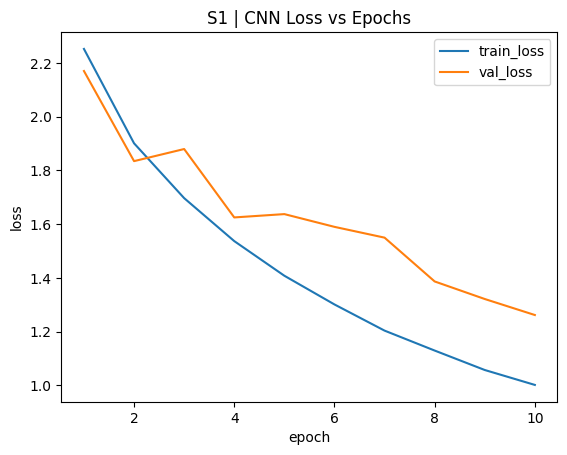

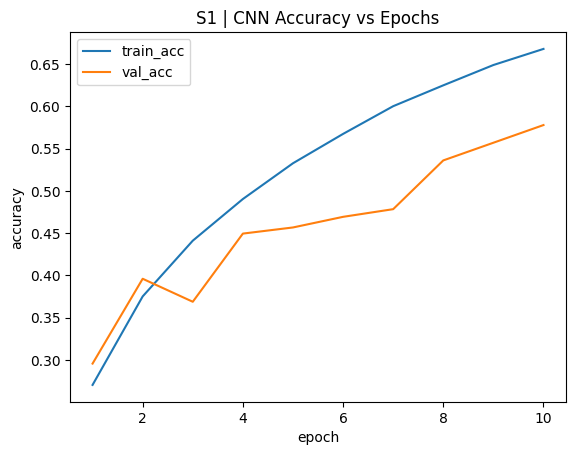


--- BiLSTM ---
Params total=545,041 | trainable=545,041 | size≈2.08 MB
Epoch 1/10 | time=12.55s | tr_loss=2.5254 tr_acc=0.1794 | va_loss=2.3543 va_acc=0.2214
Epoch 2/10 | time=12.49s | tr_loss=2.2189 tr_acc=0.2704 | va_loss=2.1097 va_acc=0.3030
Epoch 3/10 | time=12.50s | tr_loss=1.9947 tr_acc=0.3357 | va_loss=1.9052 va_acc=0.3622
Epoch 4/10 | time=12.61s | tr_loss=1.7817 tr_acc=0.4044 | va_loss=1.6904 va_acc=0.4302
Epoch 5/10 | time=12.60s | tr_loss=1.5859 tr_acc=0.4668 | va_loss=1.5269 va_acc=0.4832
Epoch 6/10 | time=12.62s | tr_loss=1.4122 tr_acc=0.5240 | va_loss=1.3535 va_acc=0.5346
Epoch 7/10 | time=12.53s | tr_loss=1.2432 tr_acc=0.5785 | va_loss=1.2201 va_acc=0.5817
Epoch 8/10 | time=12.49s | tr_loss=1.1153 tr_acc=0.6220 | va_loss=1.1021 va_acc=0.6208
Epoch 9/10 | time=12.45s | tr_loss=0.9903 tr_acc=0.6619 | va_loss=0.9745 va_acc=0.6623
Epoch 10/10 | time=12.44s | tr_loss=0.8757 tr_acc=0.7001 | va_loss=0.8957 va_acc=0.6859
TEST: acc=0.2335, precision=0.2996, recall=0.2549, f1=0.2

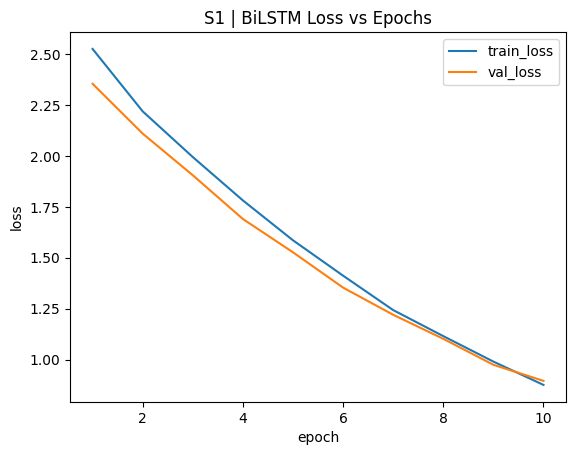

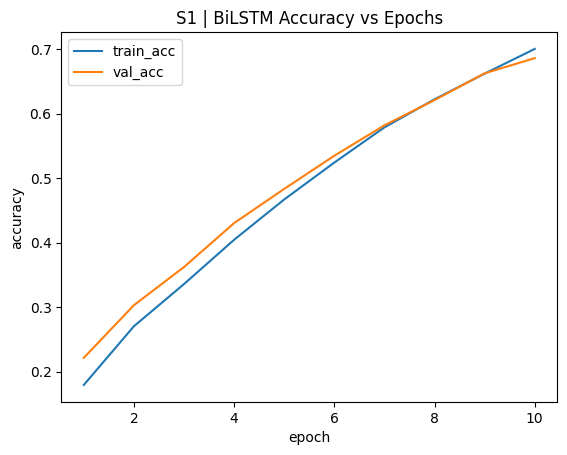


--- Transformer ---
Params total=797,201 | trainable=797,201 | size≈3.04 MB
Epoch 1/10 | time=23.44s | tr_loss=2.0987 tr_acc=0.3123 | va_loss=1.7586 va_acc=0.4001
Epoch 2/10 | time=23.47s | tr_loss=1.4950 tr_acc=0.4928 | va_loss=1.3232 va_acc=0.5450
Epoch 3/10 | time=23.47s | tr_loss=1.1651 tr_acc=0.5951 | va_loss=1.0479 va_acc=0.6287
Epoch 4/10 | time=23.52s | tr_loss=0.9531 tr_acc=0.6651 | va_loss=0.8844 va_acc=0.6918
Epoch 5/10 | time=23.44s | tr_loss=0.8093 tr_acc=0.7127 | va_loss=0.7874 va_acc=0.7177
Epoch 6/10 | time=23.43s | tr_loss=0.6979 tr_acc=0.7519 | va_loss=0.7364 va_acc=0.7394
Epoch 7/10 | time=23.40s | tr_loss=0.6154 tr_acc=0.7793 | va_loss=0.6788 va_acc=0.7548
Epoch 8/10 | time=23.43s | tr_loss=0.5621 tr_acc=0.7968 | va_loss=0.5955 va_acc=0.7889
Epoch 9/10 | time=23.53s | tr_loss=0.4964 tr_acc=0.8211 | va_loss=0.5797 va_acc=0.7933
Epoch 10/10 | time=23.47s | tr_loss=0.4545 tr_acc=0.8363 | va_loss=0.5157 va_acc=0.8167
TEST: acc=0.1958, precision=0.2415, recall=0.2092, f

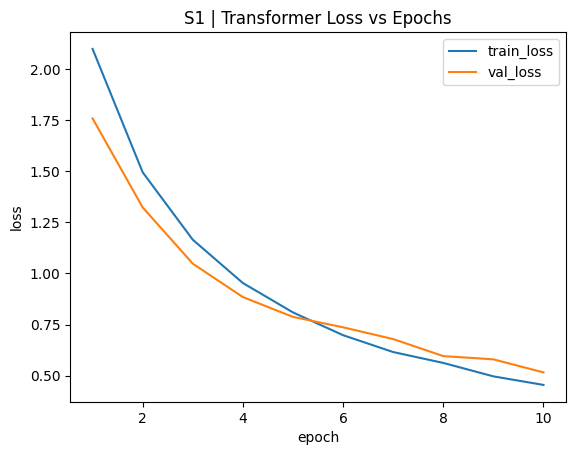

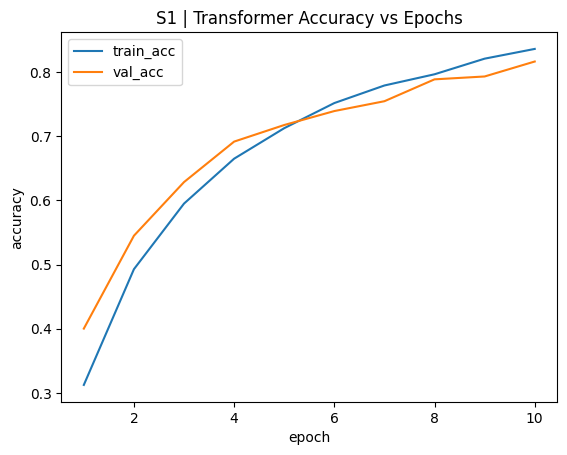


[TSMAE] Pretraining...


Pretrain epoch 1/10 | time=5.52s | loss=1.0143


Pretrain epoch 2/10 | time=4.13s | loss=1.0025


Pretrain epoch 3/10 | time=4.30s | loss=1.0126


Pretrain epoch 4/10 | time=5.03s | loss=1.0128


Pretrain epoch 5/10 | time=4.14s | loss=1.0176


Pretrain epoch 6/10 | time=4.32s | loss=1.0132


Pretrain epoch 7/10 | time=4.86s | loss=1.0077


Pretrain epoch 8/10 | time=4.14s | loss=1.0180


Pretrain epoch 9/10 | time=4.40s | loss=1.0079


Pretrain epoch 10/10 | time=4.88s | loss=1.0190
TSMAE pretrain total time (s): 45.71092128753662
[TSMAE] Fine-tuning...

--- TSMAE_finetune ---
Params total=892,681 | trainable=892,681 | size≈3.41 MB


Epoch 1/10 | time=4.68s | tr_loss=2.4016 tr_acc=0.2195 | va_loss=2.1625 va_acc=0.2892
Epoch 2/10 | time=5.29s | tr_loss=1.9928 tr_acc=0.3399 | va_loss=1.8394 va_acc=0.3906
Epoch 3/10 | time=4.82s | tr_loss=1.6720 tr_acc=0.4454 | va_loss=1.5829 va_acc=0.4677
Epoch 4/10 | time=4.63s | tr_loss=1.3751 tr_acc=0.5399 | va_loss=1.3465 va_acc=0.5479
Epoch 5/10 | time=5.46s | tr_loss=1.1130 tr_acc=0.6252 | va_loss=1.1036 va_acc=0.6265
Epoch 6/10 | time=4.63s | tr_loss=0.8924 tr_acc=0.7005 | va_loss=0.8975 va_acc=0.6975
Epoch 7/10 | time=4.94s | tr_loss=0.7152 tr_acc=0.7592 | va_loss=0.8303 va_acc=0.7293
Epoch 8/10 | time=5.23s | tr_loss=0.5819 tr_acc=0.8036 | va_loss=0.6938 va_acc=0.7745
Epoch 9/10 | time=4.63s | tr_loss=0.4785 tr_acc=0.8397 | va_loss=0.5924 va_acc=0.8083
Epoch 10/10 | time=5.33s | tr_loss=0.4181 tr_acc=0.8595 | va_loss=0.5555 va_acc=0.8216
TEST: acc=0.1676, precision=0.2232, recall=0.1737, f1=0.1587
Train time: per-epoch mean=4.96s | total=49.64s
Confusion matrix shape: (17, 1

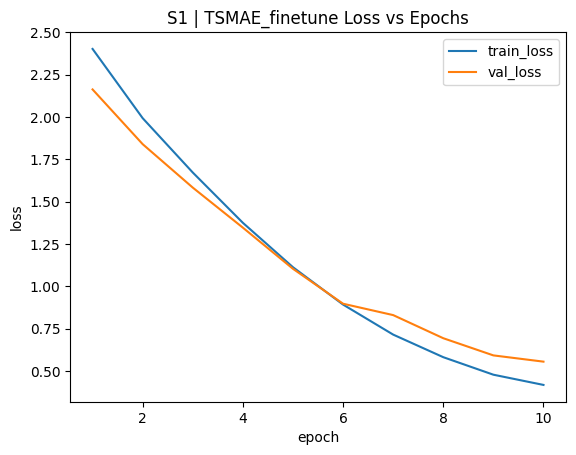

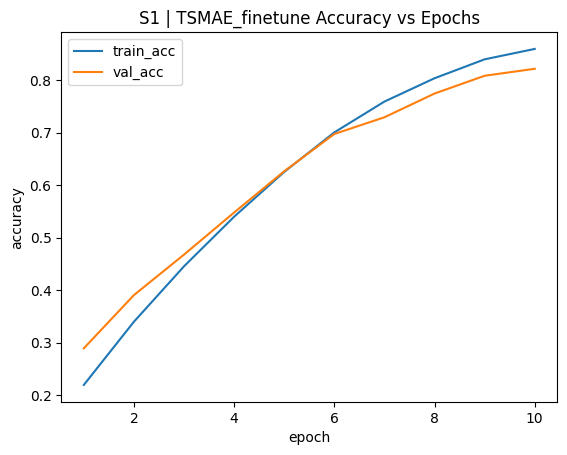


LOSO TEST SUBJECT: S2

--- CNN ---
Params total=232,273 | trainable=232,273 | size≈0.89 MB
Epoch 1/10 | time=2.70s | tr_loss=2.2442 tr_acc=0.2713 | va_loss=2.1574 va_acc=0.2885
Epoch 2/10 | time=2.58s | tr_loss=1.9022 tr_acc=0.3735 | va_loss=1.9492 va_acc=0.3582
Epoch 3/10 | time=2.56s | tr_loss=1.7120 tr_acc=0.4340 | va_loss=1.7791 va_acc=0.4089
Epoch 4/10 | time=3.30s | tr_loss=1.5413 tr_acc=0.4900 | va_loss=1.6324 va_acc=0.4661
Epoch 5/10 | time=2.78s | tr_loss=1.4118 tr_acc=0.5315 | va_loss=1.5333 va_acc=0.4929
Epoch 6/10 | time=2.60s | tr_loss=1.3059 tr_acc=0.5666 | va_loss=1.4728 va_acc=0.5021
Epoch 7/10 | time=2.61s | tr_loss=1.2135 tr_acc=0.5981 | va_loss=1.6284 va_acc=0.4799
Epoch 8/10 | time=2.62s | tr_loss=1.1394 tr_acc=0.6231 | va_loss=1.4680 va_acc=0.5259
Epoch 9/10 | time=3.40s | tr_loss=1.0834 tr_acc=0.6400 | va_loss=1.2938 va_acc=0.5715
Epoch 10/10 | time=2.63s | tr_loss=1.0096 tr_acc=0.6655 | va_loss=1.2091 va_acc=0.5927
TEST: acc=0.1702, precision=0.2036, recall=0.17

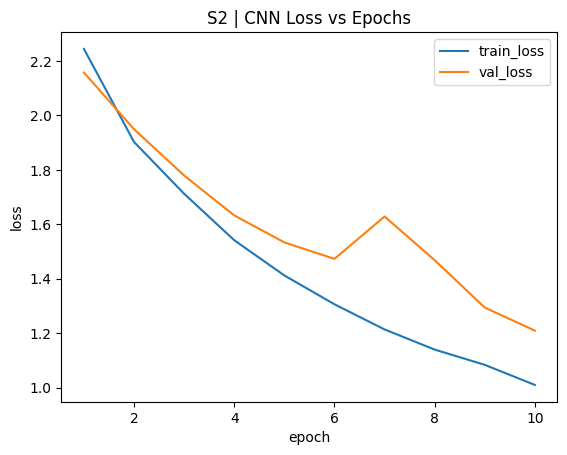

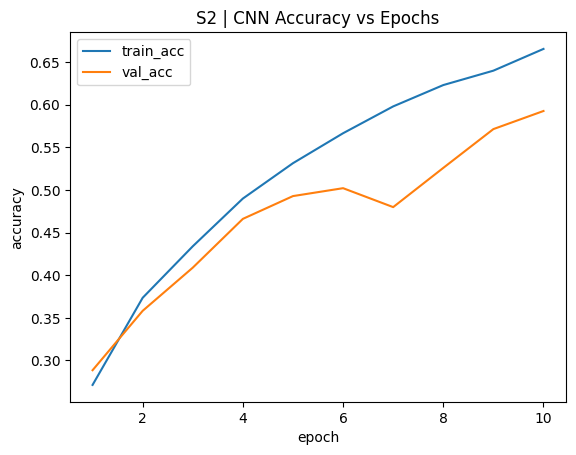


--- BiLSTM ---
Params total=545,041 | trainable=545,041 | size≈2.08 MB
Epoch 1/10 | time=12.39s | tr_loss=2.4776 tr_acc=0.1952 | va_loss=2.2615 va_acc=0.2579
Epoch 2/10 | time=12.39s | tr_loss=2.1535 tr_acc=0.2882 | va_loss=2.0260 va_acc=0.3255
Epoch 3/10 | time=12.53s | tr_loss=1.9208 tr_acc=0.3568 | va_loss=1.8525 va_acc=0.3759
Epoch 4/10 | time=12.50s | tr_loss=1.7087 tr_acc=0.4250 | va_loss=1.6307 va_acc=0.4529
Epoch 5/10 | time=12.50s | tr_loss=1.5328 tr_acc=0.4815 | va_loss=1.4573 va_acc=0.5042
Epoch 6/10 | time=12.54s | tr_loss=1.3861 tr_acc=0.5286 | va_loss=1.4083 va_acc=0.5246
Epoch 7/10 | time=12.56s | tr_loss=1.2398 tr_acc=0.5772 | va_loss=1.2184 va_acc=0.5861
Epoch 8/10 | time=12.53s | tr_loss=1.1058 tr_acc=0.6214 | va_loss=1.0540 va_acc=0.6366
Epoch 9/10 | time=12.54s | tr_loss=1.0030 tr_acc=0.6567 | va_loss=1.0062 va_acc=0.6470
Epoch 10/10 | time=12.46s | tr_loss=0.8970 tr_acc=0.6928 | va_loss=0.8973 va_acc=0.6881
TEST: acc=0.1420, precision=0.1666, recall=0.1557, f1=0.1

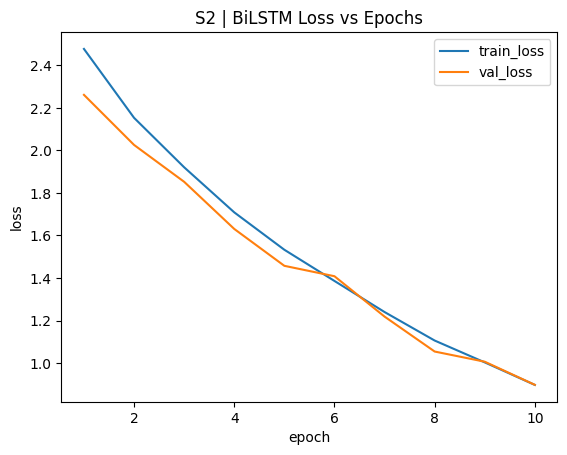

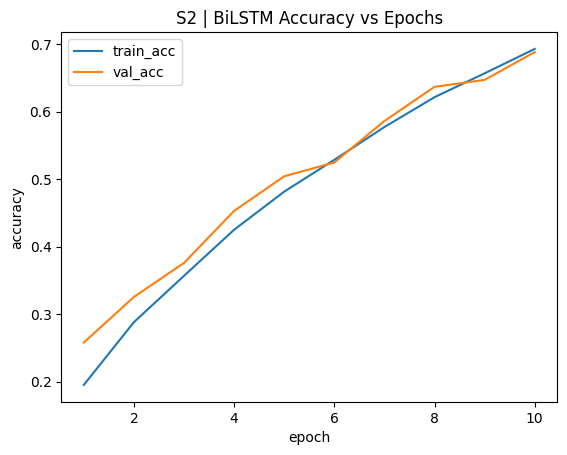


--- Transformer ---
Params total=797,201 | trainable=797,201 | size≈3.04 MB
Epoch 1/10 | time=23.44s | tr_loss=2.0645 tr_acc=0.3227 | va_loss=1.6563 va_acc=0.4365
Epoch 2/10 | time=23.30s | tr_loss=1.4964 tr_acc=0.4889 | va_loss=1.2493 va_acc=0.5551
Epoch 3/10 | time=23.27s | tr_loss=1.1804 tr_acc=0.5899 | va_loss=1.0368 va_acc=0.6332
Epoch 4/10 | time=23.36s | tr_loss=0.9691 tr_acc=0.6591 | va_loss=0.9096 va_acc=0.6717
Epoch 5/10 | time=23.30s | tr_loss=0.8266 tr_acc=0.7060 | va_loss=0.7811 va_acc=0.7177
Epoch 6/10 | time=23.32s | tr_loss=0.7125 tr_acc=0.7457 | va_loss=0.6758 va_acc=0.7521
Epoch 7/10 | time=23.32s | tr_loss=0.6266 tr_acc=0.7764 | va_loss=0.6110 va_acc=0.7735
Epoch 8/10 | time=23.40s | tr_loss=0.5633 tr_acc=0.7982 | va_loss=0.5791 va_acc=0.7904
Epoch 9/10 | time=23.50s | tr_loss=0.5021 tr_acc=0.8187 | va_loss=0.5684 va_acc=0.7935
Epoch 10/10 | time=23.43s | tr_loss=0.4560 tr_acc=0.8348 | va_loss=0.5008 va_acc=0.8183
TEST: acc=0.1110, precision=0.1823, recall=0.1259, f

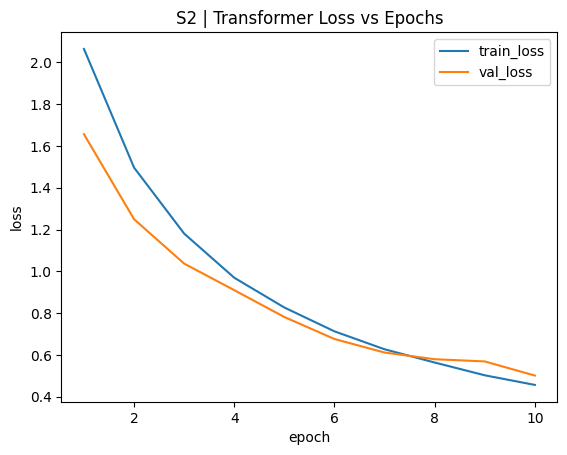

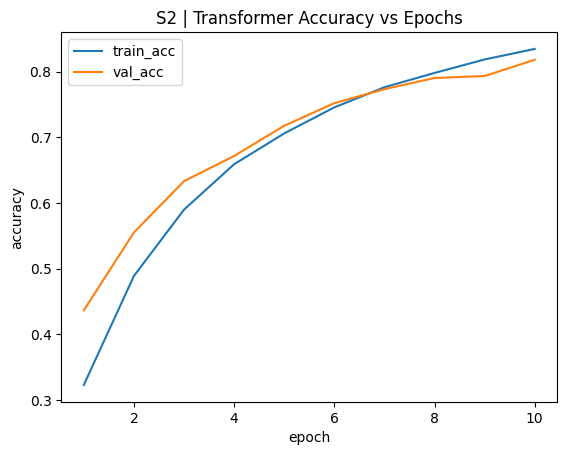


[TSMAE] Pretraining...


Pretrain epoch 1/10 | time=5.02s | loss=1.0076


Pretrain epoch 2/10 | time=4.25s | loss=1.0064


Pretrain epoch 3/10 | time=4.62s | loss=1.0054


Pretrain epoch 4/10 | time=5.02s | loss=1.0012


Pretrain epoch 5/10 | time=4.23s | loss=1.0116


Pretrain epoch 6/10 | time=4.75s | loss=1.0183


Pretrain epoch 7/10 | time=4.79s | loss=1.0030


Pretrain epoch 8/10 | time=4.30s | loss=1.0096


Pretrain epoch 9/10 | time=5.06s | loss=1.0172


Pretrain epoch 10/10 | time=4.64s | loss=1.0094
TSMAE pretrain total time (s): 46.69472908973694
[TSMAE] Fine-tuning...

--- TSMAE_finetune ---
Params total=892,681 | trainable=892,681 | size≈3.41 MB


Epoch 1/10 | time=4.74s | tr_loss=2.3941 tr_acc=0.2225 | va_loss=2.1232 va_acc=0.2973
Epoch 2/10 | time=5.59s | tr_loss=1.9756 tr_acc=0.3493 | va_loss=1.8503 va_acc=0.3772
Epoch 3/10 | time=4.66s | tr_loss=1.6618 tr_acc=0.4435 | va_loss=1.6033 va_acc=0.4661
Epoch 4/10 | time=4.88s | tr_loss=1.3699 tr_acc=0.5410 | va_loss=1.3760 va_acc=0.5463
Epoch 5/10 | time=5.37s | tr_loss=1.1142 tr_acc=0.6220 | va_loss=1.1029 va_acc=0.6199
Epoch 6/10 | time=4.74s | tr_loss=0.8890 tr_acc=0.6967 | va_loss=0.9333 va_acc=0.6795
Epoch 7/10 | time=5.57s | tr_loss=0.7107 tr_acc=0.7588 | va_loss=0.7895 va_acc=0.7306
Epoch 8/10 | time=4.66s | tr_loss=0.5749 tr_acc=0.8053 | va_loss=0.6832 va_acc=0.7689
Epoch 9/10 | time=4.64s | tr_loss=0.4830 tr_acc=0.8371 | va_loss=0.5820 va_acc=0.8045
Epoch 10/10 | time=5.54s | tr_loss=0.4067 tr_acc=0.8628 | va_loss=0.5046 va_acc=0.8317
TEST: acc=0.1341, precision=0.1415, recall=0.1392, f1=0.0990
Train time: per-epoch mean=5.04s | total=50.40s
Confusion matrix shape: (17, 1

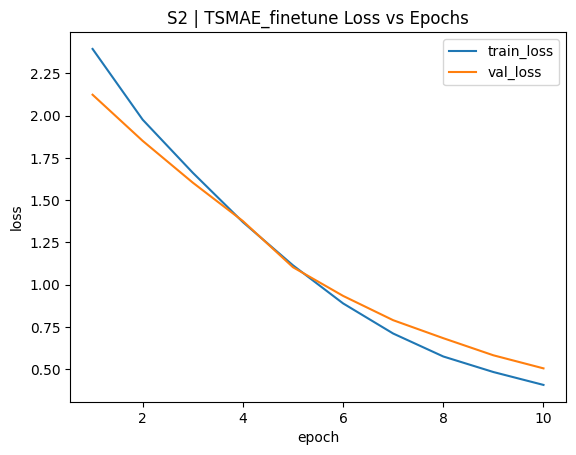

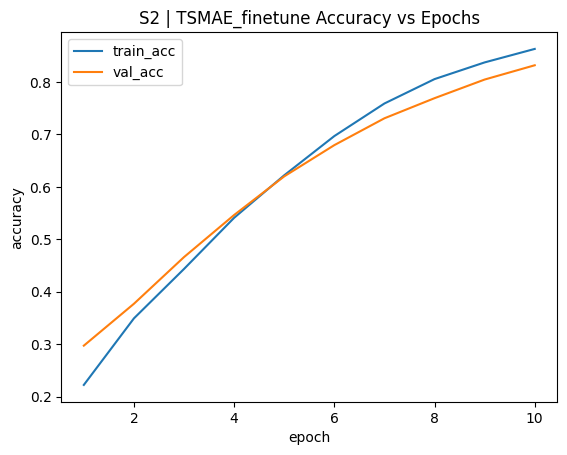


LOSO TEST SUBJECT: S3

--- CNN ---
Params total=232,273 | trainable=232,273 | size≈0.89 MB
Epoch 1/10 | time=2.76s | tr_loss=2.2779 tr_acc=0.2603 | va_loss=2.0986 va_acc=0.3156
Epoch 2/10 | time=2.66s | tr_loss=1.9306 tr_acc=0.3636 | va_loss=1.8719 va_acc=0.3764
Epoch 3/10 | time=3.33s | tr_loss=1.7060 tr_acc=0.4371 | va_loss=1.6645 va_acc=0.4444
Epoch 4/10 | time=3.01s | tr_loss=1.5483 tr_acc=0.4884 | va_loss=1.6003 va_acc=0.4566
Epoch 5/10 | time=2.69s | tr_loss=1.4225 tr_acc=0.5282 | va_loss=1.6235 va_acc=0.4507
Epoch 6/10 | time=2.67s | tr_loss=1.3077 tr_acc=0.5679 | va_loss=1.4495 va_acc=0.5133
Epoch 7/10 | time=2.68s | tr_loss=1.2259 tr_acc=0.5935 | va_loss=1.6139 va_acc=0.4593
Epoch 8/10 | time=3.43s | tr_loss=1.1466 tr_acc=0.6202 | va_loss=1.3472 va_acc=0.5382
Epoch 9/10 | time=2.66s | tr_loss=1.0773 tr_acc=0.6416 | va_loss=1.3415 va_acc=0.5585
Epoch 10/10 | time=2.65s | tr_loss=1.0123 tr_acc=0.6650 | va_loss=1.3001 va_acc=0.5547
TEST: acc=0.2067, precision=0.2309, recall=0.22

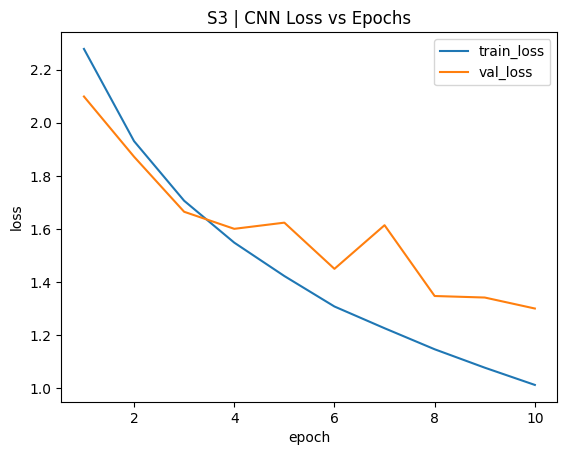

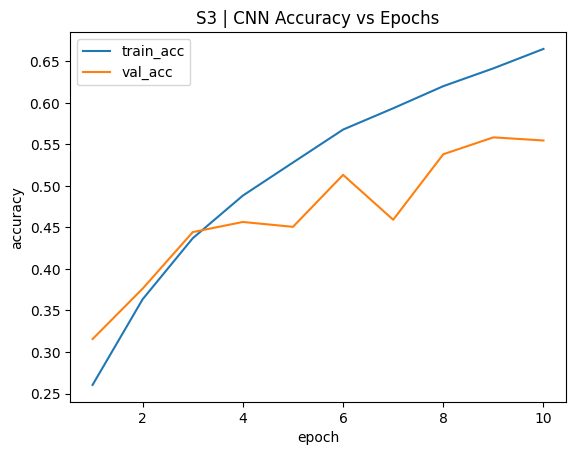


--- BiLSTM ---
Params total=545,041 | trainable=545,041 | size≈2.08 MB
Epoch 1/10 | time=12.39s | tr_loss=2.4971 tr_acc=0.1881 | va_loss=2.2748 va_acc=0.2564
Epoch 2/10 | time=12.38s | tr_loss=2.1658 tr_acc=0.2820 | va_loss=2.0469 va_acc=0.3183
Epoch 3/10 | time=12.41s | tr_loss=1.9292 tr_acc=0.3560 | va_loss=1.8066 va_acc=0.3973
Epoch 4/10 | time=12.42s | tr_loss=1.6969 tr_acc=0.4302 | va_loss=1.6282 va_acc=0.4473
Epoch 5/10 | time=12.39s | tr_loss=1.5163 tr_acc=0.4877 | va_loss=1.4382 va_acc=0.5047
Epoch 6/10 | time=12.39s | tr_loss=1.3501 tr_acc=0.5399 | va_loss=1.3329 va_acc=0.5433
Epoch 7/10 | time=12.39s | tr_loss=1.2041 tr_acc=0.5876 | va_loss=1.2175 va_acc=0.5814
Epoch 8/10 | time=12.48s | tr_loss=1.0778 tr_acc=0.6300 | va_loss=1.0719 va_acc=0.6323
Epoch 9/10 | time=12.57s | tr_loss=0.9621 tr_acc=0.6690 | va_loss=0.9960 va_acc=0.6590
Epoch 10/10 | time=12.60s | tr_loss=0.8761 tr_acc=0.6991 | va_loss=0.9020 va_acc=0.6805
TEST: acc=0.2173, precision=0.2567, recall=0.2452, f1=0.2

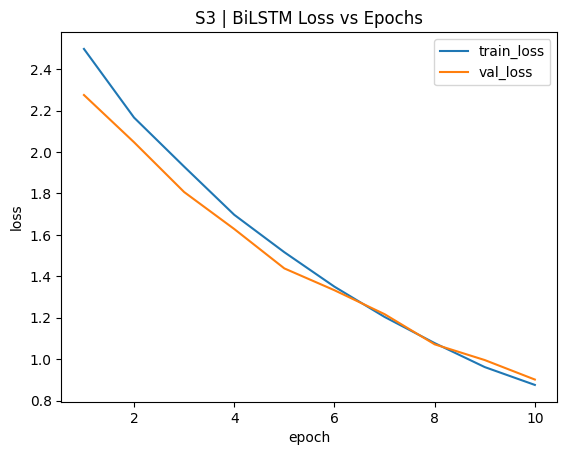

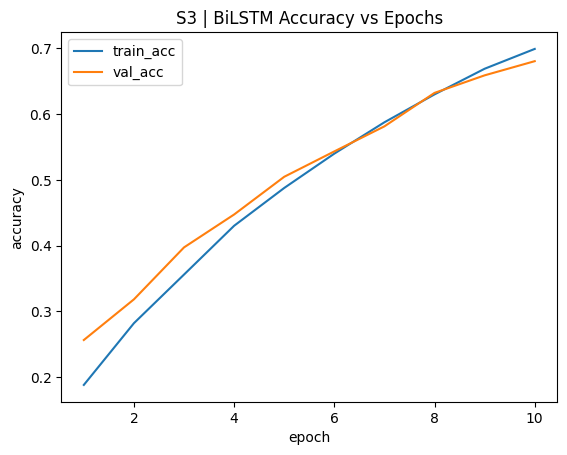


--- Transformer ---
Params total=797,201 | trainable=797,201 | size≈3.04 MB
Epoch 1/10 | time=23.39s | tr_loss=2.0865 tr_acc=0.3109 | va_loss=1.7252 va_acc=0.4188
Epoch 2/10 | time=23.48s | tr_loss=1.5077 tr_acc=0.4851 | va_loss=1.2937 va_acc=0.5570
Epoch 3/10 | time=23.44s | tr_loss=1.1848 tr_acc=0.5889 | va_loss=1.1125 va_acc=0.6140
Epoch 4/10 | time=23.40s | tr_loss=0.9757 tr_acc=0.6586 | va_loss=0.9618 va_acc=0.6631
Epoch 5/10 | time=23.53s | tr_loss=0.8320 tr_acc=0.7073 | va_loss=0.7939 va_acc=0.7228
Epoch 6/10 | time=23.41s | tr_loss=0.7237 tr_acc=0.7416 | va_loss=0.7327 va_acc=0.7360
Epoch 7/10 | time=23.49s | tr_loss=0.6191 tr_acc=0.7785 | va_loss=0.6481 va_acc=0.7662
Epoch 8/10 | time=23.42s | tr_loss=0.5639 tr_acc=0.7979 | va_loss=0.6015 va_acc=0.7830
Epoch 9/10 | time=23.35s | tr_loss=0.5053 tr_acc=0.8191 | va_loss=0.5731 va_acc=0.8017
Epoch 10/10 | time=23.45s | tr_loss=0.4624 tr_acc=0.8339 | va_loss=0.5237 va_acc=0.8158
TEST: acc=0.2373, precision=0.2708, recall=0.2384, f

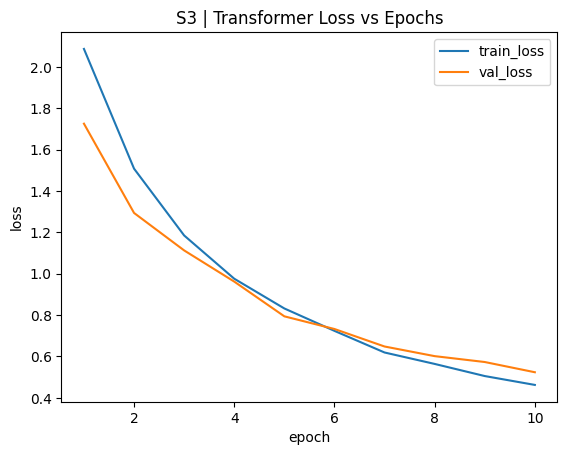

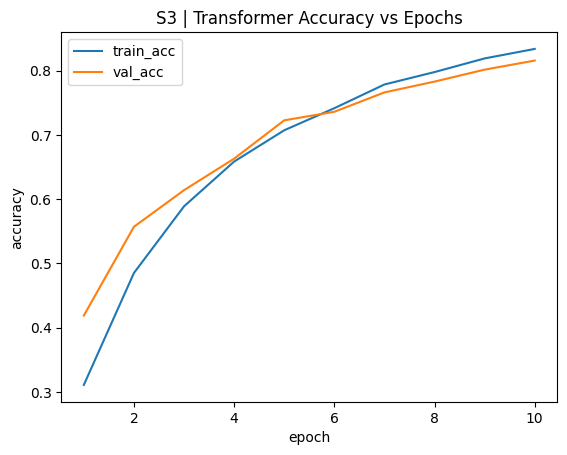


[TSMAE] Pretraining...


Pretrain epoch 1/10 | time=4.32s | loss=1.0229


Pretrain epoch 2/10 | time=4.29s | loss=1.0160


Pretrain epoch 3/10 | time=5.55s | loss=1.0254


Pretrain epoch 4/10 | time=4.42s | loss=1.0164


Pretrain epoch 5/10 | time=4.35s | loss=1.0097


Pretrain epoch 6/10 | time=5.29s | loss=1.0124


Pretrain epoch 7/10 | time=4.30s | loss=1.0077


Pretrain epoch 8/10 | time=4.29s | loss=1.0217


Pretrain epoch 9/10 | time=5.51s | loss=1.0148


Pretrain epoch 10/10 | time=4.36s | loss=1.0091
TSMAE pretrain total time (s): 46.68503212928772
[TSMAE] Fine-tuning...

--- TSMAE_finetune ---
Params total=892,681 | trainable=892,681 | size≈3.41 MB


Epoch 1/10 | time=5.07s | tr_loss=2.4058 tr_acc=0.2179 | va_loss=2.1393 va_acc=0.2900
Epoch 2/10 | time=5.18s | tr_loss=1.9883 tr_acc=0.3397 | va_loss=1.8499 va_acc=0.3828
Epoch 3/10 | time=4.63s | tr_loss=1.6615 tr_acc=0.4440 | va_loss=1.5722 va_acc=0.4741
Epoch 4/10 | time=5.58s | tr_loss=1.3633 tr_acc=0.5379 | va_loss=1.3200 va_acc=0.5650
Epoch 5/10 | time=4.69s | tr_loss=1.1021 tr_acc=0.6289 | va_loss=1.0921 va_acc=0.6381
Epoch 6/10 | time=4.66s | tr_loss=0.8850 tr_acc=0.7006 | va_loss=0.9115 va_acc=0.7029
Epoch 7/10 | time=5.48s | tr_loss=0.7013 tr_acc=0.7623 | va_loss=0.7714 va_acc=0.7517
Epoch 8/10 | time=4.66s | tr_loss=0.5759 tr_acc=0.8036 | va_loss=0.6504 va_acc=0.7869
Epoch 9/10 | time=5.03s | tr_loss=0.4756 tr_acc=0.8395 | va_loss=0.6383 va_acc=0.7892
Epoch 10/10 | time=5.10s | tr_loss=0.4050 tr_acc=0.8642 | va_loss=0.5114 va_acc=0.8347
TEST: acc=0.1918, precision=0.1831, recall=0.1774, f1=0.1661
Train time: per-epoch mean=5.01s | total=50.08s
Confusion matrix shape: (17, 1

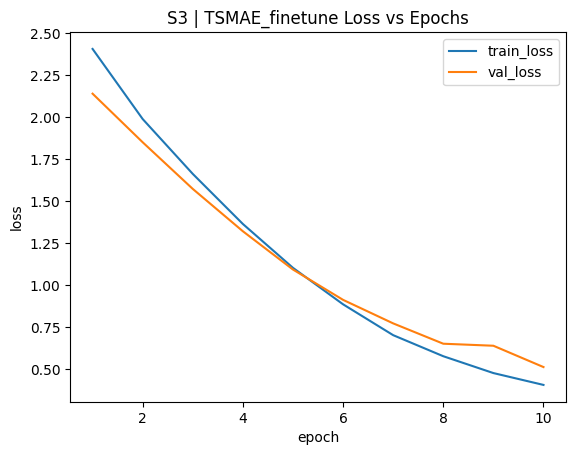

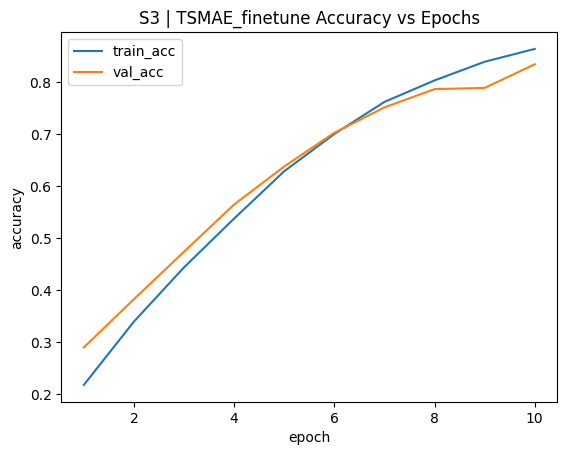


LOSO TEST SUBJECT: S4

--- CNN ---
Params total=232,273 | trainable=232,273 | size≈0.89 MB
Epoch 1/10 | time=2.69s | tr_loss=2.2473 tr_acc=0.2710 | va_loss=2.1624 va_acc=0.2855
Epoch 2/10 | time=2.87s | tr_loss=1.9083 tr_acc=0.3733 | va_loss=1.9663 va_acc=0.3560
Epoch 3/10 | time=3.21s | tr_loss=1.7110 tr_acc=0.4357 | va_loss=2.1504 va_acc=0.2986
Epoch 4/10 | time=2.59s | tr_loss=1.5446 tr_acc=0.4902 | va_loss=1.5897 va_acc=0.4701
Epoch 5/10 | time=2.57s | tr_loss=1.4161 tr_acc=0.5296 | va_loss=1.5077 va_acc=0.4903
Epoch 6/10 | time=2.59s | tr_loss=1.3148 tr_acc=0.5647 | va_loss=1.5991 va_acc=0.4660
Epoch 7/10 | time=3.00s | tr_loss=1.2257 tr_acc=0.5920 | va_loss=1.4196 va_acc=0.5212
Epoch 8/10 | time=3.14s | tr_loss=1.1402 tr_acc=0.6218 | va_loss=1.3703 va_acc=0.5512
Epoch 9/10 | time=2.59s | tr_loss=1.0723 tr_acc=0.6441 | va_loss=1.2760 va_acc=0.5672
Epoch 10/10 | time=2.60s | tr_loss=1.0097 tr_acc=0.6654 | va_loss=1.3143 va_acc=0.5579
TEST: acc=0.1468, precision=0.2308, recall=0.15

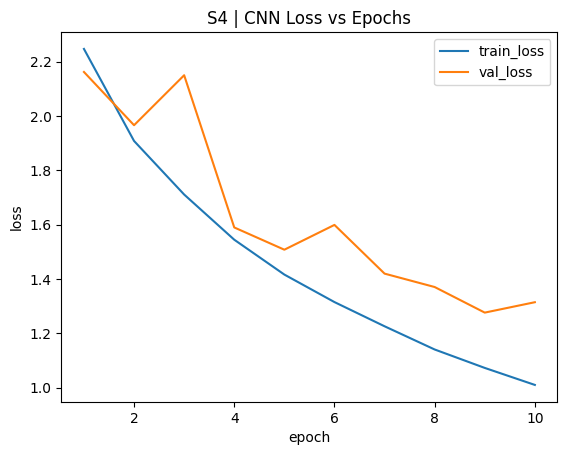

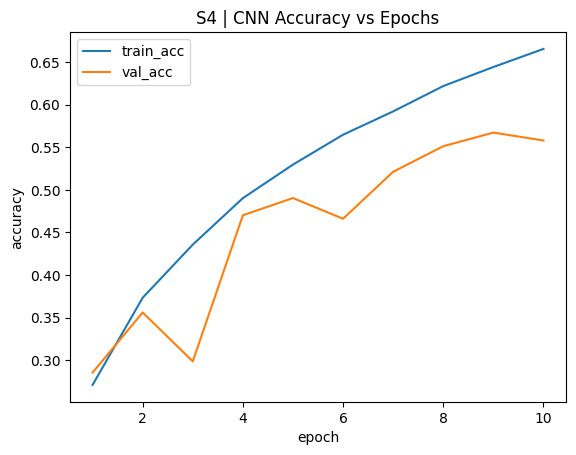


--- BiLSTM ---
Params total=545,041 | trainable=545,041 | size≈2.08 MB
Epoch 1/10 | time=12.20s | tr_loss=2.4664 tr_acc=0.1964 | va_loss=2.2416 va_acc=0.2625
Epoch 2/10 | time=12.20s | tr_loss=2.1409 tr_acc=0.2904 | va_loss=2.0362 va_acc=0.3245
Epoch 3/10 | time=12.20s | tr_loss=1.9326 tr_acc=0.3559 | va_loss=1.8500 va_acc=0.3799
Epoch 4/10 | time=12.18s | tr_loss=1.7240 tr_acc=0.4208 | va_loss=1.6278 va_acc=0.4564
Epoch 5/10 | time=12.20s | tr_loss=1.5184 tr_acc=0.4862 | va_loss=1.4557 va_acc=0.5154
Epoch 6/10 | time=12.21s | tr_loss=1.3468 tr_acc=0.5444 | va_loss=1.3227 va_acc=0.5596
Epoch 7/10 | time=12.29s | tr_loss=1.1937 tr_acc=0.5940 | va_loss=1.1994 va_acc=0.5914
Epoch 8/10 | time=12.34s | tr_loss=1.0668 tr_acc=0.6340 | va_loss=1.0719 va_acc=0.6330
Epoch 9/10 | time=12.40s | tr_loss=0.9537 tr_acc=0.6742 | va_loss=0.9939 va_acc=0.6586
Epoch 10/10 | time=12.41s | tr_loss=0.8616 tr_acc=0.7046 | va_loss=0.9108 va_acc=0.6884
TEST: acc=0.1927, precision=0.2359, recall=0.2063, f1=0.2

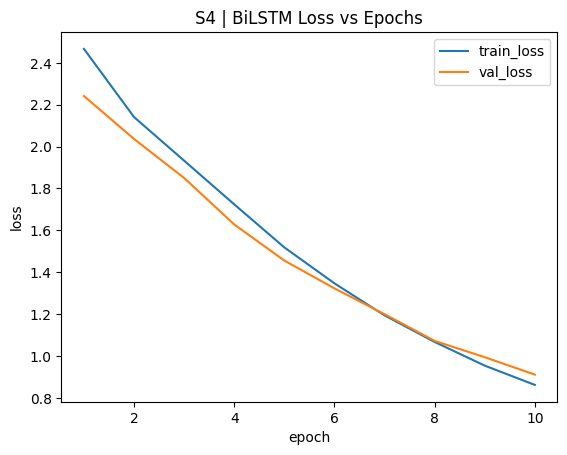

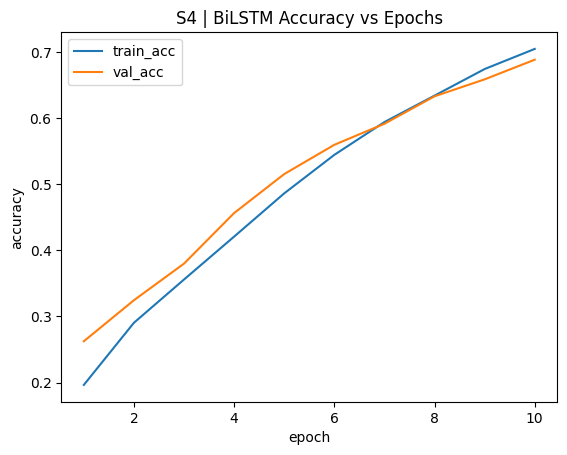


--- Transformer ---
Params total=797,201 | trainable=797,201 | size≈3.04 MB
Epoch 1/10 | time=23.03s | tr_loss=2.0721 tr_acc=0.3206 | va_loss=1.7223 va_acc=0.4115
Epoch 2/10 | time=23.03s | tr_loss=1.4720 tr_acc=0.4983 | va_loss=1.3332 va_acc=0.5449
Epoch 3/10 | time=22.94s | tr_loss=1.1442 tr_acc=0.6046 | va_loss=1.0763 va_acc=0.6274
Epoch 4/10 | time=22.97s | tr_loss=0.9431 tr_acc=0.6685 | va_loss=0.9116 va_acc=0.6828
Epoch 5/10 | time=22.94s | tr_loss=0.7987 tr_acc=0.7199 | va_loss=0.7931 va_acc=0.7265
Epoch 6/10 | time=22.97s | tr_loss=0.6950 tr_acc=0.7539 | va_loss=0.6873 va_acc=0.7586
Epoch 7/10 | time=22.94s | tr_loss=0.6107 tr_acc=0.7816 | va_loss=0.6456 va_acc=0.7729
Epoch 8/10 | time=23.08s | tr_loss=0.5440 tr_acc=0.8057 | va_loss=0.6117 va_acc=0.7840
Epoch 9/10 | time=23.04s | tr_loss=0.4915 tr_acc=0.8249 | va_loss=0.5389 va_acc=0.8128
Epoch 10/10 | time=23.02s | tr_loss=0.4321 tr_acc=0.8455 | va_loss=0.5585 va_acc=0.8103
TEST: acc=0.1578, precision=0.2015, recall=0.1809, f

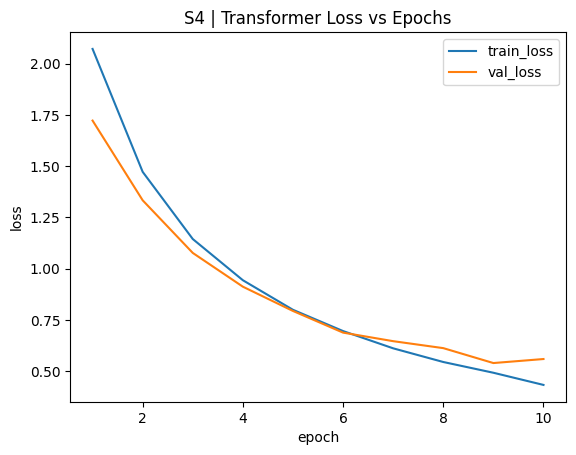

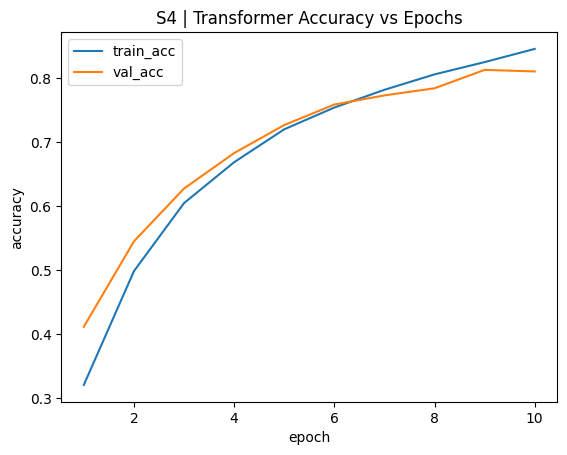


[TSMAE] Pretraining...


Pretrain epoch 1/10 | time=5.07s | loss=1.0149


Pretrain epoch 2/10 | time=4.63s | loss=1.0158


Pretrain epoch 3/10 | time=4.36s | loss=1.0138


Pretrain epoch 4/10 | time=5.19s | loss=1.0183


Pretrain epoch 5/10 | time=4.44s | loss=1.0141


Pretrain epoch 6/10 | time=4.29s | loss=1.0060


Pretrain epoch 7/10 | time=5.35s | loss=1.0139


Pretrain epoch 8/10 | time=4.33s | loss=1.0159


Pretrain epoch 9/10 | time=4.37s | loss=1.0153


Pretrain epoch 10/10 | time=5.44s | loss=1.0101
TSMAE pretrain total time (s): 47.46344017982483
[TSMAE] Fine-tuning...

--- TSMAE_finetune ---
Params total=892,681 | trainable=892,681 | size≈3.41 MB


Epoch 1/10 | time=4.59s | tr_loss=2.4000 tr_acc=0.2238 | va_loss=2.1505 va_acc=0.2911
Epoch 2/10 | time=4.54s | tr_loss=1.9824 tr_acc=0.3436 | va_loss=1.8277 va_acc=0.3908
Epoch 3/10 | time=5.46s | tr_loss=1.6597 tr_acc=0.4448 | va_loss=1.5772 va_acc=0.4668
Epoch 4/10 | time=4.58s | tr_loss=1.3646 tr_acc=0.5427 | va_loss=1.3515 va_acc=0.5435
Epoch 5/10 | time=5.03s | tr_loss=1.0974 tr_acc=0.6303 | va_loss=1.0814 va_acc=0.6420
Epoch 6/10 | time=5.08s | tr_loss=0.8835 tr_acc=0.7000 | va_loss=0.9435 va_acc=0.6838
Epoch 7/10 | time=4.59s | tr_loss=0.7038 tr_acc=0.7635 | va_loss=0.8324 va_acc=0.7300
Epoch 8/10 | time=5.43s | tr_loss=0.5803 tr_acc=0.8042 | va_loss=0.7061 va_acc=0.7660
Epoch 9/10 | time=4.59s | tr_loss=0.4816 tr_acc=0.8369 | va_loss=0.6030 va_acc=0.8027
Epoch 10/10 | time=4.53s | tr_loss=0.4029 tr_acc=0.8644 | va_loss=0.5370 va_acc=0.8294
TEST: acc=0.1389, precision=0.1714, recall=0.1361, f1=0.1324
Train time: per-epoch mean=4.84s | total=48.43s
Confusion matrix shape: (17, 1

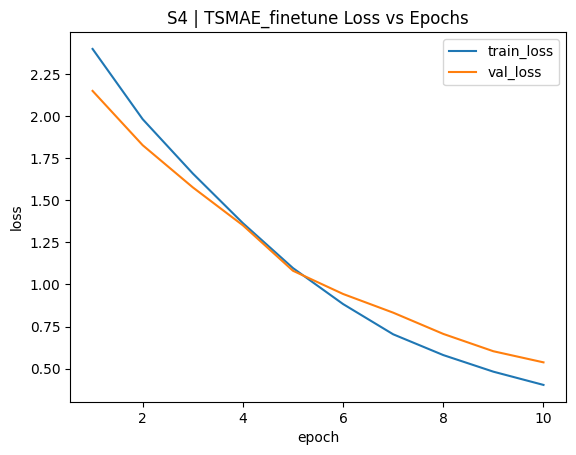

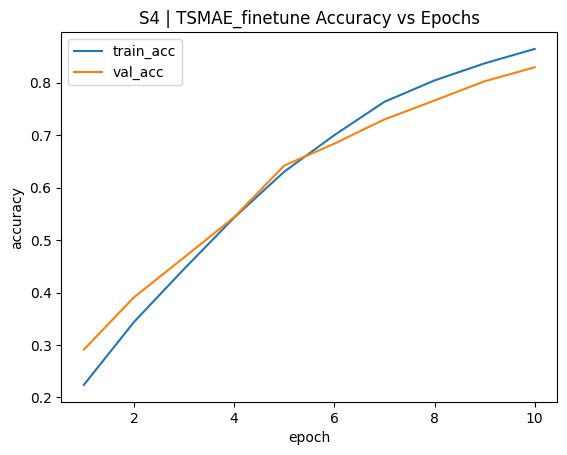


LOSO TEST SUBJECT: S5

--- CNN ---
Params total=232,273 | trainable=232,273 | size≈0.89 MB
Epoch 1/10 | time=3.61s | tr_loss=2.2646 tr_acc=0.2693 | va_loss=2.0812 va_acc=0.3155
Epoch 2/10 | time=3.18s | tr_loss=1.9121 tr_acc=0.3718 | va_loss=1.8422 va_acc=0.3973
Epoch 3/10 | time=3.09s | tr_loss=1.7030 tr_acc=0.4392 | va_loss=1.6657 va_acc=0.4499
Epoch 4/10 | time=3.74s | tr_loss=1.5345 tr_acc=0.4923 | va_loss=1.6163 va_acc=0.4556
Epoch 5/10 | time=3.42s | tr_loss=1.4142 tr_acc=0.5305 | va_loss=1.5922 va_acc=0.4694
Epoch 6/10 | time=3.11s | tr_loss=1.3086 tr_acc=0.5650 | va_loss=1.5357 va_acc=0.4985
Epoch 7/10 | time=3.26s | tr_loss=1.2189 tr_acc=0.5955 | va_loss=1.4863 va_acc=0.5200
Epoch 8/10 | time=3.96s | tr_loss=1.1326 tr_acc=0.6247 | va_loss=1.4882 va_acc=0.5066
Epoch 9/10 | time=3.34s | tr_loss=1.0802 tr_acc=0.6410 | va_loss=1.1748 va_acc=0.5966
Epoch 10/10 | time=3.13s | tr_loss=1.0116 tr_acc=0.6638 | va_loss=1.2412 va_acc=0.5833
TEST: acc=0.2162, precision=0.2023, recall=0.25

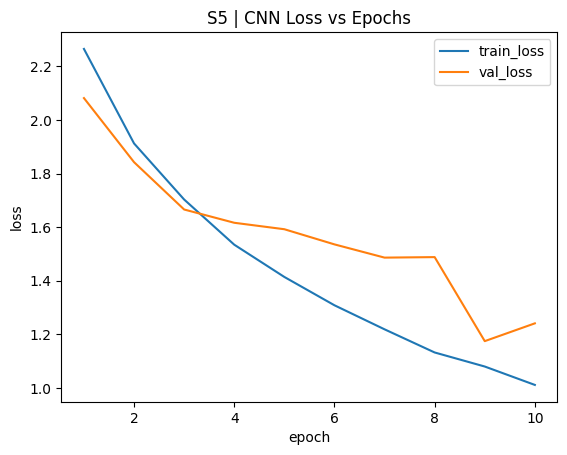

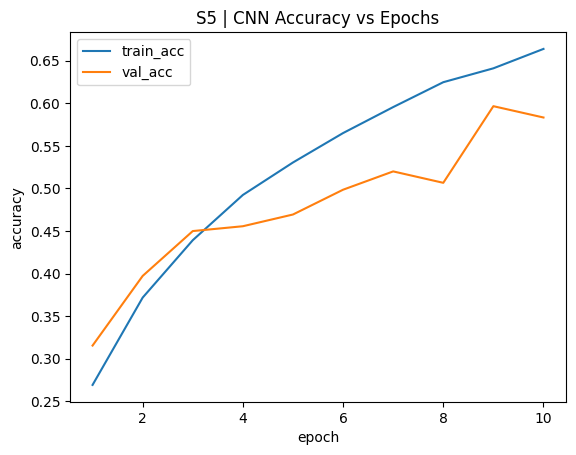


--- BiLSTM ---
Params total=545,041 | trainable=545,041 | size≈2.08 MB
Epoch 1/10 | time=13.04s | tr_loss=2.5179 tr_acc=0.1841 | va_loss=2.3196 va_acc=0.2399
Epoch 2/10 | time=12.90s | tr_loss=2.1799 tr_acc=0.2842 | va_loss=2.1195 va_acc=0.2843
Epoch 3/10 | time=12.86s | tr_loss=1.9471 tr_acc=0.3509 | va_loss=1.8367 va_acc=0.3775
Epoch 4/10 | time=12.89s | tr_loss=1.7163 tr_acc=0.4274 | va_loss=1.6215 va_acc=0.4620
Epoch 5/10 | time=12.89s | tr_loss=1.5205 tr_acc=0.4878 | va_loss=1.4816 va_acc=0.4990
Epoch 6/10 | time=12.90s | tr_loss=1.3484 tr_acc=0.5433 | va_loss=1.2961 va_acc=0.5568
Epoch 7/10 | time=12.92s | tr_loss=1.2004 tr_acc=0.5921 | va_loss=1.1757 va_acc=0.5990
Epoch 8/10 | time=12.98s | tr_loss=1.0633 tr_acc=0.6351 | va_loss=1.0338 va_acc=0.6415
Epoch 9/10 | time=12.89s | tr_loss=0.9424 tr_acc=0.6758 | va_loss=0.9401 va_acc=0.6744
Epoch 10/10 | time=12.91s | tr_loss=0.8486 tr_acc=0.7095 | va_loss=0.8777 va_acc=0.6949
TEST: acc=0.2380, precision=0.2661, recall=0.2556, f1=0.2

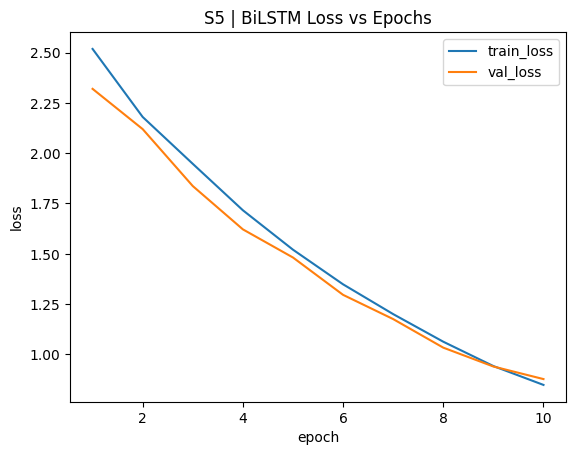

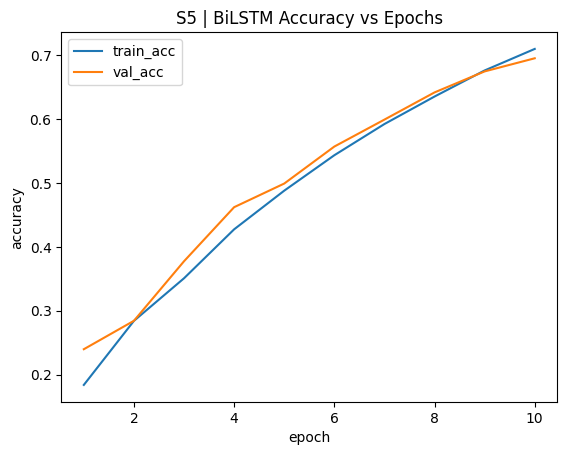


--- Transformer ---
Params total=797,201 | trainable=797,201 | size≈3.04 MB
Epoch 1/10 | time=24.37s | tr_loss=2.0798 tr_acc=0.3188 | va_loss=1.6603 va_acc=0.4440
Epoch 2/10 | time=24.67s | tr_loss=1.4744 tr_acc=0.4967 | va_loss=1.2788 va_acc=0.5543
Epoch 3/10 | time=24.43s | tr_loss=1.1669 tr_acc=0.5977 | va_loss=1.0824 va_acc=0.6189
Epoch 4/10 | time=23.70s | tr_loss=0.9662 tr_acc=0.6616 | va_loss=0.8890 va_acc=0.6901
Epoch 5/10 | time=23.67s | tr_loss=0.8177 tr_acc=0.7123 | va_loss=0.7883 va_acc=0.7218
Epoch 6/10 | time=23.58s | tr_loss=0.7046 tr_acc=0.7506 | va_loss=0.7707 va_acc=0.7276
Epoch 7/10 | time=23.62s | tr_loss=0.6237 tr_acc=0.7776 | va_loss=0.6715 va_acc=0.7582
Epoch 8/10 | time=23.74s | tr_loss=0.5439 tr_acc=0.8050 | va_loss=0.5976 va_acc=0.7869
Epoch 9/10 | time=23.72s | tr_loss=0.4858 tr_acc=0.8270 | va_loss=0.5554 va_acc=0.8050
Epoch 10/10 | time=23.66s | tr_loss=0.4449 tr_acc=0.8406 | va_loss=0.5026 va_acc=0.8208
TEST: acc=0.2410, precision=0.2224, recall=0.2570, f

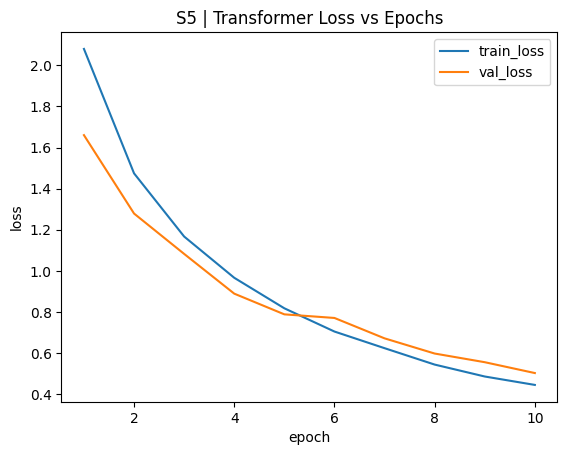

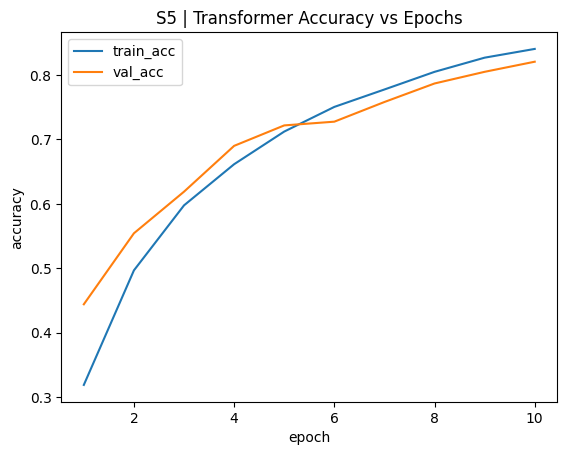


[TSMAE] Pretraining...


Pretrain epoch 1/10 | time=5.55s | loss=1.0220


Pretrain epoch 2/10 | time=4.51s | loss=1.0035


Pretrain epoch 3/10 | time=4.47s | loss=1.0192


Pretrain epoch 4/10 | time=5.62s | loss=1.0213


Pretrain epoch 5/10 | time=4.57s | loss=1.0159


Pretrain epoch 6/10 | time=5.22s | loss=1.0076


Pretrain epoch 7/10 | time=5.23s | loss=1.0094


Pretrain epoch 8/10 | time=4.52s | loss=1.0106


Pretrain epoch 9/10 | time=5.41s | loss=1.0143


Pretrain epoch 10/10 | time=4.92s | loss=1.0119
TSMAE pretrain total time (s): 50.020872354507446
[TSMAE] Fine-tuning...

--- TSMAE_finetune ---
Params total=892,681 | trainable=892,681 | size≈3.41 MB


Epoch 1/10 | time=4.72s | tr_loss=2.4051 tr_acc=0.2214 | va_loss=2.1355 va_acc=0.2824
Epoch 2/10 | time=5.74s | tr_loss=1.9967 tr_acc=0.3389 | va_loss=1.8553 va_acc=0.3881
Epoch 3/10 | time=4.69s | tr_loss=1.6966 tr_acc=0.4353 | va_loss=1.5674 va_acc=0.4722
Epoch 4/10 | time=5.00s | tr_loss=1.4082 tr_acc=0.5269 | va_loss=1.3335 va_acc=0.5574
Epoch 5/10 | time=5.45s | tr_loss=1.1456 tr_acc=0.6156 | va_loss=1.1648 va_acc=0.6099
Epoch 6/10 | time=4.81s | tr_loss=0.9110 tr_acc=0.6952 | va_loss=0.9405 va_acc=0.6881
Epoch 7/10 | time=5.76s | tr_loss=0.7352 tr_acc=0.7522 | va_loss=0.7882 va_acc=0.7399
Epoch 8/10 | time=4.78s | tr_loss=0.5966 tr_acc=0.7989 | va_loss=0.6971 va_acc=0.7674
Epoch 9/10 | time=4.74s | tr_loss=0.5025 tr_acc=0.8310 | va_loss=0.6134 va_acc=0.8022
Epoch 10/10 | time=5.68s | tr_loss=0.4143 tr_acc=0.8609 | va_loss=0.5553 va_acc=0.8174
TEST: acc=0.2137, precision=0.2421, recall=0.2373, f1=0.2179
Train time: per-epoch mean=5.14s | total=51.38s
Confusion matrix shape: (17, 1

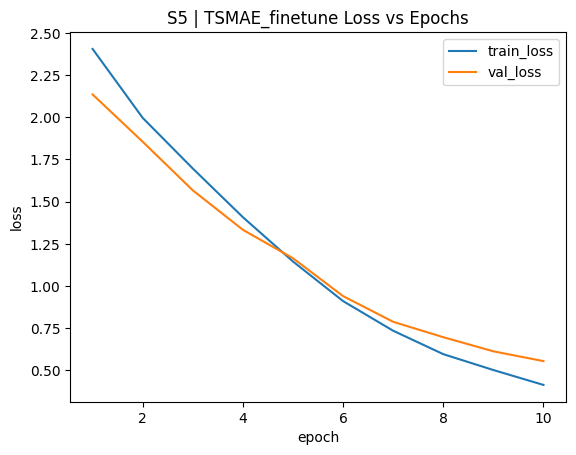

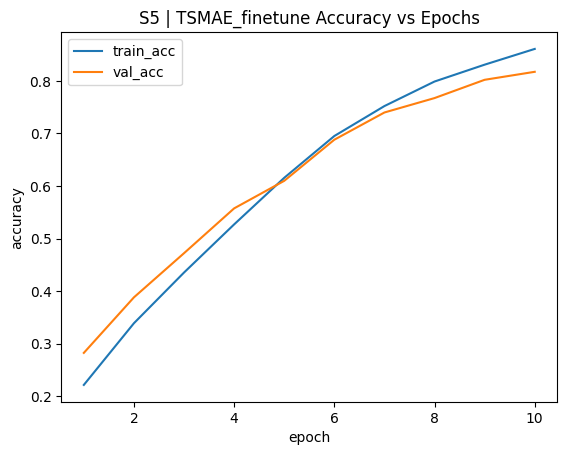


LOSO TEST SUBJECT: S6

--- CNN ---
Params total=232,273 | trainable=232,273 | size≈0.89 MB
Epoch 1/10 | time=2.77s | tr_loss=2.2598 tr_acc=0.2658 | va_loss=2.1281 va_acc=0.2969
Epoch 2/10 | time=2.66s | tr_loss=1.9119 tr_acc=0.3727 | va_loss=1.8781 va_acc=0.3733
Epoch 3/10 | time=3.39s | tr_loss=1.7067 tr_acc=0.4364 | va_loss=1.6867 va_acc=0.4403
Epoch 4/10 | time=2.75s | tr_loss=1.5338 tr_acc=0.4926 | va_loss=1.6020 va_acc=0.4585
Epoch 5/10 | time=2.65s | tr_loss=1.4133 tr_acc=0.5289 | va_loss=1.5312 va_acc=0.4916
Epoch 6/10 | time=2.63s | tr_loss=1.3107 tr_acc=0.5621 | va_loss=1.5194 va_acc=0.5004
Epoch 7/10 | time=2.82s | tr_loss=1.2194 tr_acc=0.5966 | va_loss=1.4389 va_acc=0.5207
Epoch 8/10 | time=3.31s | tr_loss=1.1410 tr_acc=0.6194 | va_loss=1.4374 va_acc=0.5227
Epoch 9/10 | time=2.62s | tr_loss=1.0721 tr_acc=0.6431 | va_loss=1.3069 va_acc=0.5637
Epoch 10/10 | time=2.65s | tr_loss=1.0105 tr_acc=0.6639 | va_loss=1.4164 va_acc=0.5340
TEST: acc=0.1545, precision=0.2387, recall=0.17

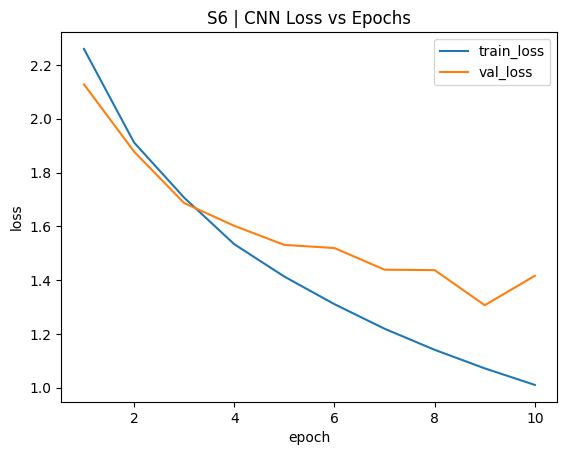

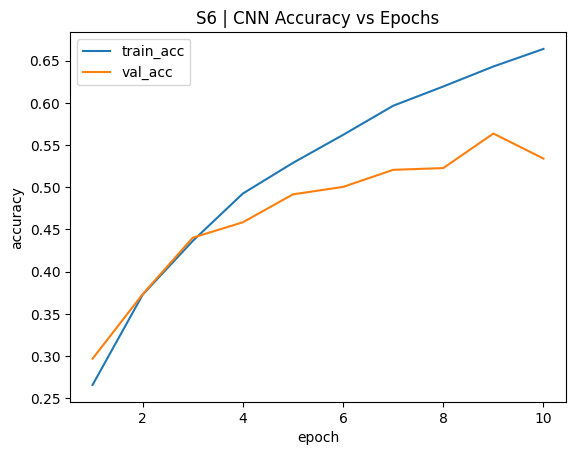


--- BiLSTM ---
Params total=545,041 | trainable=545,041 | size≈2.08 MB
Epoch 1/10 | time=12.32s | tr_loss=2.4923 tr_acc=0.1877 | va_loss=2.2937 va_acc=0.2486
Epoch 2/10 | time=12.33s | tr_loss=2.1537 tr_acc=0.2892 | va_loss=2.0573 va_acc=0.3106
Epoch 3/10 | time=12.32s | tr_loss=1.9089 tr_acc=0.3607 | va_loss=1.8490 va_acc=0.3750
Epoch 4/10 | time=12.32s | tr_loss=1.6645 tr_acc=0.4400 | va_loss=1.5535 va_acc=0.4759
Epoch 5/10 | time=12.35s | tr_loss=1.4590 tr_acc=0.5038 | va_loss=1.3791 va_acc=0.5287
Epoch 6/10 | time=12.34s | tr_loss=1.2962 tr_acc=0.5605 | va_loss=1.2302 va_acc=0.5805
Epoch 7/10 | time=12.39s | tr_loss=1.1425 tr_acc=0.6097 | va_loss=1.1095 va_acc=0.6148
Epoch 8/10 | time=12.49s | tr_loss=1.0221 tr_acc=0.6519 | va_loss=1.0095 va_acc=0.6514
Epoch 9/10 | time=12.53s | tr_loss=0.9377 tr_acc=0.6786 | va_loss=0.9225 va_acc=0.6867
Epoch 10/10 | time=12.54s | tr_loss=0.8321 tr_acc=0.7139 | va_loss=0.8615 va_acc=0.7040
TEST: acc=0.1798, precision=0.1906, recall=0.2264, f1=0.1

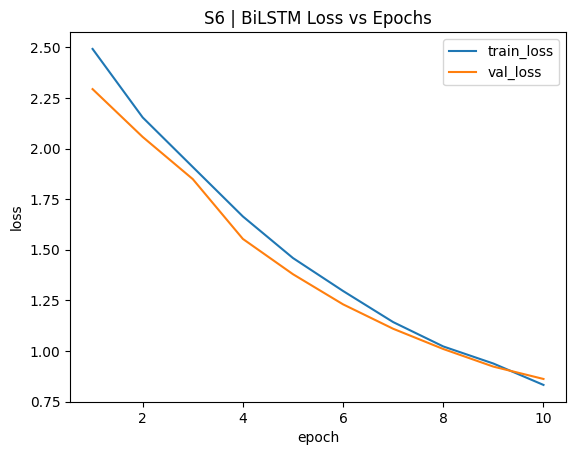

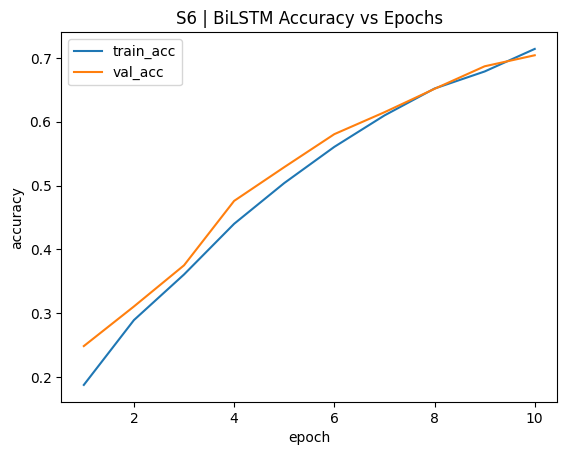


--- Transformer ---
Params total=797,201 | trainable=797,201 | size≈3.04 MB
Epoch 1/10 | time=23.29s | tr_loss=2.0832 tr_acc=0.3162 | va_loss=1.7000 va_acc=0.4233
Epoch 2/10 | time=23.19s | tr_loss=1.4806 tr_acc=0.4913 | va_loss=1.2913 va_acc=0.5601
Epoch 3/10 | time=23.13s | tr_loss=1.1668 tr_acc=0.5935 | va_loss=1.0427 va_acc=0.6365
Epoch 4/10 | time=23.14s | tr_loss=0.9538 tr_acc=0.6655 | va_loss=0.9066 va_acc=0.6804
Epoch 5/10 | time=23.23s | tr_loss=0.8242 tr_acc=0.7072 | va_loss=0.7820 va_acc=0.7218
Epoch 6/10 | time=23.17s | tr_loss=0.7101 tr_acc=0.7461 | va_loss=0.7072 va_acc=0.7468
Epoch 7/10 | time=23.16s | tr_loss=0.6241 tr_acc=0.7749 | va_loss=0.6589 va_acc=0.7664
Epoch 8/10 | time=23.18s | tr_loss=0.5611 tr_acc=0.7982 | va_loss=0.5944 va_acc=0.7893
Epoch 9/10 | time=23.26s | tr_loss=0.5097 tr_acc=0.8164 | va_loss=0.5460 va_acc=0.8093
Epoch 10/10 | time=23.23s | tr_loss=0.4598 tr_acc=0.8358 | va_loss=0.5202 va_acc=0.8124
TEST: acc=0.1856, precision=0.2303, recall=0.2264, f

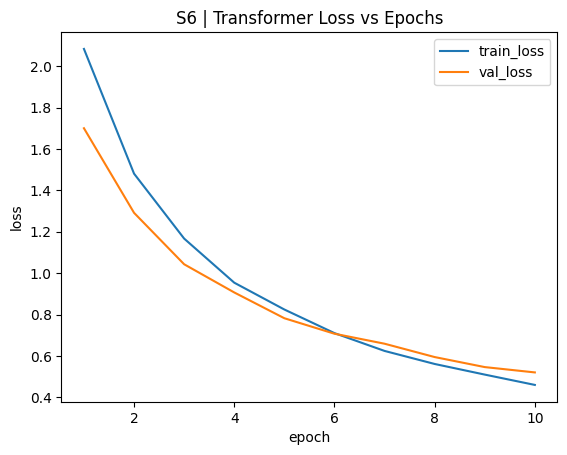

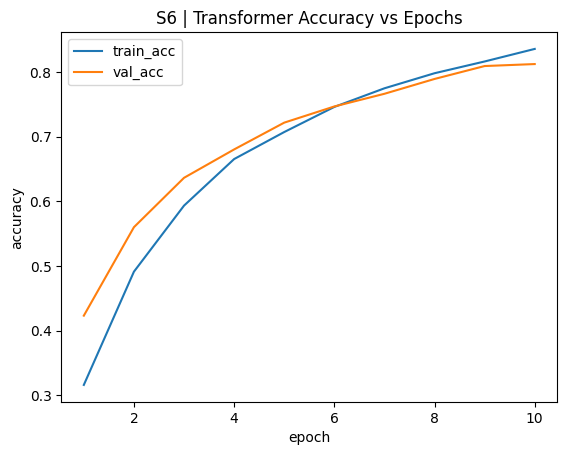


[TSMAE] Pretraining...


Pretrain epoch 1/10 | time=5.37s | loss=1.0240


Pretrain epoch 2/10 | time=4.49s | loss=1.0181


Pretrain epoch 3/10 | time=4.92s | loss=1.0180


Pretrain epoch 4/10 | time=5.20s | loss=1.0173


Pretrain epoch 5/10 | time=4.57s | loss=1.0143


Pretrain epoch 6/10 | time=5.22s | loss=1.0161


Pretrain epoch 7/10 | time=4.85s | loss=1.0226


Pretrain epoch 8/10 | time=4.45s | loss=1.0104


Pretrain epoch 9/10 | time=5.53s | loss=1.0156


Pretrain epoch 10/10 | time=4.55s | loss=1.0172
TSMAE pretrain total time (s): 49.151342153549194
[TSMAE] Fine-tuning...

--- TSMAE_finetune ---
Params total=892,681 | trainable=892,681 | size≈3.41 MB


Epoch 1/10 | time=4.70s | tr_loss=2.3984 tr_acc=0.2213 | va_loss=2.1823 va_acc=0.2839
Epoch 2/10 | time=5.48s | tr_loss=1.9775 tr_acc=0.3431 | va_loss=1.8012 va_acc=0.3938
Epoch 3/10 | time=4.62s | tr_loss=1.6514 tr_acc=0.4438 | va_loss=1.5658 va_acc=0.4665
Epoch 4/10 | time=4.93s | tr_loss=1.3588 tr_acc=0.5389 | va_loss=1.3034 va_acc=0.5546
Epoch 5/10 | time=5.17s | tr_loss=1.0997 tr_acc=0.6252 | va_loss=1.0899 va_acc=0.6350
Epoch 6/10 | time=4.57s | tr_loss=0.8782 tr_acc=0.7014 | va_loss=0.9856 va_acc=0.6698
Epoch 7/10 | time=5.41s | tr_loss=0.7118 tr_acc=0.7567 | va_loss=0.8185 va_acc=0.7242
Epoch 8/10 | time=4.70s | tr_loss=0.5910 tr_acc=0.7994 | va_loss=0.6863 va_acc=0.7780
Epoch 9/10 | time=4.61s | tr_loss=0.4867 tr_acc=0.8339 | va_loss=0.5814 va_acc=0.8078
Epoch 10/10 | time=5.39s | tr_loss=0.4123 tr_acc=0.8609 | va_loss=0.5424 va_acc=0.8244
TEST: acc=0.1528, precision=0.1848, recall=0.1834, f1=0.1646
Train time: per-epoch mean=4.96s | total=49.58s
Confusion matrix shape: (17, 1

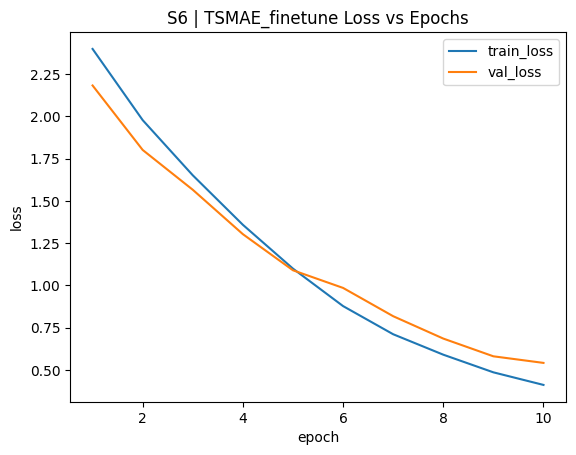

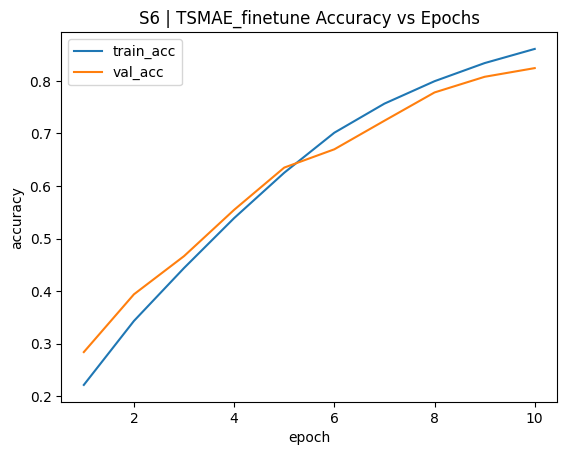


LOSO TEST SUBJECT: S7

--- CNN ---
Params total=232,273 | trainable=232,273 | size≈0.89 MB
Epoch 1/10 | time=2.64s | tr_loss=2.2441 tr_acc=0.2767 | va_loss=2.0584 va_acc=0.3272
Epoch 2/10 | time=2.56s | tr_loss=1.8851 tr_acc=0.3840 | va_loss=1.8874 va_acc=0.3754
Epoch 3/10 | time=2.88s | tr_loss=1.6704 tr_acc=0.4512 | va_loss=1.7315 va_acc=0.4346
Epoch 4/10 | time=3.19s | tr_loss=1.5165 tr_acc=0.5006 | va_loss=1.5842 va_acc=0.4701
Epoch 5/10 | time=2.55s | tr_loss=1.3742 tr_acc=0.5457 | va_loss=1.5839 va_acc=0.4702
Epoch 6/10 | time=2.57s | tr_loss=1.2764 tr_acc=0.5773 | va_loss=1.7327 va_acc=0.4294
Epoch 7/10 | time=2.55s | tr_loss=1.1883 tr_acc=0.6053 | va_loss=1.4099 va_acc=0.5283
Epoch 8/10 | time=3.09s | tr_loss=1.1020 tr_acc=0.6378 | va_loss=1.4455 va_acc=0.5146
Epoch 9/10 | time=2.97s | tr_loss=1.0475 tr_acc=0.6532 | va_loss=1.5091 va_acc=0.5141
Epoch 10/10 | time=2.56s | tr_loss=0.9837 tr_acc=0.6762 | va_loss=1.2558 va_acc=0.5793
TEST: acc=0.1016, precision=0.1449, recall=0.10

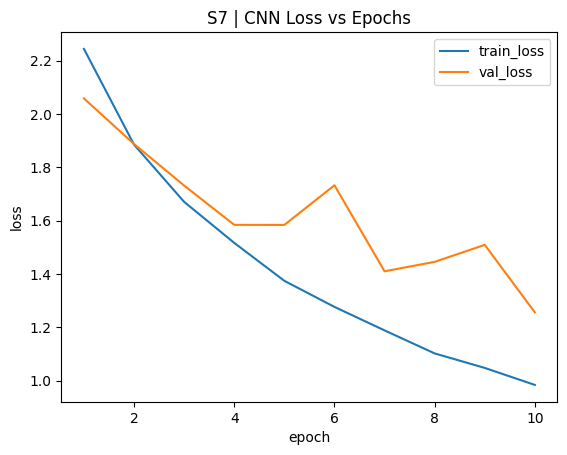

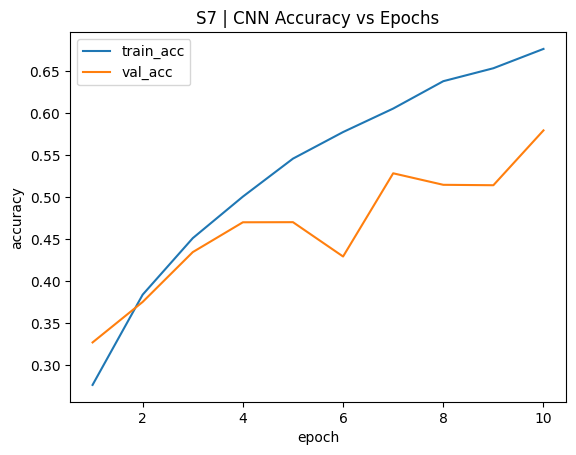


--- BiLSTM ---
Params total=545,041 | trainable=545,041 | size≈2.08 MB
Epoch 1/10 | time=12.15s | tr_loss=2.4762 tr_acc=0.1970 | va_loss=2.2820 va_acc=0.2609
Epoch 2/10 | time=12.17s | tr_loss=2.1500 tr_acc=0.2936 | va_loss=2.0415 va_acc=0.3209
Epoch 3/10 | time=12.17s | tr_loss=1.9146 tr_acc=0.3642 | va_loss=1.7885 va_acc=0.3988
Epoch 4/10 | time=12.15s | tr_loss=1.6969 tr_acc=0.4335 | va_loss=1.6288 va_acc=0.4528
Epoch 5/10 | time=12.26s | tr_loss=1.4818 tr_acc=0.5039 | va_loss=1.4508 va_acc=0.5072
Epoch 6/10 | time=12.30s | tr_loss=1.3172 tr_acc=0.5560 | va_loss=1.2797 va_acc=0.5686
Epoch 7/10 | time=12.37s | tr_loss=1.1676 tr_acc=0.6054 | va_loss=1.1654 va_acc=0.6053
Epoch 8/10 | time=12.36s | tr_loss=1.0465 tr_acc=0.6432 | va_loss=1.0388 va_acc=0.6478
Epoch 9/10 | time=12.22s | tr_loss=0.9392 tr_acc=0.6819 | va_loss=0.9489 va_acc=0.6759
Epoch 10/10 | time=12.19s | tr_loss=0.8402 tr_acc=0.7130 | va_loss=0.9330 va_acc=0.6795
TEST: acc=0.1113, precision=0.1183, recall=0.1222, f1=0.0

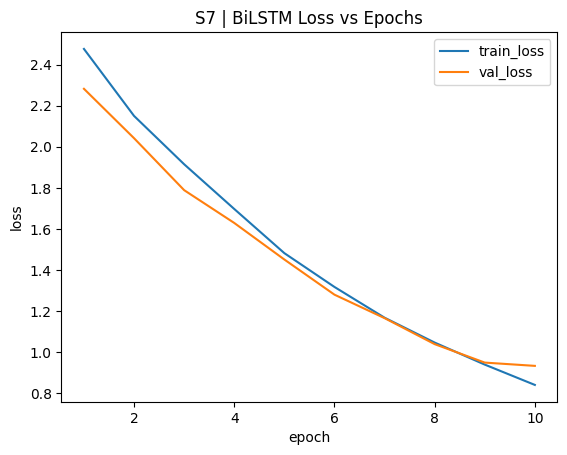

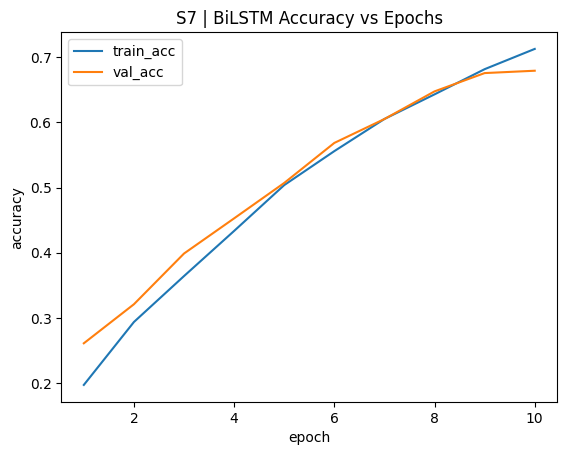


--- Transformer ---
Params total=797,201 | trainable=797,201 | size≈3.04 MB
Epoch 1/10 | time=22.96s | tr_loss=2.0685 tr_acc=0.3248 | va_loss=1.7473 va_acc=0.4128
Epoch 2/10 | time=22.86s | tr_loss=1.4895 tr_acc=0.4955 | va_loss=1.3456 va_acc=0.5439
Epoch 3/10 | time=22.89s | tr_loss=1.1654 tr_acc=0.5981 | va_loss=1.0969 va_acc=0.6173
Epoch 4/10 | time=22.88s | tr_loss=0.9678 tr_acc=0.6620 | va_loss=0.9314 va_acc=0.6743
Epoch 5/10 | time=22.91s | tr_loss=0.7993 tr_acc=0.7177 | va_loss=0.8019 va_acc=0.7209
Epoch 6/10 | time=22.89s | tr_loss=0.6901 tr_acc=0.7566 | va_loss=0.7158 va_acc=0.7432
Epoch 7/10 | time=22.89s | tr_loss=0.6007 tr_acc=0.7877 | va_loss=0.6372 va_acc=0.7739
Epoch 8/10 | time=22.89s | tr_loss=0.5348 tr_acc=0.8097 | va_loss=0.5795 va_acc=0.7945
Epoch 9/10 | time=22.94s | tr_loss=0.4845 tr_acc=0.8259 | va_loss=0.5369 va_acc=0.8110
Epoch 10/10 | time=22.91s | tr_loss=0.4330 tr_acc=0.8455 | va_loss=0.4886 va_acc=0.8195
TEST: acc=0.1335, precision=0.1729, recall=0.1408, f

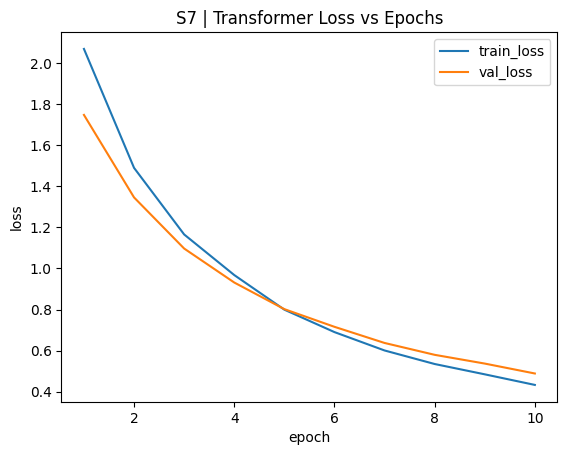

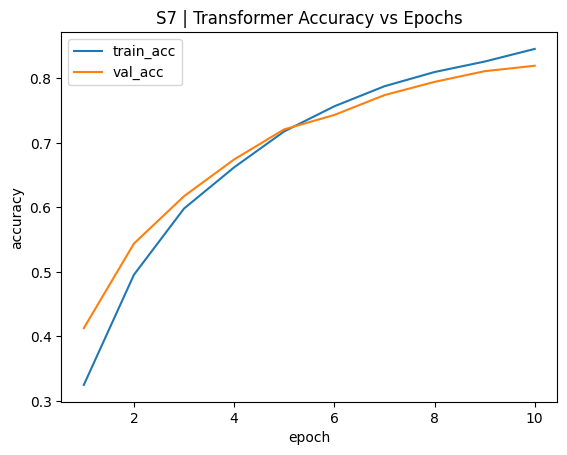


[TSMAE] Pretraining...


Pretrain epoch 1/10 | time=4.52s | loss=1.0127


Pretrain epoch 2/10 | time=5.65s | loss=1.0185


Pretrain epoch 3/10 | time=4.53s | loss=1.0159


Pretrain epoch 4/10 | time=4.57s | loss=1.0120


Pretrain epoch 5/10 | time=5.72s | loss=1.0243


Pretrain epoch 6/10 | time=4.49s | loss=1.0102


Pretrain epoch 7/10 | time=4.91s | loss=1.0244


Pretrain epoch 8/10 | time=5.41s | loss=1.0170


Pretrain epoch 9/10 | time=4.57s | loss=1.0208


Pretrain epoch 10/10 | time=5.39s | loss=1.0217
TSMAE pretrain total time (s): 49.749364376068115
[TSMAE] Fine-tuning...

--- TSMAE_finetune ---
Params total=892,681 | trainable=892,681 | size≈3.41 MB


Epoch 1/10 | time=4.91s | tr_loss=2.4114 tr_acc=0.2192 | va_loss=2.1327 va_acc=0.3117
Epoch 2/10 | time=4.55s | tr_loss=1.9831 tr_acc=0.3468 | va_loss=1.8339 va_acc=0.3941
Epoch 3/10 | time=5.50s | tr_loss=1.6494 tr_acc=0.4497 | va_loss=1.5486 va_acc=0.4748
Epoch 4/10 | time=4.56s | tr_loss=1.3450 tr_acc=0.5484 | va_loss=1.3172 va_acc=0.5486
Epoch 5/10 | time=4.58s | tr_loss=1.0700 tr_acc=0.6402 | va_loss=1.0795 va_acc=0.6333
Epoch 6/10 | time=5.49s | tr_loss=0.8399 tr_acc=0.7176 | va_loss=0.9395 va_acc=0.6860
Epoch 7/10 | time=4.62s | tr_loss=0.6757 tr_acc=0.7703 | va_loss=0.7875 va_acc=0.7417
Epoch 8/10 | time=5.18s | tr_loss=0.5471 tr_acc=0.8155 | va_loss=0.6795 va_acc=0.7774
Epoch 9/10 | time=4.93s | tr_loss=0.4415 tr_acc=0.8504 | va_loss=0.6043 va_acc=0.8083
Epoch 10/10 | time=4.53s | tr_loss=0.3802 tr_acc=0.8714 | va_loss=0.5356 va_acc=0.8292
TEST: acc=0.1089, precision=0.1595, recall=0.1129, f1=0.1050
Train time: per-epoch mean=4.88s | total=48.84s
Confusion matrix shape: (17, 1

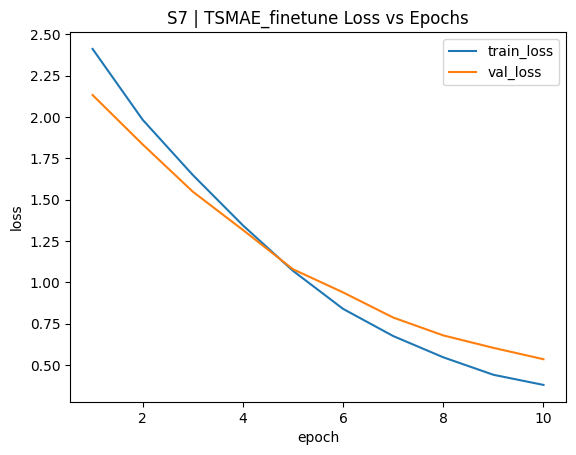

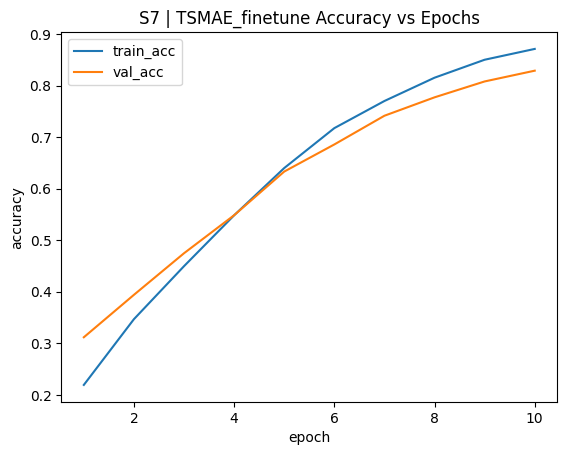


LOSO TEST SUBJECT: S8

--- CNN ---
Params total=232,273 | trainable=232,273 | size≈0.89 MB
Epoch 1/10 | time=3.55s | tr_loss=2.2450 tr_acc=0.2701 | va_loss=2.0550 va_acc=0.3224
Epoch 2/10 | time=2.67s | tr_loss=1.8908 tr_acc=0.3751 | va_loss=1.8378 va_acc=0.3963
Epoch 3/10 | time=2.65s | tr_loss=1.6747 tr_acc=0.4454 | va_loss=1.7932 va_acc=0.3982
Epoch 4/10 | time=2.70s | tr_loss=1.5194 tr_acc=0.4957 | va_loss=1.5986 va_acc=0.4571
Epoch 5/10 | time=3.07s | tr_loss=1.3935 tr_acc=0.5373 | va_loss=1.4818 va_acc=0.4933
Epoch 6/10 | time=3.17s | tr_loss=1.2908 tr_acc=0.5694 | va_loss=1.4013 va_acc=0.5226
Epoch 7/10 | time=2.65s | tr_loss=1.1992 tr_acc=0.6013 | va_loss=1.4129 va_acc=0.5215
Epoch 8/10 | time=2.68s | tr_loss=1.1235 tr_acc=0.6261 | va_loss=1.3249 va_acc=0.5459
Epoch 9/10 | time=2.67s | tr_loss=1.0475 tr_acc=0.6514 | va_loss=1.3363 va_acc=0.5497
Epoch 10/10 | time=3.33s | tr_loss=0.9927 tr_acc=0.6715 | va_loss=1.4381 va_acc=0.5151
TEST: acc=0.1351, precision=0.1635, recall=0.13

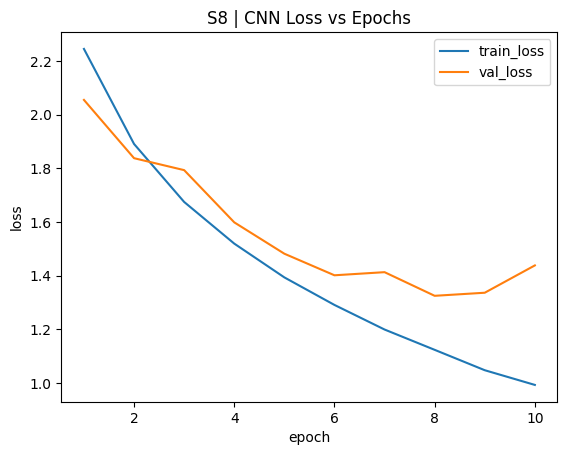

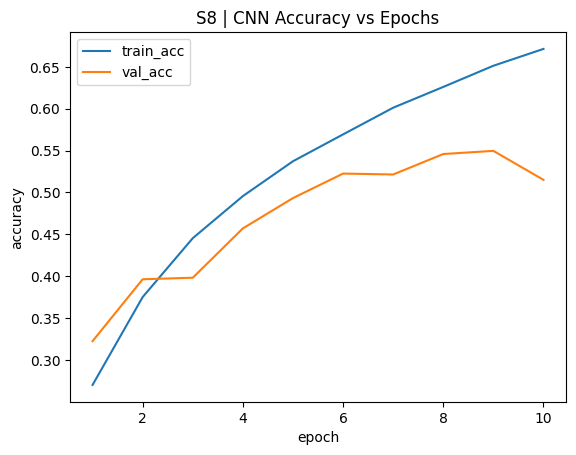


--- BiLSTM ---
Params total=545,041 | trainable=545,041 | size≈2.08 MB
Epoch 1/10 | time=12.73s | tr_loss=2.4586 tr_acc=0.2007 | va_loss=2.2432 va_acc=0.2678
Epoch 2/10 | time=12.70s | tr_loss=2.0957 tr_acc=0.3037 | va_loss=2.0036 va_acc=0.3397
Epoch 3/10 | time=12.70s | tr_loss=1.8624 tr_acc=0.3755 | va_loss=1.7817 va_acc=0.4005
Epoch 4/10 | time=12.71s | tr_loss=1.6613 tr_acc=0.4429 | va_loss=1.5966 va_acc=0.4625
Epoch 5/10 | time=12.69s | tr_loss=1.4808 tr_acc=0.5003 | va_loss=1.4438 va_acc=0.5039
Epoch 6/10 | time=12.61s | tr_loss=1.3240 tr_acc=0.5502 | va_loss=1.2859 va_acc=0.5598
Epoch 7/10 | time=12.58s | tr_loss=1.1823 tr_acc=0.5954 | va_loss=1.1742 va_acc=0.5992
Epoch 8/10 | time=12.54s | tr_loss=1.0665 tr_acc=0.6354 | va_loss=1.0562 va_acc=0.6419
Epoch 9/10 | time=12.49s | tr_loss=0.9437 tr_acc=0.6740 | va_loss=0.9794 va_acc=0.6666
Epoch 10/10 | time=12.51s | tr_loss=0.8372 tr_acc=0.7130 | va_loss=0.9073 va_acc=0.6863
TEST: acc=0.1391, precision=0.1980, recall=0.1332, f1=0.1

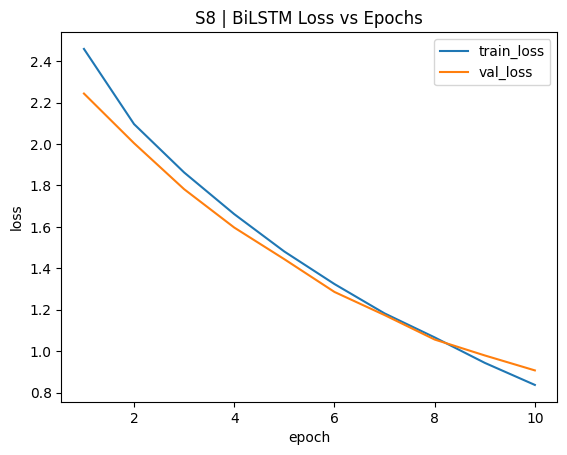

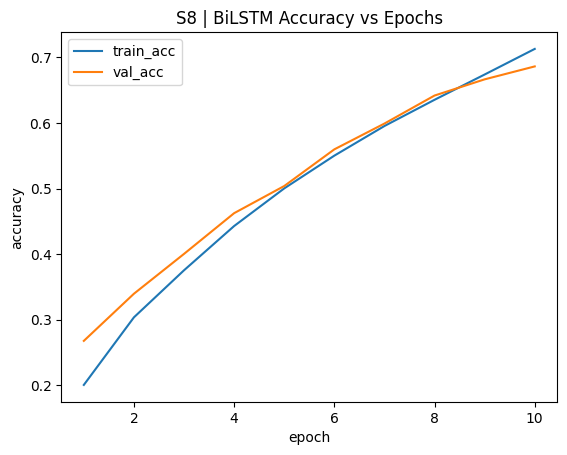


--- Transformer ---
Params total=797,201 | trainable=797,201 | size≈3.04 MB
Epoch 1/10 | time=23.58s | tr_loss=2.0549 tr_acc=0.3263 | va_loss=1.6755 va_acc=0.4435
Epoch 2/10 | time=23.51s | tr_loss=1.4828 tr_acc=0.4926 | va_loss=1.3184 va_acc=0.5458
Epoch 3/10 | time=23.50s | tr_loss=1.1598 tr_acc=0.5961 | va_loss=1.0883 va_acc=0.6217
Epoch 4/10 | time=23.59s | tr_loss=0.9521 tr_acc=0.6658 | va_loss=0.9014 va_acc=0.6851
Epoch 5/10 | time=23.51s | tr_loss=0.8124 tr_acc=0.7128 | va_loss=0.7984 va_acc=0.7178
Epoch 6/10 | time=23.53s | tr_loss=0.7008 tr_acc=0.7503 | va_loss=0.7264 va_acc=0.7503
Epoch 7/10 | time=23.51s | tr_loss=0.6222 tr_acc=0.7777 | va_loss=0.6533 va_acc=0.7702
Epoch 8/10 | time=23.53s | tr_loss=0.5468 tr_acc=0.8028 | va_loss=0.6096 va_acc=0.7808
Epoch 9/10 | time=23.62s | tr_loss=0.4944 tr_acc=0.8229 | va_loss=0.5561 va_acc=0.8038
Epoch 10/10 | time=23.56s | tr_loss=0.4469 tr_acc=0.8393 | va_loss=0.5475 va_acc=0.8091
TEST: acc=0.1541, precision=0.1653, recall=0.1550, f

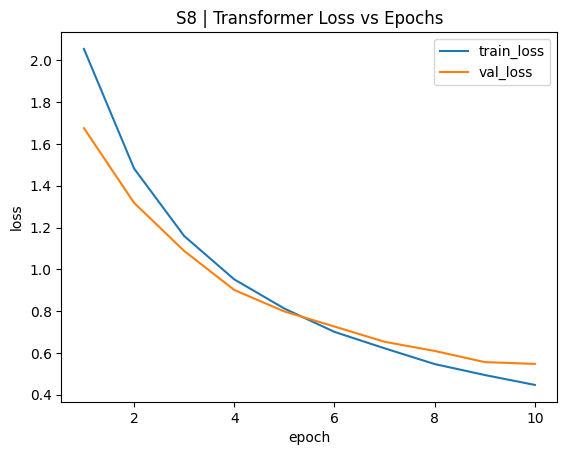

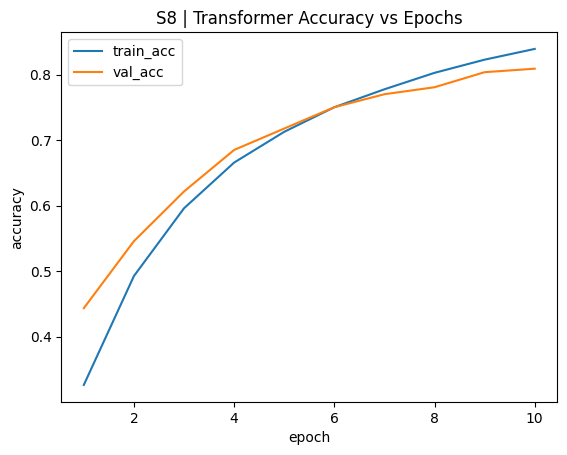


[TSMAE] Pretraining...


Pretrain epoch 1/10 | time=5.59s | loss=1.0160


Pretrain epoch 2/10 | time=4.66s | loss=1.0085


Pretrain epoch 3/10 | time=5.43s | loss=1.0079


Pretrain epoch 4/10 | time=5.38s | loss=1.0084


Pretrain epoch 5/10 | time=4.70s | loss=1.0104


Pretrain epoch 6/10 | time=5.56s | loss=1.0024


Pretrain epoch 7/10 | time=5.02s | loss=1.0006


Pretrain epoch 8/10 | time=4.66s | loss=1.0041


Pretrain epoch 9/10 | time=5.97s | loss=1.0133


Pretrain epoch 10/10 | time=4.65s | loss=1.0062
TSMAE pretrain total time (s): 51.620418071746826
[TSMAE] Fine-tuning...

--- TSMAE_finetune ---
Params total=892,681 | trainable=892,681 | size≈3.41 MB


Epoch 1/10 | time=4.77s | tr_loss=2.4016 tr_acc=0.2180 | va_loss=2.1778 va_acc=0.2817
Epoch 2/10 | time=5.53s | tr_loss=1.9850 tr_acc=0.3422 | va_loss=1.8321 va_acc=0.3901
Epoch 3/10 | time=4.71s | tr_loss=1.6803 tr_acc=0.4389 | va_loss=1.6033 va_acc=0.4636
Epoch 4/10 | time=5.34s | tr_loss=1.3916 tr_acc=0.5323 | va_loss=1.3508 va_acc=0.5467
Epoch 5/10 | time=5.04s | tr_loss=1.1253 tr_acc=0.6197 | va_loss=1.1346 va_acc=0.6181
Epoch 6/10 | time=4.69s | tr_loss=0.9083 tr_acc=0.6911 | va_loss=0.9630 va_acc=0.6771
Epoch 7/10 | time=5.56s | tr_loss=0.7237 tr_acc=0.7557 | va_loss=0.8360 va_acc=0.7218
Epoch 8/10 | time=4.68s | tr_loss=0.5990 tr_acc=0.7979 | va_loss=0.7276 va_acc=0.7663
Epoch 9/10 | time=5.02s | tr_loss=0.4976 tr_acc=0.8315 | va_loss=0.6168 va_acc=0.8015
Epoch 10/10 | time=5.33s | tr_loss=0.4179 tr_acc=0.8600 | va_loss=0.5507 va_acc=0.8252
TEST: acc=0.1532, precision=0.1473, recall=0.1503, f1=0.1374
Train time: per-epoch mean=5.07s | total=50.66s
Confusion matrix shape: (17, 1

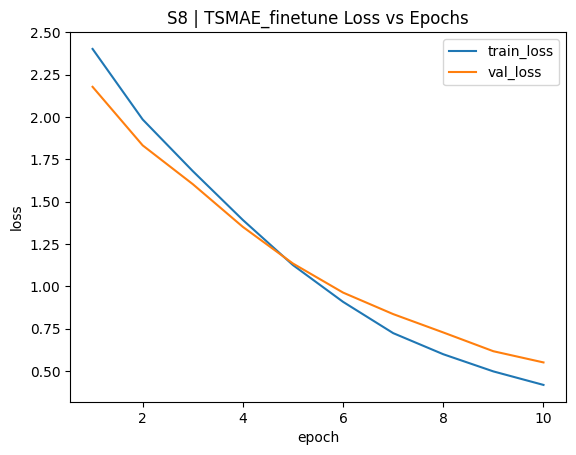

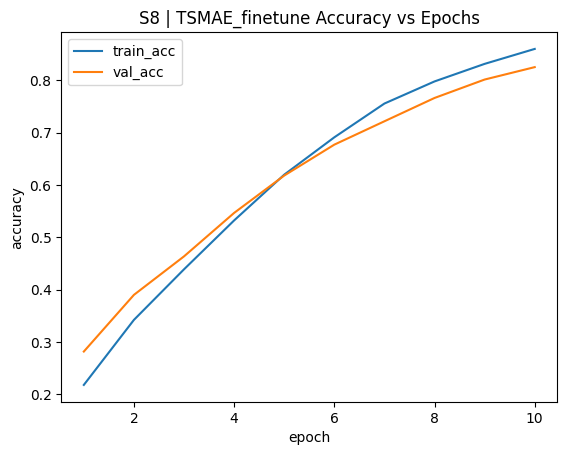


LOSO TEST SUBJECT: S9

--- CNN ---
Params total=232,273 | trainable=232,273 | size≈0.89 MB
Epoch 1/10 | time=2.83s | tr_loss=2.2717 tr_acc=0.2614 | va_loss=2.1352 va_acc=0.2971
Epoch 2/10 | time=2.84s | tr_loss=1.9270 tr_acc=0.3647 | va_loss=1.8930 va_acc=0.3785
Epoch 3/10 | time=3.29s | tr_loss=1.7136 tr_acc=0.4328 | va_loss=1.7415 va_acc=0.4116
Epoch 4/10 | time=2.65s | tr_loss=1.5522 tr_acc=0.4861 | va_loss=1.5836 va_acc=0.4692
Epoch 5/10 | time=2.65s | tr_loss=1.4233 tr_acc=0.5286 | va_loss=1.5165 va_acc=0.4934
Epoch 6/10 | time=2.65s | tr_loss=1.3102 tr_acc=0.5648 | va_loss=1.5056 va_acc=0.5002
Epoch 7/10 | time=3.09s | tr_loss=1.2332 tr_acc=0.5921 | va_loss=1.4213 va_acc=0.5211
Epoch 8/10 | time=3.06s | tr_loss=1.1472 tr_acc=0.6188 | va_loss=1.4899 va_acc=0.5011
Epoch 9/10 | time=2.65s | tr_loss=1.0849 tr_acc=0.6417 | va_loss=1.3107 va_acc=0.5618
Epoch 10/10 | time=2.65s | tr_loss=1.0160 tr_acc=0.6672 | va_loss=1.3494 va_acc=0.5613
TEST: acc=0.3247, precision=0.3166, recall=0.35

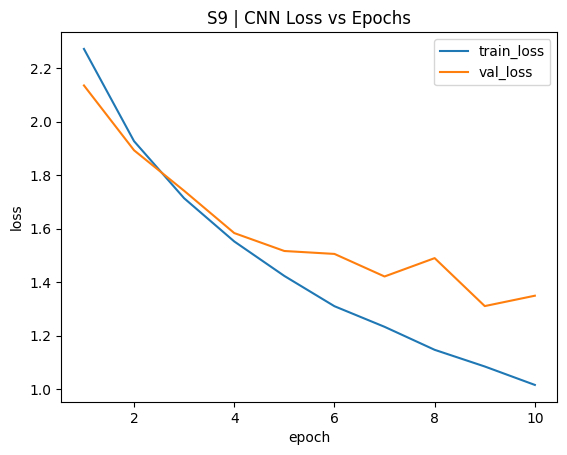

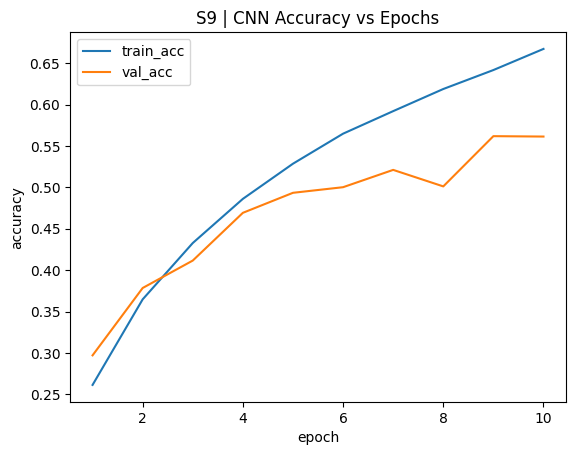


--- BiLSTM ---
Params total=545,041 | trainable=545,041 | size≈2.08 MB
Epoch 1/10 | time=12.89s | tr_loss=2.5046 tr_acc=0.1862 | va_loss=2.2788 va_acc=0.2571
Epoch 2/10 | time=12.88s | tr_loss=2.1630 tr_acc=0.2848 | va_loss=2.0874 va_acc=0.3092
Epoch 3/10 | time=12.83s | tr_loss=1.9470 tr_acc=0.3482 | va_loss=1.8576 va_acc=0.3737
Epoch 4/10 | time=12.86s | tr_loss=1.7336 tr_acc=0.4137 | va_loss=1.6629 va_acc=0.4425
Epoch 5/10 | time=12.86s | tr_loss=1.5456 tr_acc=0.4748 | va_loss=1.5081 va_acc=0.4870
Epoch 6/10 | time=12.86s | tr_loss=1.3809 tr_acc=0.5305 | va_loss=1.3279 va_acc=0.5441
Epoch 7/10 | time=12.85s | tr_loss=1.2264 tr_acc=0.5834 | va_loss=1.2129 va_acc=0.5882
Epoch 8/10 | time=12.86s | tr_loss=1.0925 tr_acc=0.6270 | va_loss=1.1087 va_acc=0.6180
Epoch 9/10 | time=12.87s | tr_loss=0.9679 tr_acc=0.6697 | va_loss=1.0209 va_acc=0.6481
Epoch 10/10 | time=12.85s | tr_loss=0.8839 tr_acc=0.6969 | va_loss=0.9151 va_acc=0.6802
TEST: acc=0.2926, precision=0.2493, recall=0.3234, f1=0.2

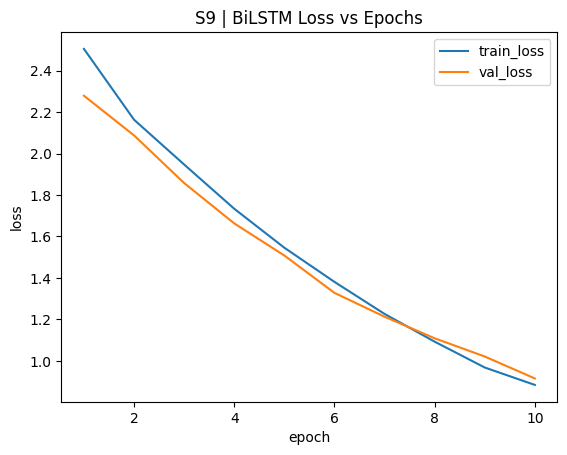

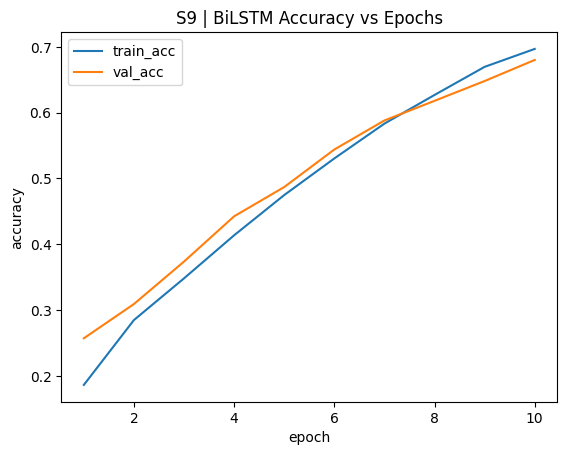


--- Transformer ---
Params total=797,201 | trainable=797,201 | size≈3.04 MB
Epoch 1/10 | time=23.86s | tr_loss=2.0776 tr_acc=0.3160 | va_loss=1.7155 va_acc=0.4194
Epoch 2/10 | time=23.82s | tr_loss=1.4965 tr_acc=0.4887 | va_loss=1.3479 va_acc=0.5339
Epoch 3/10 | time=24.22s | tr_loss=1.1754 tr_acc=0.5923 | va_loss=1.1194 va_acc=0.6119
Epoch 4/10 | time=23.84s | tr_loss=0.9604 tr_acc=0.6613 | va_loss=0.9003 va_acc=0.6828
Epoch 5/10 | time=23.82s | tr_loss=0.8095 tr_acc=0.7122 | va_loss=0.7841 va_acc=0.7217
Epoch 6/10 | time=23.86s | tr_loss=0.7076 tr_acc=0.7456 | va_loss=0.7191 va_acc=0.7498
Epoch 7/10 | time=23.86s | tr_loss=0.6262 tr_acc=0.7763 | va_loss=0.6387 va_acc=0.7800
Epoch 8/10 | time=24.26s | tr_loss=0.5545 tr_acc=0.8012 | va_loss=0.6190 va_acc=0.7778
Epoch 9/10 | time=24.03s | tr_loss=0.5014 tr_acc=0.8210 | va_loss=0.5579 va_acc=0.8072
Epoch 10/10 | time=23.98s | tr_loss=0.4498 tr_acc=0.8394 | va_loss=0.5327 va_acc=0.8154
TEST: acc=0.2254, precision=0.2186, recall=0.2500, f

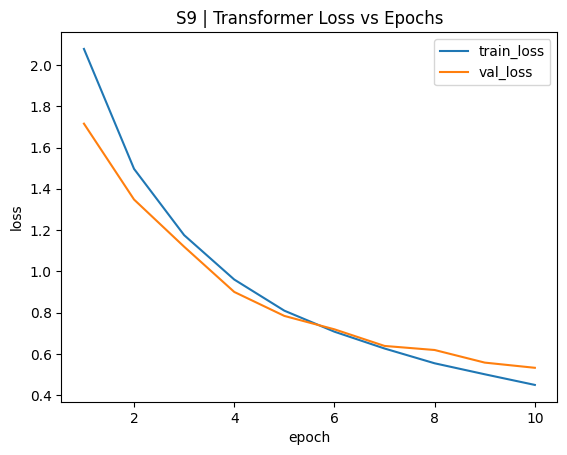

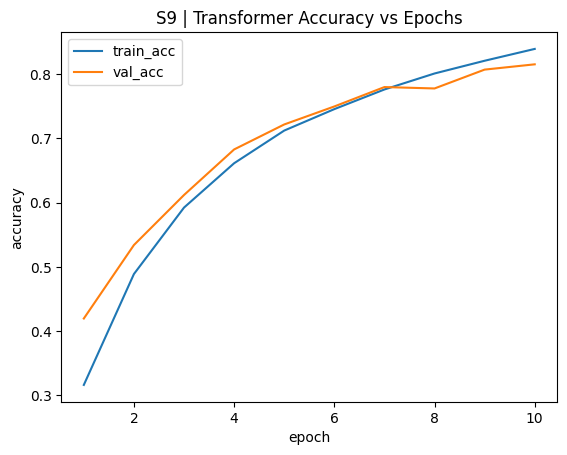


[TSMAE] Pretraining...


Pretrain epoch 1/10 | time=5.51s | loss=1.0179


Pretrain epoch 2/10 | time=4.76s | loss=1.0189


Pretrain epoch 3/10 | time=5.80s | loss=1.0140


Pretrain epoch 4/10 | time=5.09s | loss=1.0145


Pretrain epoch 5/10 | time=4.92s | loss=1.0212


Pretrain epoch 6/10 | time=6.17s | loss=1.0147


Pretrain epoch 7/10 | time=4.80s | loss=1.0093


Pretrain epoch 8/10 | time=5.03s | loss=1.0185


Pretrain epoch 9/10 | time=5.72s | loss=1.0108


Pretrain epoch 10/10 | time=4.78s | loss=1.0148
TSMAE pretrain total time (s): 52.58657264709473
[TSMAE] Fine-tuning...

--- TSMAE_finetune ---
Params total=892,681 | trainable=892,681 | size≈3.41 MB


Epoch 1/10 | time=6.80s | tr_loss=2.4242 tr_acc=0.2094 | va_loss=2.1539 va_acc=0.2946
Epoch 2/10 | time=5.86s | tr_loss=2.0167 tr_acc=0.3323 | va_loss=1.8731 va_acc=0.3760
Epoch 3/10 | time=6.60s | tr_loss=1.7180 tr_acc=0.4260 | va_loss=1.6098 va_acc=0.4529
Epoch 4/10 | time=5.67s | tr_loss=1.4268 tr_acc=0.5211 | va_loss=1.3611 va_acc=0.5421
Epoch 5/10 | time=4.74s | tr_loss=1.1518 tr_acc=0.6126 | va_loss=1.1570 va_acc=0.6111
Epoch 6/10 | time=5.69s | tr_loss=0.9418 tr_acc=0.6807 | va_loss=1.0119 va_acc=0.6619
Epoch 7/10 | time=4.77s | tr_loss=0.7437 tr_acc=0.7490 | va_loss=0.8335 va_acc=0.7242
Epoch 8/10 | time=5.55s | tr_loss=0.6021 tr_acc=0.7963 | va_loss=0.7305 va_acc=0.7654
Epoch 9/10 | time=4.90s | tr_loss=0.4933 tr_acc=0.8329 | va_loss=0.6162 va_acc=0.8008
Epoch 10/10 | time=4.72s | tr_loss=0.4247 tr_acc=0.8580 | va_loss=0.5859 va_acc=0.8151
TEST: acc=0.2748, precision=0.2561, recall=0.3043, f1=0.2498
Train time: per-epoch mean=5.53s | total=55.30s
Confusion matrix shape: (17, 1

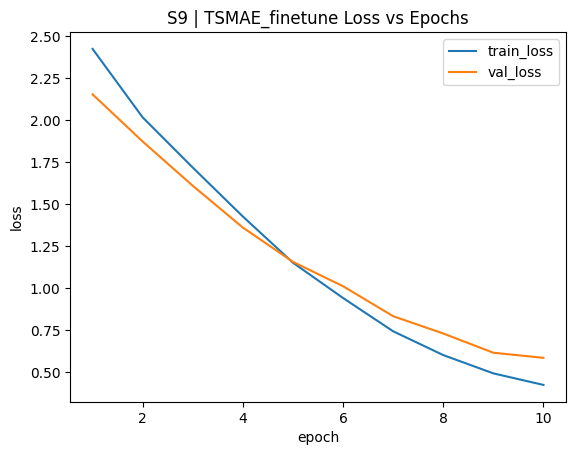

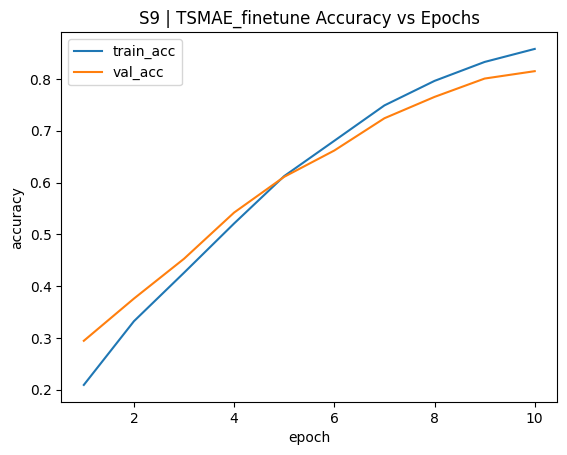


LOSO TEST SUBJECT: S10

--- CNN ---
Params total=232,273 | trainable=232,273 | size≈0.89 MB
Epoch 1/10 | time=3.31s | tr_loss=2.2694 tr_acc=0.2657 | va_loss=2.1053 va_acc=0.3012
Epoch 2/10 | time=2.67s | tr_loss=1.9321 tr_acc=0.3638 | va_loss=1.9759 va_acc=0.3433
Epoch 3/10 | time=2.74s | tr_loss=1.7234 tr_acc=0.4306 | va_loss=1.7010 va_acc=0.4308
Epoch 4/10 | time=2.68s | tr_loss=1.5682 tr_acc=0.4811 | va_loss=1.5898 va_acc=0.4673
Epoch 5/10 | time=3.41s | tr_loss=1.4349 tr_acc=0.5234 | va_loss=1.4605 va_acc=0.5036
Epoch 6/10 | time=2.89s | tr_loss=1.3366 tr_acc=0.5570 | va_loss=1.5620 va_acc=0.4747
Epoch 7/10 | time=2.70s | tr_loss=1.2416 tr_acc=0.5889 | va_loss=1.4547 va_acc=0.5121
Epoch 8/10 | time=2.66s | tr_loss=1.1663 tr_acc=0.6141 | va_loss=1.3388 va_acc=0.5487
Epoch 9/10 | time=2.87s | tr_loss=1.0994 tr_acc=0.6357 | va_loss=1.4774 va_acc=0.5078
Epoch 10/10 | time=3.39s | tr_loss=1.0258 tr_acc=0.6603 | va_loss=1.3041 va_acc=0.5531
TEST: acc=0.2597, precision=0.2609, recall=0.2

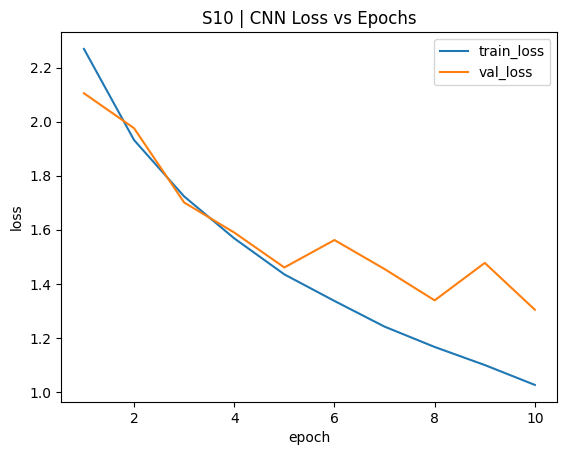

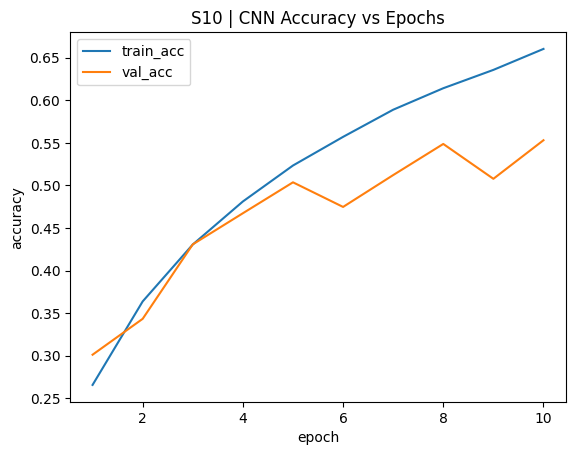


--- BiLSTM ---
Params total=545,041 | trainable=545,041 | size≈2.08 MB
Epoch 1/10 | time=12.56s | tr_loss=2.4955 tr_acc=0.1907 | va_loss=2.2633 va_acc=0.2537
Epoch 2/10 | time=12.59s | tr_loss=2.1185 tr_acc=0.2958 | va_loss=2.0007 va_acc=0.3292
Epoch 3/10 | time=12.65s | tr_loss=1.8800 tr_acc=0.3711 | va_loss=1.7692 va_acc=0.4070
Epoch 4/10 | time=12.69s | tr_loss=1.6728 tr_acc=0.4363 | va_loss=1.5877 va_acc=0.4599
Epoch 5/10 | time=12.67s | tr_loss=1.5054 tr_acc=0.4919 | va_loss=1.4226 va_acc=0.5106
Epoch 6/10 | time=12.69s | tr_loss=1.3236 tr_acc=0.5519 | va_loss=1.2933 va_acc=0.5589
Epoch 7/10 | time=12.66s | tr_loss=1.1838 tr_acc=0.5963 | va_loss=1.1585 va_acc=0.6066
Epoch 8/10 | time=12.62s | tr_loss=1.0529 tr_acc=0.6396 | va_loss=1.0455 va_acc=0.6336
Epoch 9/10 | time=12.49s | tr_loss=0.9403 tr_acc=0.6773 | va_loss=0.9559 va_acc=0.6704
Epoch 10/10 | time=12.47s | tr_loss=0.8526 tr_acc=0.7066 | va_loss=0.8772 va_acc=0.6925
TEST: acc=0.2176, precision=0.2544, recall=0.2312, f1=0.2

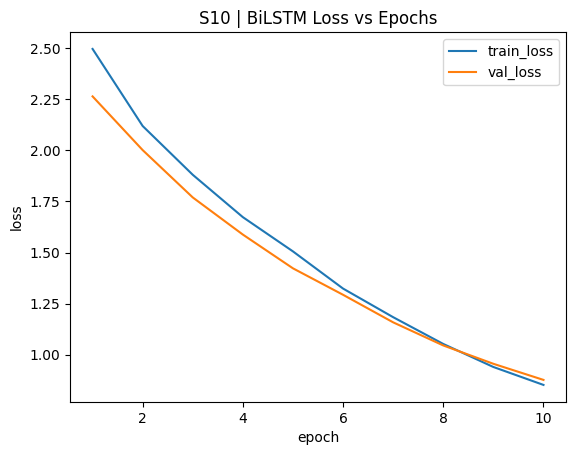

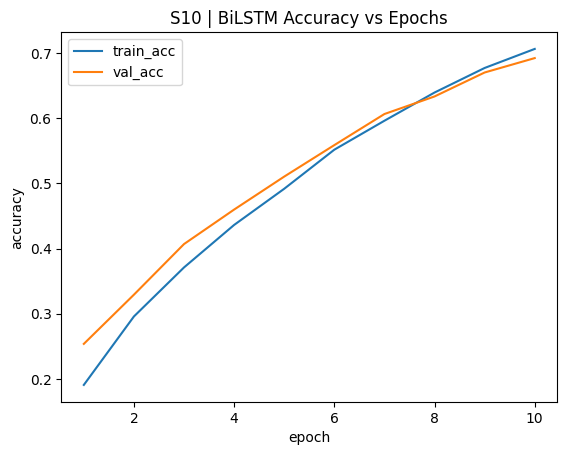


--- Transformer ---
Params total=797,201 | trainable=797,201 | size≈3.04 MB
Epoch 1/10 | time=23.53s | tr_loss=2.0838 tr_acc=0.3181 | va_loss=1.6824 va_acc=0.4368
Epoch 2/10 | time=23.54s | tr_loss=1.4861 tr_acc=0.4968 | va_loss=1.2761 va_acc=0.5555
Epoch 3/10 | time=23.50s | tr_loss=1.1617 tr_acc=0.5983 | va_loss=1.0721 va_acc=0.6347
Epoch 4/10 | time=23.56s | tr_loss=0.9557 tr_acc=0.6669 | va_loss=0.9118 va_acc=0.6818
Epoch 5/10 | time=23.51s | tr_loss=0.8061 tr_acc=0.7159 | va_loss=0.7880 va_acc=0.7198
Epoch 6/10 | time=23.50s | tr_loss=0.6952 tr_acc=0.7545 | va_loss=0.7178 va_acc=0.7457
Epoch 7/10 | time=23.52s | tr_loss=0.6128 tr_acc=0.7813 | va_loss=0.6914 va_acc=0.7649
Epoch 8/10 | time=23.47s | tr_loss=0.5474 tr_acc=0.8036 | va_loss=0.5865 va_acc=0.7917
Epoch 9/10 | time=23.59s | tr_loss=0.4856 tr_acc=0.8264 | va_loss=0.5400 va_acc=0.8081
Epoch 10/10 | time=23.55s | tr_loss=0.4460 tr_acc=0.8401 | va_loss=0.4998 va_acc=0.8194
TEST: acc=0.2080, precision=0.2258, recall=0.2294, f

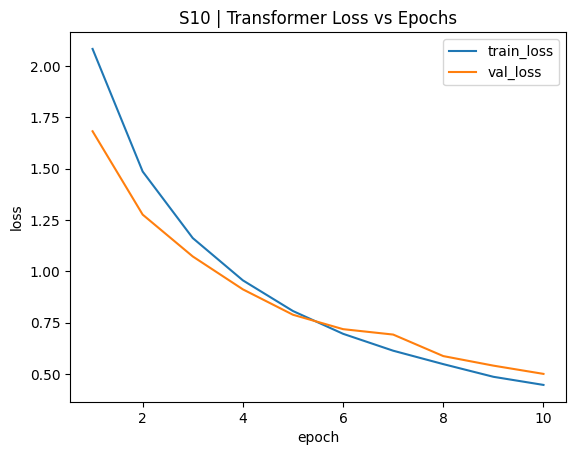

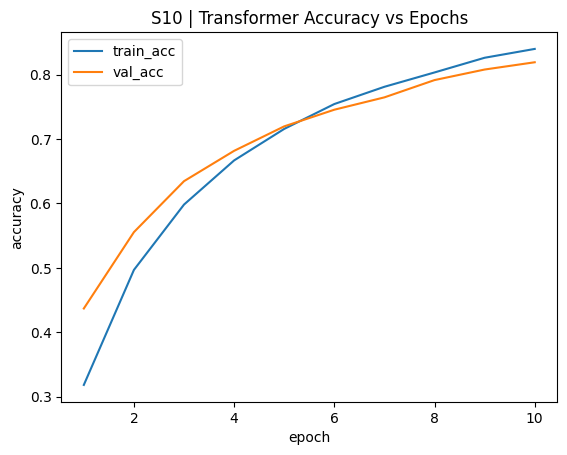


[TSMAE] Pretraining...


Pretrain epoch 1/10 | time=6.00s | loss=1.0129


Pretrain epoch 2/10 | time=4.89s | loss=1.0139


Pretrain epoch 3/10 | time=5.82s | loss=1.0172


Pretrain epoch 4/10 | time=5.32s | loss=1.0078


Pretrain epoch 5/10 | time=4.87s | loss=1.0124


Pretrain epoch 6/10 | time=6.30s | loss=1.0047


Pretrain epoch 7/10 | time=4.94s | loss=1.0085


Pretrain epoch 8/10 | time=5.06s | loss=1.0106


Pretrain epoch 9/10 | time=5.87s | loss=1.0095


Pretrain epoch 10/10 | time=4.84s | loss=1.0097
TSMAE pretrain total time (s): 53.905109167099
[TSMAE] Fine-tuning...

--- TSMAE_finetune ---
Params total=892,681 | trainable=892,681 | size≈3.41 MB


Epoch 1/10 | time=5.49s | tr_loss=2.4207 tr_acc=0.2151 | va_loss=2.1803 va_acc=0.2819
Epoch 2/10 | time=4.91s | tr_loss=2.0242 tr_acc=0.3330 | va_loss=1.8824 va_acc=0.3778
Epoch 3/10 | time=4.73s | tr_loss=1.7228 tr_acc=0.4275 | va_loss=1.6290 va_acc=0.4474
Epoch 4/10 | time=5.55s | tr_loss=1.4229 tr_acc=0.5248 | va_loss=1.3494 va_acc=0.5444
Epoch 5/10 | time=4.63s | tr_loss=1.1542 tr_acc=0.6114 | va_loss=1.1499 va_acc=0.6163
Epoch 6/10 | time=4.98s | tr_loss=0.9200 tr_acc=0.6899 | va_loss=0.9784 va_acc=0.6710
Epoch 7/10 | time=5.34s | tr_loss=0.7390 tr_acc=0.7511 | va_loss=0.7966 va_acc=0.7349
Epoch 8/10 | time=4.72s | tr_loss=0.5981 tr_acc=0.7968 | va_loss=0.6905 va_acc=0.7782
Epoch 9/10 | time=5.82s | tr_loss=0.4968 tr_acc=0.8319 | va_loss=0.5993 va_acc=0.8084
Epoch 10/10 | time=4.68s | tr_loss=0.4237 tr_acc=0.8580 | va_loss=0.5628 va_acc=0.8206
TEST: acc=0.2397, precision=0.2361, recall=0.2466, f1=0.2265
Train time: per-epoch mean=5.09s | total=50.85s
Confusion matrix shape: (17, 1

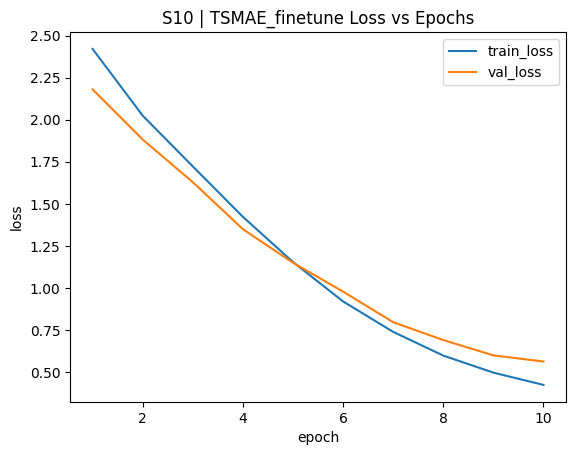

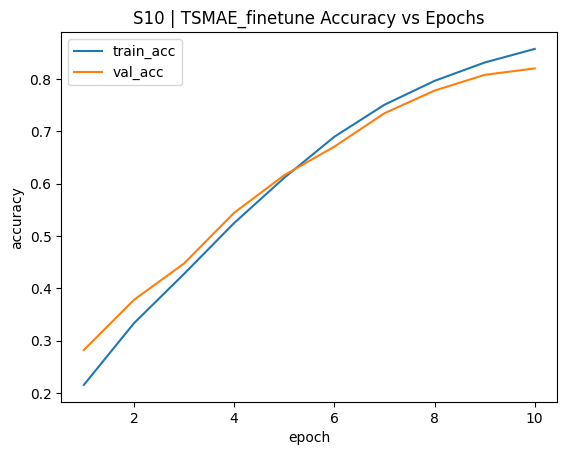


LOSO TEST SUBJECT: S11

--- CNN ---
Params total=232,273 | trainable=232,273 | size≈0.89 MB
Epoch 1/10 | time=2.66s | tr_loss=2.2309 tr_acc=0.2764 | va_loss=2.1006 va_acc=0.3095
Epoch 2/10 | time=3.21s | tr_loss=1.8841 tr_acc=0.3806 | va_loss=1.9171 va_acc=0.3650
Epoch 3/10 | time=2.87s | tr_loss=1.6843 tr_acc=0.4426 | va_loss=1.7963 va_acc=0.4009
Epoch 4/10 | time=2.58s | tr_loss=1.5243 tr_acc=0.4961 | va_loss=1.7827 va_acc=0.3970
Epoch 5/10 | time=2.60s | tr_loss=1.3996 tr_acc=0.5382 | va_loss=1.8914 va_acc=0.3977
Epoch 6/10 | time=2.56s | tr_loss=1.2838 tr_acc=0.5779 | va_loss=1.4402 va_acc=0.5115
Epoch 7/10 | time=3.36s | tr_loss=1.1982 tr_acc=0.6057 | va_loss=1.5157 va_acc=0.4921
Epoch 8/10 | time=2.71s | tr_loss=1.1041 tr_acc=0.6366 | va_loss=1.3440 va_acc=0.5420
Epoch 9/10 | time=2.56s | tr_loss=1.0465 tr_acc=0.6562 | va_loss=1.3427 va_acc=0.5523
Epoch 10/10 | time=2.58s | tr_loss=0.9737 tr_acc=0.6778 | va_loss=1.2663 va_acc=0.5630
TEST: acc=0.1827, precision=0.3063, recall=0.1

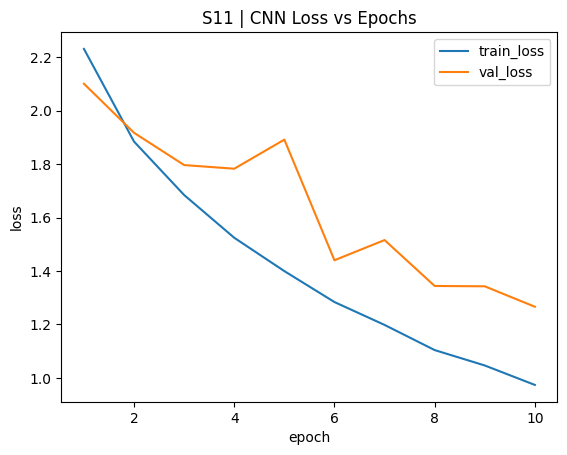

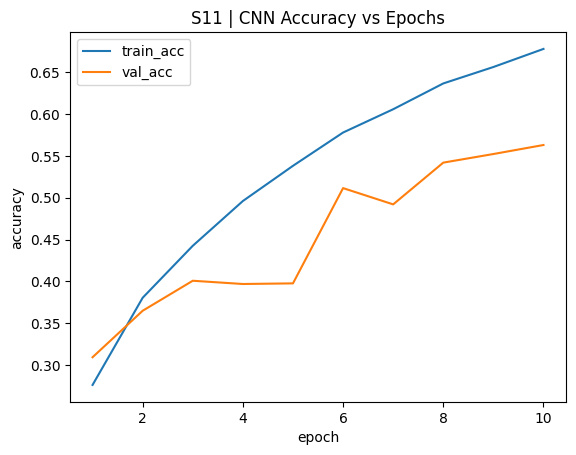


--- BiLSTM ---
Params total=545,041 | trainable=545,041 | size≈2.08 MB
Epoch 1/10 | time=12.11s | tr_loss=2.4762 tr_acc=0.1943 | va_loss=2.2906 va_acc=0.2515
Epoch 2/10 | time=12.14s | tr_loss=2.1452 tr_acc=0.2897 | va_loss=2.0791 va_acc=0.3098
Epoch 3/10 | time=12.08s | tr_loss=1.9308 tr_acc=0.3530 | va_loss=1.8443 va_acc=0.3776
Epoch 4/10 | time=12.09s | tr_loss=1.6997 tr_acc=0.4268 | va_loss=1.6089 va_acc=0.4629
Epoch 5/10 | time=12.09s | tr_loss=1.5187 tr_acc=0.4879 | va_loss=1.4937 va_acc=0.4967
Epoch 6/10 | time=12.15s | tr_loss=1.3395 tr_acc=0.5450 | va_loss=1.3169 va_acc=0.5573
Epoch 7/10 | time=12.17s | tr_loss=1.1848 tr_acc=0.5967 | va_loss=1.1605 va_acc=0.6038
Epoch 8/10 | time=12.26s | tr_loss=1.0436 tr_acc=0.6443 | va_loss=1.0648 va_acc=0.6307
Epoch 9/10 | time=12.29s | tr_loss=0.9371 tr_acc=0.6820 | va_loss=0.9666 va_acc=0.6695
Epoch 10/10 | time=12.30s | tr_loss=0.8263 tr_acc=0.7173 | va_loss=0.9103 va_acc=0.6847
TEST: acc=0.2038, precision=0.2665, recall=0.2037, f1=0.1

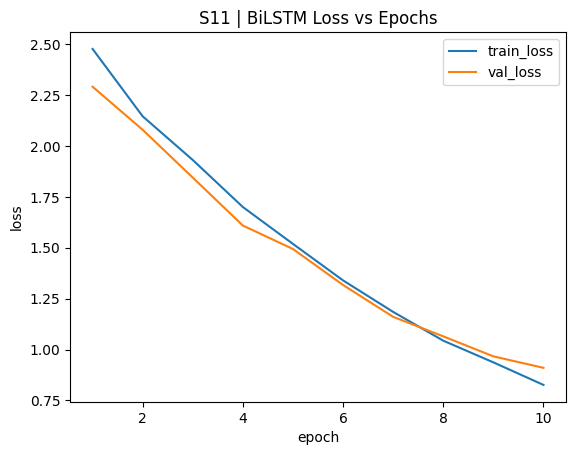

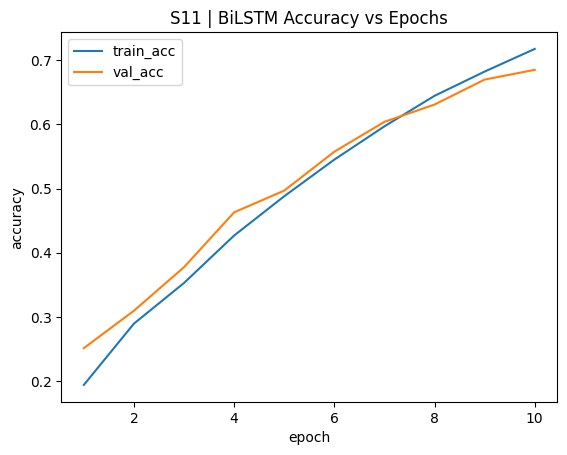


--- Transformer ---
Params total=797,201 | trainable=797,201 | size≈3.04 MB
Epoch 1/10 | time=22.92s | tr_loss=2.0565 tr_acc=0.3229 | va_loss=1.6875 va_acc=0.4311
Epoch 2/10 | time=22.83s | tr_loss=1.4710 tr_acc=0.5005 | va_loss=1.3095 va_acc=0.5530
Epoch 3/10 | time=22.78s | tr_loss=1.1526 tr_acc=0.6009 | va_loss=1.0863 va_acc=0.6251
Epoch 4/10 | time=22.84s | tr_loss=0.9442 tr_acc=0.6672 | va_loss=0.8625 va_acc=0.7029
Epoch 5/10 | time=22.74s | tr_loss=0.8036 tr_acc=0.7150 | va_loss=0.7869 va_acc=0.7243
Epoch 6/10 | time=22.75s | tr_loss=0.6932 tr_acc=0.7518 | va_loss=0.6902 va_acc=0.7591
Epoch 7/10 | time=22.75s | tr_loss=0.6086 tr_acc=0.7820 | va_loss=0.6155 va_acc=0.7827
Epoch 8/10 | time=22.86s | tr_loss=0.5425 tr_acc=0.8065 | va_loss=0.5781 va_acc=0.7979
Epoch 9/10 | time=22.83s | tr_loss=0.4826 tr_acc=0.8267 | va_loss=0.5574 va_acc=0.8058
Epoch 10/10 | time=22.75s | tr_loss=0.4300 tr_acc=0.8444 | va_loss=0.5658 va_acc=0.7957
TEST: acc=0.2078, precision=0.2944, recall=0.2078, f

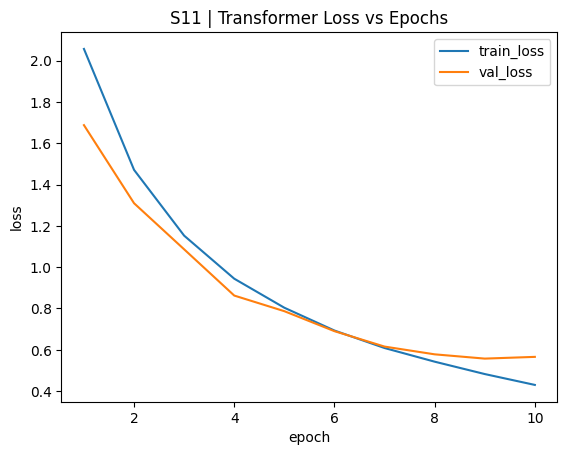

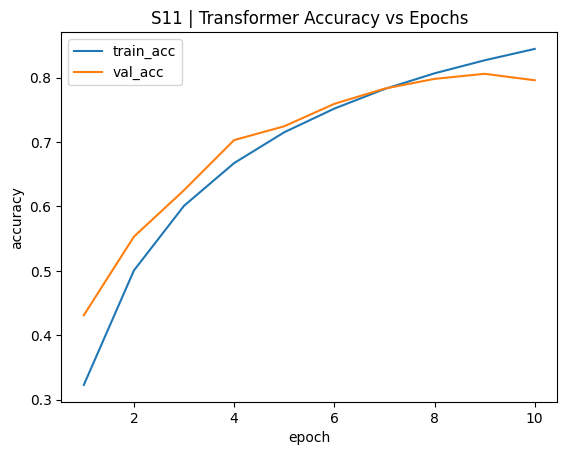


[TSMAE] Pretraining...


Pretrain epoch 1/10 | time=5.14s | loss=1.0175


Pretrain epoch 2/10 | time=6.24s | loss=1.0212


Pretrain epoch 3/10 | time=4.91s | loss=1.0106


Pretrain epoch 4/10 | time=5.33s | loss=1.0042


Pretrain epoch 5/10 | time=5.51s | loss=1.0058


Pretrain epoch 6/10 | time=4.80s | loss=1.0178


Pretrain epoch 7/10 | time=5.82s | loss=1.0151


Pretrain epoch 8/10 | time=5.39s | loss=1.0140


Pretrain epoch 9/10 | time=4.92s | loss=1.0149


Pretrain epoch 10/10 | time=6.16s | loss=1.0190
TSMAE pretrain total time (s): 54.21834659576416
[TSMAE] Fine-tuning...

--- TSMAE_finetune ---
Params total=892,681 | trainable=892,681 | size≈3.41 MB
Epoch 1/10 | time=4.63s | tr_loss=2.3945 tr_acc=0.2236 | va_loss=2.1315 va_acc=0.2985
Epoch 2/10 | time=4.61s | tr_loss=1.9845 tr_acc=0.3446 | va_loss=1.8409 va_acc=0.3846
Epoch 3/10 | time=5.60s | tr_loss=1.6729 tr_acc=0.4420 | va_loss=1.5918 va_acc=0.4672
Epoch 4/10 | time=4.63s | tr_loss=1.3790 tr_acc=0.5373 | va_loss=1.3533 va_acc=0.5426
Epoch 5/10 | time=5.06s | tr_loss=1.1090 tr_acc=0.6268 | va_loss=1.1639 va_acc=0.6122
Epoch 6/10 | time=5.11s | tr_loss=0.8868 tr_acc=0.7022 | va_loss=0.9795 va_acc=0.6762
Epoch 7/10 | time=4.60s | tr_loss=0.6974 tr_acc=0.7665 | va_loss=0.8133 va_acc=0.7322
Epoch 8/10 | time=5.47s | tr_loss=0.5620 tr_acc=0.8112 | va_loss=0.6444 va_acc=0.7921
Epoch 9/10 | time=4.64s | tr_loss=0.4615 tr_acc=0.8463 | va_loss=0.6016 va_acc=0.8081
Epoch 10/10 | time=4.52s |

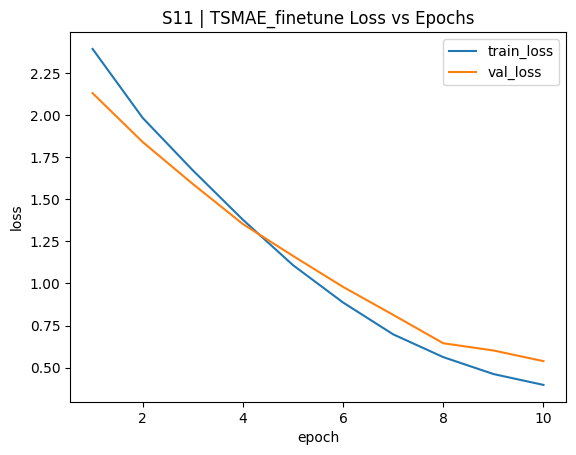

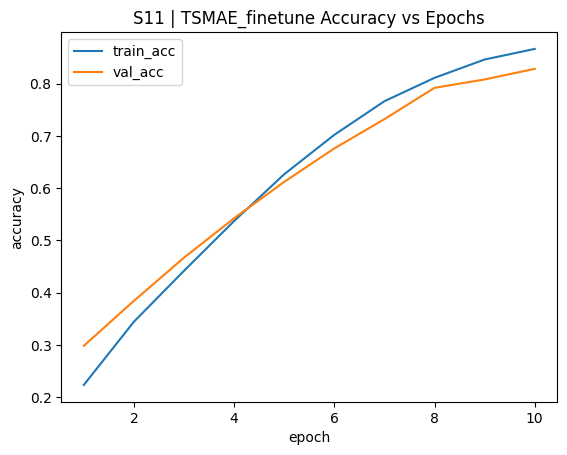


LOSO TEST SUBJECT: S12

--- CNN ---
Params total=232,273 | trainable=232,273 | size≈0.89 MB
Epoch 1/10 | time=3.24s | tr_loss=2.2681 tr_acc=0.2664 | va_loss=2.1110 va_acc=0.3145
Epoch 2/10 | time=2.67s | tr_loss=1.9294 tr_acc=0.3670 | va_loss=1.9303 va_acc=0.3737
Epoch 3/10 | time=2.65s | tr_loss=1.7296 tr_acc=0.4315 | va_loss=1.7940 va_acc=0.4118
Epoch 4/10 | time=2.64s | tr_loss=1.5759 tr_acc=0.4777 | va_loss=1.6408 va_acc=0.4531
Epoch 5/10 | time=3.37s | tr_loss=1.4562 tr_acc=0.5187 | va_loss=1.7130 va_acc=0.4364
Epoch 6/10 | time=2.82s | tr_loss=1.3411 tr_acc=0.5567 | va_loss=1.5596 va_acc=0.4877
Epoch 7/10 | time=2.65s | tr_loss=1.2580 tr_acc=0.5829 | va_loss=1.7035 va_acc=0.4455
Epoch 8/10 | time=2.69s | tr_loss=1.1688 tr_acc=0.6146 | va_loss=1.4357 va_acc=0.5294
Epoch 9/10 | time=2.81s | tr_loss=1.0988 tr_acc=0.6368 | va_loss=1.3387 va_acc=0.5497
Epoch 10/10 | time=3.40s | tr_loss=1.0375 tr_acc=0.6559 | va_loss=1.3078 va_acc=0.5568
TEST: acc=0.2091, precision=0.2690, recall=0.2

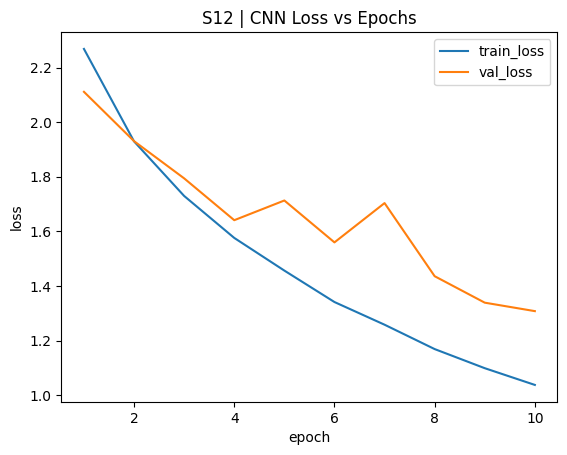

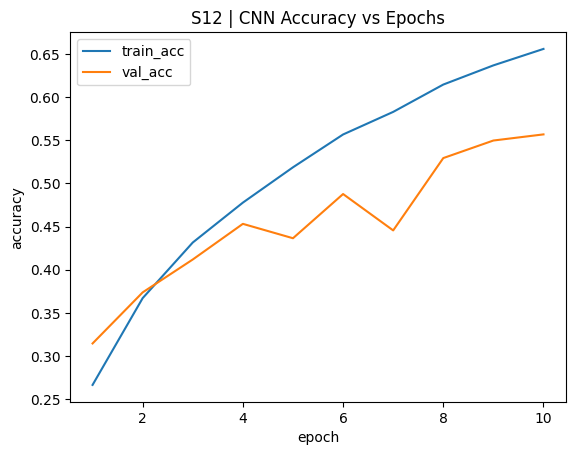


--- BiLSTM ---
Params total=545,041 | trainable=545,041 | size≈2.08 MB
Epoch 1/10 | time=12.44s | tr_loss=2.5208 tr_acc=0.1816 | va_loss=2.3298 va_acc=0.2386
Epoch 2/10 | time=12.50s | tr_loss=2.1834 tr_acc=0.2815 | va_loss=2.0477 va_acc=0.3099
Epoch 3/10 | time=12.50s | tr_loss=1.9359 tr_acc=0.3516 | va_loss=1.8268 va_acc=0.3907
Epoch 4/10 | time=12.59s | tr_loss=1.7141 tr_acc=0.4225 | va_loss=1.6228 va_acc=0.4504
Epoch 5/10 | time=12.56s | tr_loss=1.5196 tr_acc=0.4863 | va_loss=1.4614 va_acc=0.5121
Epoch 6/10 | time=12.46s | tr_loss=1.3539 tr_acc=0.5385 | va_loss=1.3177 va_acc=0.5516
Epoch 7/10 | time=12.43s | tr_loss=1.2058 tr_acc=0.5871 | va_loss=1.1835 va_acc=0.5902
Epoch 8/10 | time=12.34s | tr_loss=1.0568 tr_acc=0.6376 | va_loss=1.0732 va_acc=0.6352
Epoch 9/10 | time=12.38s | tr_loss=0.9425 tr_acc=0.6772 | va_loss=0.9670 va_acc=0.6620
Epoch 10/10 | time=12.39s | tr_loss=0.8489 tr_acc=0.7084 | va_loss=0.8902 va_acc=0.6914
TEST: acc=0.1967, precision=0.1920, recall=0.2454, f1=0.1

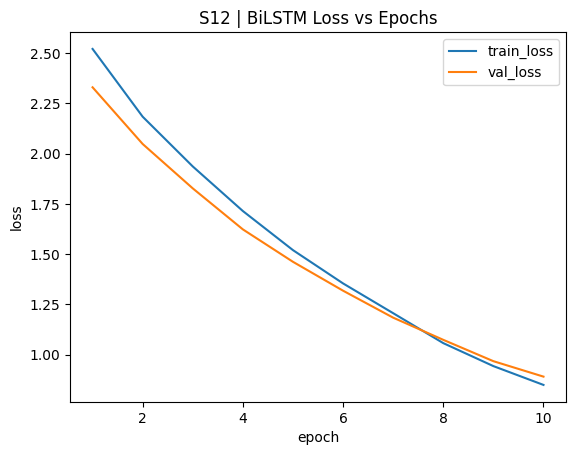

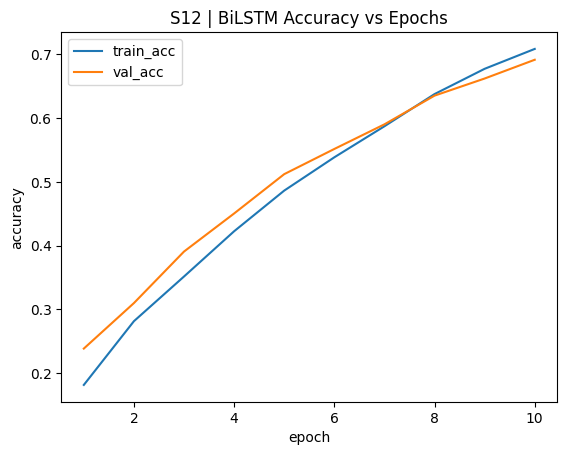


--- Transformer ---
Params total=797,201 | trainable=797,201 | size≈3.04 MB
Epoch 1/10 | time=23.28s | tr_loss=2.1101 tr_acc=0.3111 | va_loss=1.7492 va_acc=0.4193
Epoch 2/10 | time=23.27s | tr_loss=1.5150 tr_acc=0.4838 | va_loss=1.3539 va_acc=0.5344
Epoch 3/10 | time=23.32s | tr_loss=1.1745 tr_acc=0.5944 | va_loss=1.1294 va_acc=0.6000
Epoch 4/10 | time=23.22s | tr_loss=0.9673 tr_acc=0.6607 | va_loss=0.9137 va_acc=0.6789
Epoch 5/10 | time=23.28s | tr_loss=0.8117 tr_acc=0.7136 | va_loss=0.7856 va_acc=0.7237
Epoch 6/10 | time=23.25s | tr_loss=0.6989 tr_acc=0.7517 | va_loss=0.6980 va_acc=0.7492
Epoch 7/10 | time=23.28s | tr_loss=0.6140 tr_acc=0.7795 | va_loss=0.6420 va_acc=0.7770
Epoch 8/10 | time=23.38s | tr_loss=0.5478 tr_acc=0.8042 | va_loss=0.6196 va_acc=0.7835
Epoch 9/10 | time=23.32s | tr_loss=0.4962 tr_acc=0.8225 | va_loss=0.5322 va_acc=0.8167
Epoch 10/10 | time=23.29s | tr_loss=0.4485 tr_acc=0.8392 | va_loss=0.5407 va_acc=0.8092
TEST: acc=0.2403, precision=0.2939, recall=0.2712, f

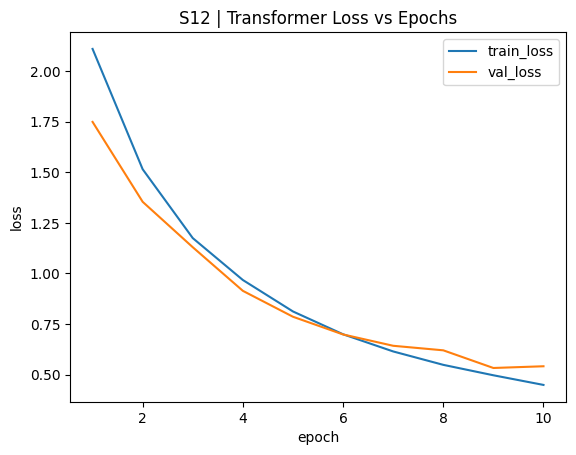

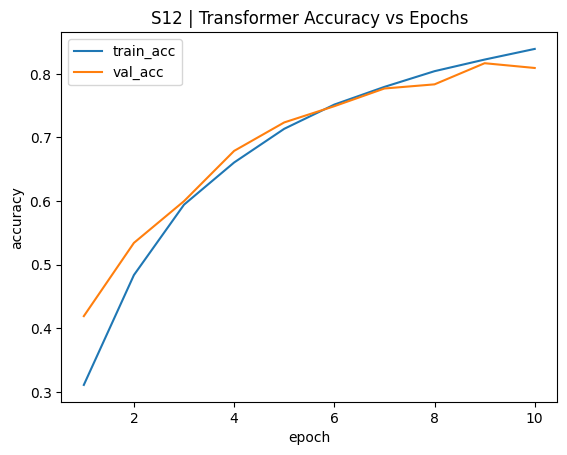


[TSMAE] Pretraining...


Pretrain epoch 1/10 | time=5.86s | loss=1.0067


Pretrain epoch 2/10 | time=5.51s | loss=1.0056


Pretrain epoch 3/10 | time=4.98s | loss=1.0035


Pretrain epoch 4/10 | time=6.20s | loss=1.0089


Pretrain epoch 5/10 | time=5.04s | loss=1.0080


Pretrain epoch 6/10 | time=4.91s | loss=1.0109


Pretrain epoch 7/10 | time=6.43s | loss=1.0160


Pretrain epoch 8/10 | time=4.92s | loss=1.0036


Pretrain epoch 9/10 | time=5.50s | loss=1.0052


Pretrain epoch 10/10 | time=6.01s | loss=1.0117
TSMAE pretrain total time (s): 55.36177587509155
[TSMAE] Fine-tuning...

--- TSMAE_finetune ---
Params total=892,681 | trainable=892,681 | size≈3.41 MB


Epoch 1/10 | time=4.87s | tr_loss=2.4212 tr_acc=0.2137 | va_loss=2.1466 va_acc=0.3012
Epoch 2/10 | time=5.54s | tr_loss=2.0070 tr_acc=0.3378 | va_loss=1.8455 va_acc=0.3870
Epoch 3/10 | time=4.62s | tr_loss=1.6936 tr_acc=0.4363 | va_loss=1.5980 va_acc=0.4578
Epoch 4/10 | time=4.67s | tr_loss=1.3967 tr_acc=0.5287 | va_loss=1.3274 va_acc=0.5637
Epoch 5/10 | time=5.49s | tr_loss=1.1317 tr_acc=0.6184 | va_loss=1.1390 va_acc=0.6196
Epoch 6/10 | time=4.65s | tr_loss=0.9089 tr_acc=0.6945 | va_loss=0.9721 va_acc=0.6757
Epoch 7/10 | time=5.19s | tr_loss=0.7377 tr_acc=0.7515 | va_loss=0.8175 va_acc=0.7267
Epoch 8/10 | time=5.10s | tr_loss=0.6087 tr_acc=0.7945 | va_loss=0.7252 va_acc=0.7679
Epoch 9/10 | time=4.68s | tr_loss=0.5033 tr_acc=0.8289 | va_loss=0.6203 va_acc=0.7986
Epoch 10/10 | time=5.63s | tr_loss=0.4289 tr_acc=0.8542 | va_loss=0.5661 va_acc=0.8215
TEST: acc=0.2319, precision=0.2063, recall=0.2733, f1=0.2117
Train time: per-epoch mean=5.04s | total=50.44s
Confusion matrix shape: (17, 1

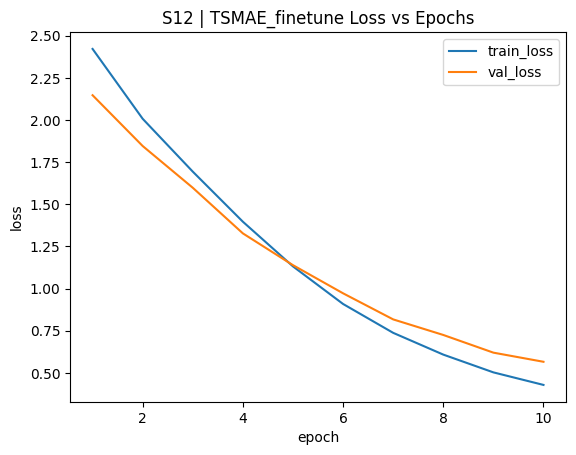

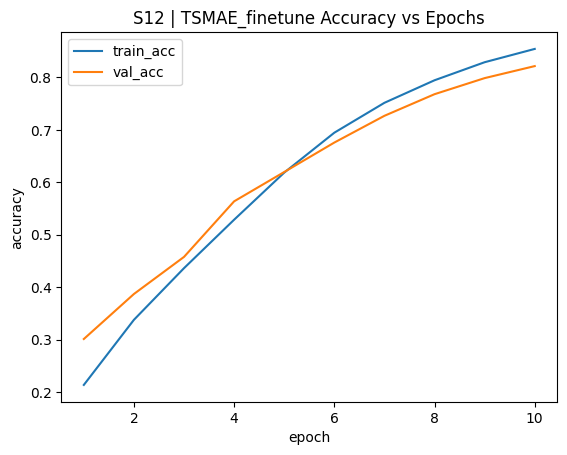


LOSO TEST SUBJECT: S13

--- CNN ---
Params total=232,273 | trainable=232,273 | size≈0.89 MB
Epoch 1/10 | time=2.76s | tr_loss=2.2380 tr_acc=0.2758 | va_loss=2.0717 va_acc=0.3268
Epoch 2/10 | time=2.67s | tr_loss=1.8781 tr_acc=0.3815 | va_loss=1.8228 va_acc=0.3874
Epoch 3/10 | time=2.95s | tr_loss=1.6805 tr_acc=0.4444 | va_loss=1.7631 va_acc=0.4063
Epoch 4/10 | time=3.38s | tr_loss=1.5226 tr_acc=0.4943 | va_loss=1.6097 va_acc=0.4628
Epoch 5/10 | time=2.68s | tr_loss=1.3879 tr_acc=0.5404 | va_loss=1.5448 va_acc=0.4762
Epoch 6/10 | time=2.66s | tr_loss=1.2805 tr_acc=0.5740 | va_loss=1.6691 va_acc=0.4516
Epoch 7/10 | time=2.68s | tr_loss=1.1914 tr_acc=0.6044 | va_loss=1.3400 va_acc=0.5496
Epoch 8/10 | time=3.24s | tr_loss=1.1160 tr_acc=0.6294 | va_loss=1.4683 va_acc=0.5216
Epoch 9/10 | time=2.98s | tr_loss=1.0429 tr_acc=0.6536 | va_loss=1.3687 va_acc=0.5508
Epoch 10/10 | time=2.66s | tr_loss=0.9888 tr_acc=0.6722 | va_loss=1.2953 va_acc=0.5658
TEST: acc=0.2435, precision=0.2787, recall=0.2

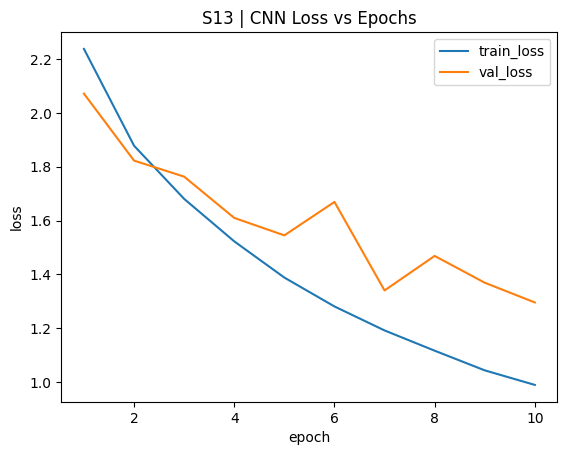

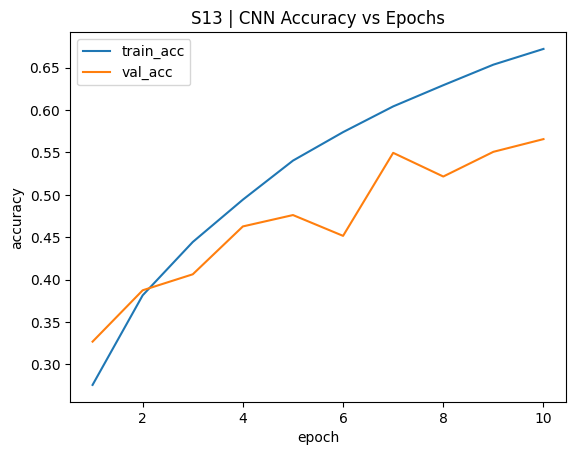


--- BiLSTM ---
Params total=545,041 | trainable=545,041 | size≈2.08 MB
Epoch 1/10 | time=12.51s | tr_loss=2.4820 tr_acc=0.1921 | va_loss=2.2816 va_acc=0.2463
Epoch 2/10 | time=12.52s | tr_loss=2.1786 tr_acc=0.2815 | va_loss=2.1348 va_acc=0.2878
Epoch 3/10 | time=12.53s | tr_loss=1.9387 tr_acc=0.3543 | va_loss=1.8384 va_acc=0.3849
Epoch 4/10 | time=12.51s | tr_loss=1.6948 tr_acc=0.4304 | va_loss=1.6090 va_acc=0.4497
Epoch 5/10 | time=12.50s | tr_loss=1.4807 tr_acc=0.4996 | va_loss=1.4155 va_acc=0.5248
Epoch 6/10 | time=12.52s | tr_loss=1.3033 tr_acc=0.5600 | va_loss=1.2695 va_acc=0.5680
Epoch 7/10 | time=12.52s | tr_loss=1.1578 tr_acc=0.6063 | va_loss=1.1448 va_acc=0.6134
Epoch 8/10 | time=12.62s | tr_loss=1.0351 tr_acc=0.6490 | va_loss=1.0432 va_acc=0.6466
Epoch 9/10 | time=12.64s | tr_loss=0.9149 tr_acc=0.6870 | va_loss=0.9682 va_acc=0.6707
Epoch 10/10 | time=12.71s | tr_loss=0.8208 tr_acc=0.7190 | va_loss=0.8820 va_acc=0.6937
TEST: acc=0.2739, precision=0.2399, recall=0.2612, f1=0.2

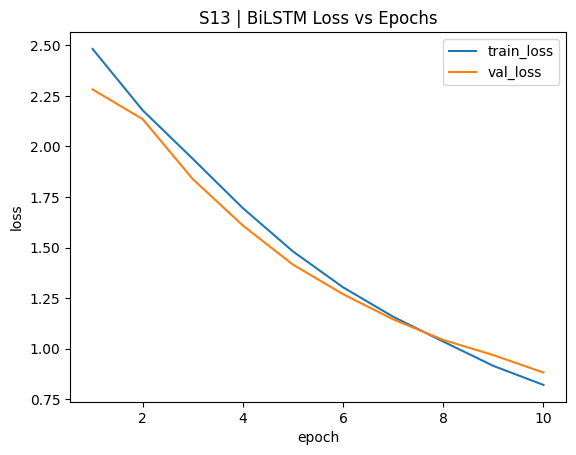

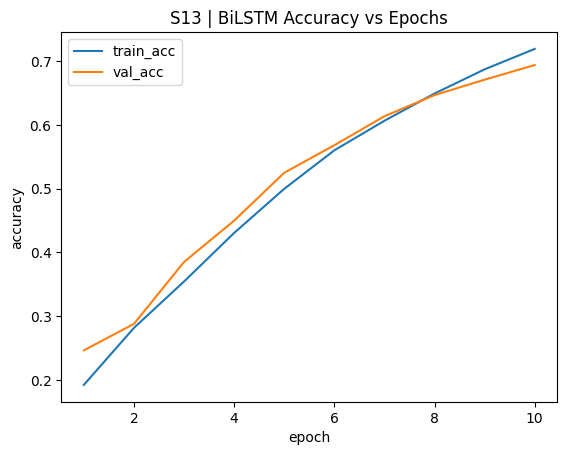


--- Transformer ---
Params total=797,201 | trainable=797,201 | size≈3.04 MB
Epoch 1/10 | time=24.01s | tr_loss=2.0611 tr_acc=0.3226 | va_loss=1.6902 va_acc=0.4277
Epoch 2/10 | time=23.92s | tr_loss=1.4920 tr_acc=0.4924 | va_loss=1.2993 va_acc=0.5605
Epoch 3/10 | time=23.87s | tr_loss=1.1703 tr_acc=0.5956 | va_loss=1.0701 va_acc=0.6221
Epoch 4/10 | time=24.23s | tr_loss=0.9550 tr_acc=0.6656 | va_loss=0.9006 va_acc=0.6845
Epoch 5/10 | time=23.88s | tr_loss=0.8066 tr_acc=0.7145 | va_loss=0.8109 va_acc=0.7149
Epoch 6/10 | time=23.96s | tr_loss=0.6955 tr_acc=0.7515 | va_loss=0.6706 va_acc=0.7694
Epoch 7/10 | time=23.93s | tr_loss=0.6080 tr_acc=0.7826 | va_loss=0.7131 va_acc=0.7562
Epoch 8/10 | time=23.98s | tr_loss=0.5363 tr_acc=0.8077 | va_loss=0.6029 va_acc=0.7848
Epoch 9/10 | time=24.10s | tr_loss=0.4902 tr_acc=0.8248 | va_loss=0.5415 va_acc=0.8102
Epoch 10/10 | time=24.22s | tr_loss=0.4328 tr_acc=0.8447 | va_loss=0.5229 va_acc=0.8169
TEST: acc=0.2650, precision=0.2372, recall=0.2562, f

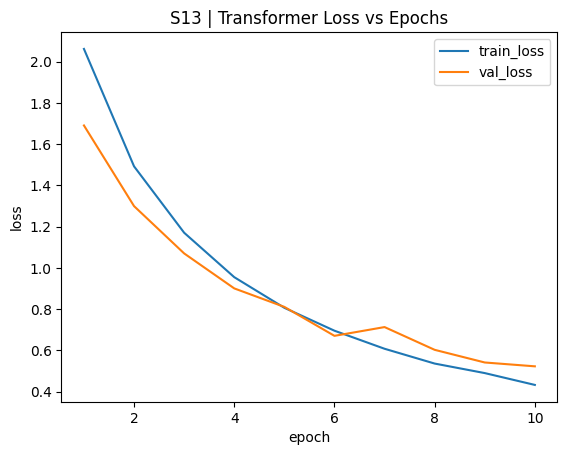

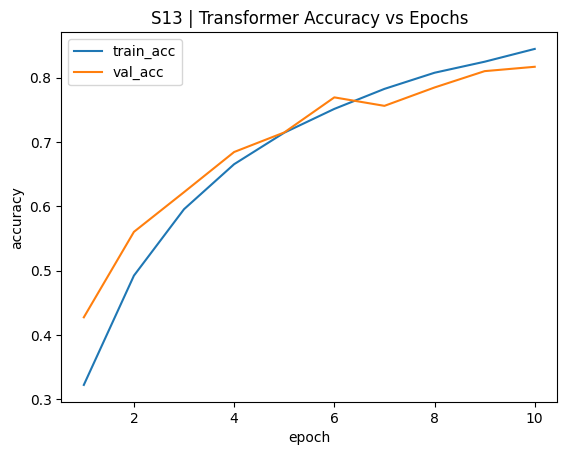


[TSMAE] Pretraining...


Pretrain epoch 1/10 | time=5.27s | loss=1.0129


Pretrain epoch 2/10 | time=6.53s | loss=1.0140


Pretrain epoch 3/10 | time=5.17s | loss=1.0185


Pretrain epoch 4/10 | time=5.64s | loss=1.0187


Pretrain epoch 5/10 | time=5.89s | loss=1.0140


Pretrain epoch 6/10 | time=5.07s | loss=1.0130


Pretrain epoch 7/10 | time=6.70s | loss=1.0169


Pretrain epoch 8/10 | time=5.02s | loss=1.0289


Pretrain epoch 9/10 | time=5.25s | loss=1.0206


Pretrain epoch 10/10 | time=6.72s | loss=1.0120
TSMAE pretrain total time (s): 57.26352620124817
[TSMAE] Fine-tuning...

--- TSMAE_finetune ---
Params total=892,681 | trainable=892,681 | size≈3.41 MB


Epoch 1/10 | time=5.24s | tr_loss=2.4227 tr_acc=0.2128 | va_loss=2.2043 va_acc=0.2809
Epoch 2/10 | time=6.09s | tr_loss=2.0131 tr_acc=0.3348 | va_loss=1.8853 va_acc=0.3669
Epoch 3/10 | time=5.43s | tr_loss=1.7052 tr_acc=0.4292 | va_loss=1.6081 va_acc=0.4555
Epoch 4/10 | time=5.14s | tr_loss=1.4116 tr_acc=0.5239 | va_loss=1.3740 va_acc=0.5366
Epoch 5/10 | time=6.23s | tr_loss=1.1436 tr_acc=0.6129 | va_loss=1.1790 va_acc=0.6068
Epoch 6/10 | time=5.13s | tr_loss=0.9203 tr_acc=0.6890 | va_loss=0.9833 va_acc=0.6676
Epoch 7/10 | time=5.95s | tr_loss=0.7336 tr_acc=0.7528 | va_loss=0.8525 va_acc=0.7133
Epoch 8/10 | time=5.30s | tr_loss=0.6033 tr_acc=0.7972 | va_loss=0.7198 va_acc=0.7614
Epoch 9/10 | time=5.53s | tr_loss=0.5051 tr_acc=0.8291 | va_loss=0.6260 va_acc=0.7979
Epoch 10/10 | time=5.58s | tr_loss=0.4227 tr_acc=0.8585 | va_loss=0.5215 va_acc=0.8308
TEST: acc=0.2100, precision=0.1945, recall=0.1949, f1=0.1732
Train time: per-epoch mean=5.56s | total=55.62s
Confusion matrix shape: (17, 1

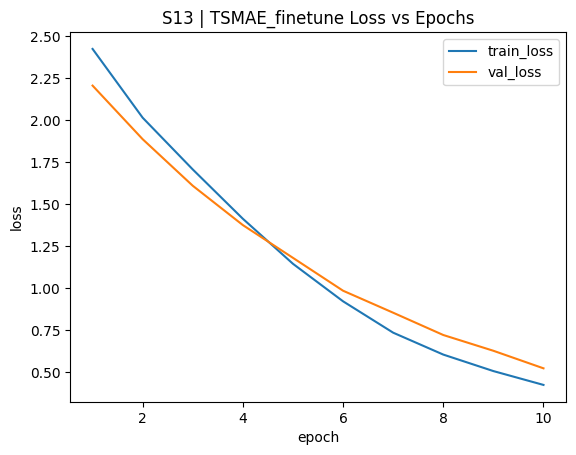

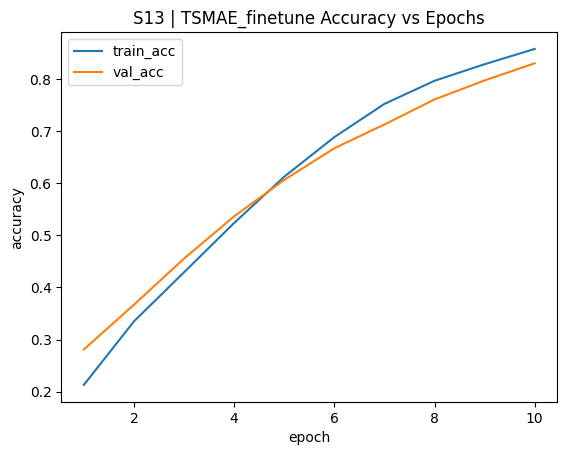


LOSO TEST SUBJECT: S14

--- CNN ---
Params total=232,273 | trainable=232,273 | size≈0.89 MB
Epoch 1/10 | time=3.68s | tr_loss=2.2632 tr_acc=0.2679 | va_loss=2.1546 va_acc=0.2950
Epoch 2/10 | time=4.41s | tr_loss=1.9112 tr_acc=0.3689 | va_loss=1.9136 va_acc=0.3563
Epoch 3/10 | time=3.54s | tr_loss=1.7133 tr_acc=0.4325 | va_loss=1.8667 va_acc=0.3938
Epoch 4/10 | time=3.60s | tr_loss=1.5507 tr_acc=0.4850 | va_loss=1.5769 va_acc=0.4787
Epoch 5/10 | time=4.23s | tr_loss=1.4184 tr_acc=0.5308 | va_loss=1.5580 va_acc=0.4803
Epoch 6/10 | time=4.00s | tr_loss=1.3099 tr_acc=0.5642 | va_loss=1.5177 va_acc=0.4897
Epoch 7/10 | time=2.67s | tr_loss=1.2212 tr_acc=0.5938 | va_loss=1.4441 va_acc=0.5039
Epoch 8/10 | time=2.69s | tr_loss=1.1377 tr_acc=0.6225 | va_loss=1.5757 va_acc=0.4931
Epoch 9/10 | time=2.88s | tr_loss=1.0624 tr_acc=0.6474 | va_loss=1.4160 va_acc=0.5147
Epoch 10/10 | time=3.37s | tr_loss=1.0010 tr_acc=0.6663 | va_loss=1.1885 va_acc=0.5957
TEST: acc=0.2100, precision=0.2857, recall=0.2

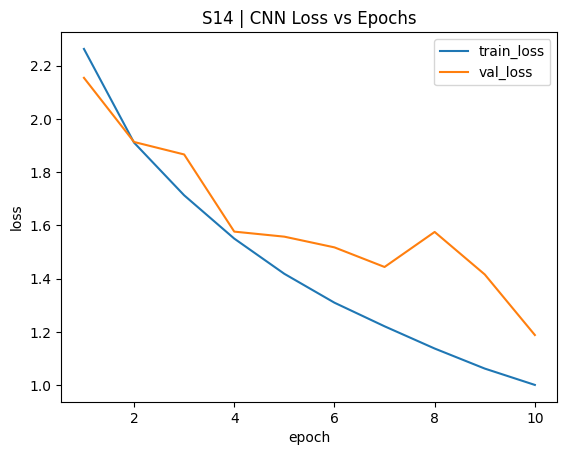

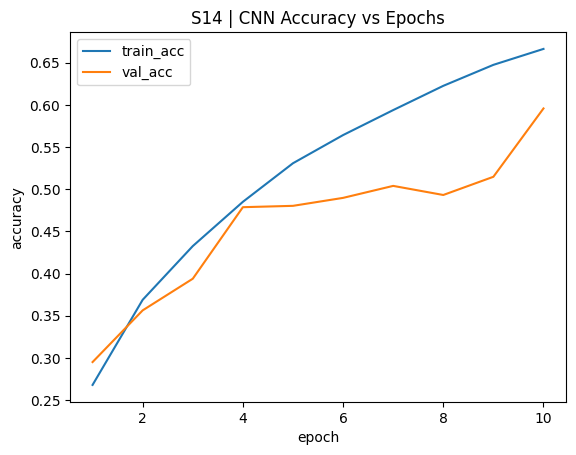


--- BiLSTM ---
Params total=545,041 | trainable=545,041 | size≈2.08 MB
Epoch 1/10 | time=12.44s | tr_loss=2.4716 tr_acc=0.1977 | va_loss=2.2517 va_acc=0.2617
Epoch 2/10 | time=12.50s | tr_loss=2.1364 tr_acc=0.2952 | va_loss=2.0175 va_acc=0.3305
Epoch 3/10 | time=12.50s | tr_loss=1.9128 tr_acc=0.3580 | va_loss=1.8103 va_acc=0.3811
Epoch 4/10 | time=12.59s | tr_loss=1.6947 tr_acc=0.4277 | va_loss=1.6293 va_acc=0.4521
Epoch 5/10 | time=12.57s | tr_loss=1.5095 tr_acc=0.4867 | va_loss=1.4218 va_acc=0.5152
Epoch 6/10 | time=12.45s | tr_loss=1.3496 tr_acc=0.5417 | va_loss=1.3195 va_acc=0.5505
Epoch 7/10 | time=12.42s | tr_loss=1.1927 tr_acc=0.5935 | va_loss=1.1773 va_acc=0.5914
Epoch 8/10 | time=12.38s | tr_loss=1.0538 tr_acc=0.6395 | va_loss=1.0541 va_acc=0.6325
Epoch 9/10 | time=12.36s | tr_loss=0.9463 tr_acc=0.6759 | va_loss=0.9691 va_acc=0.6688
Epoch 10/10 | time=12.35s | tr_loss=0.8475 tr_acc=0.7092 | va_loss=0.8700 va_acc=0.6993
TEST: acc=0.2016, precision=0.2708, recall=0.2365, f1=0.2

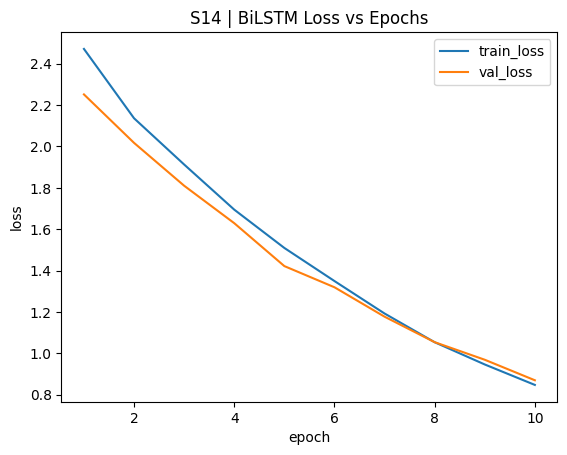

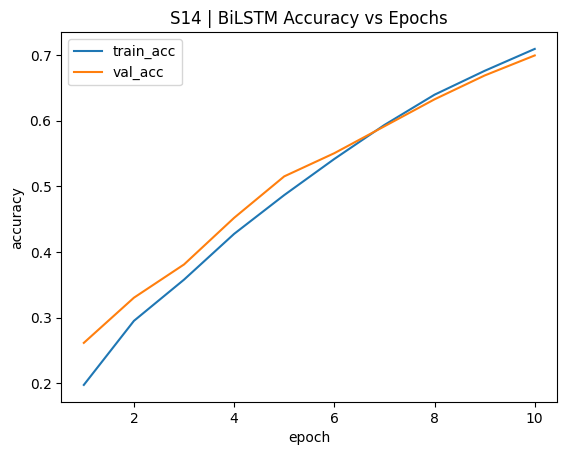


--- Transformer ---
Params total=797,201 | trainable=797,201 | size≈3.04 MB
Epoch 1/10 | time=23.25s | tr_loss=2.0681 tr_acc=0.3191 | va_loss=1.6704 va_acc=0.4419
Epoch 2/10 | time=23.20s | tr_loss=1.4759 tr_acc=0.4965 | va_loss=1.2820 va_acc=0.5515
Epoch 3/10 | time=23.35s | tr_loss=1.1476 tr_acc=0.6001 | va_loss=1.0721 va_acc=0.6226
Epoch 4/10 | time=23.27s | tr_loss=0.9441 tr_acc=0.6664 | va_loss=0.9150 va_acc=0.6780
Epoch 5/10 | time=23.33s | tr_loss=0.7915 tr_acc=0.7203 | va_loss=0.7442 va_acc=0.7292
Epoch 6/10 | time=23.32s | tr_loss=0.6879 tr_acc=0.7548 | va_loss=0.7113 va_acc=0.7459
Epoch 7/10 | time=23.29s | tr_loss=0.6058 tr_acc=0.7835 | va_loss=0.6476 va_acc=0.7698
Epoch 8/10 | time=23.37s | tr_loss=0.5368 tr_acc=0.8079 | va_loss=0.5994 va_acc=0.7861
Epoch 9/10 | time=23.29s | tr_loss=0.4804 tr_acc=0.8276 | va_loss=0.5296 va_acc=0.8128
Epoch 10/10 | time=23.26s | tr_loss=0.4330 tr_acc=0.8447 | va_loss=0.5323 va_acc=0.8099
TEST: acc=0.1792, precision=0.2502, recall=0.2363, f

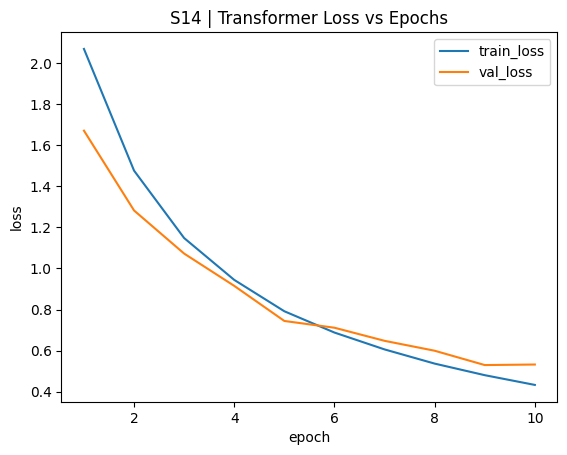

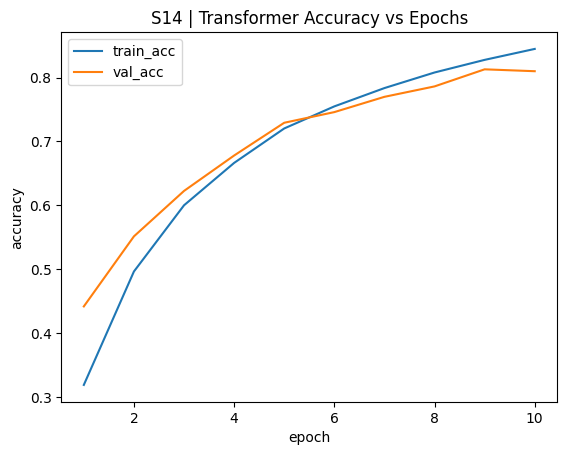


[TSMAE] Pretraining...


Pretrain epoch 1/10 | time=6.31s | loss=1.0157


Pretrain epoch 2/10 | time=5.91s | loss=1.0092


Pretrain epoch 3/10 | time=5.09s | loss=1.0043


Pretrain epoch 4/10 | time=6.86s | loss=1.0140


Pretrain epoch 5/10 | time=5.28s | loss=1.0173


Pretrain epoch 6/10 | time=6.15s | loss=1.0226


Pretrain epoch 7/10 | time=6.05s | loss=1.0083


Pretrain epoch 8/10 | time=5.17s | loss=1.0185


Pretrain epoch 9/10 | time=6.45s | loss=1.0161


Pretrain epoch 10/10 | time=5.29s | loss=1.0221
TSMAE pretrain total time (s): 58.56710457801819
[TSMAE] Fine-tuning...

--- TSMAE_finetune ---
Params total=892,681 | trainable=892,681 | size≈3.41 MB


Epoch 1/10 | time=4.71s | tr_loss=2.4022 tr_acc=0.2188 | va_loss=2.1428 va_acc=0.2949
Epoch 2/10 | time=5.66s | tr_loss=1.9863 tr_acc=0.3420 | va_loss=1.8525 va_acc=0.3834
Epoch 3/10 | time=4.78s | tr_loss=1.6778 tr_acc=0.4371 | va_loss=1.5909 va_acc=0.4692
Epoch 4/10 | time=5.32s | tr_loss=1.3928 tr_acc=0.5280 | va_loss=1.3478 va_acc=0.5374
Epoch 5/10 | time=5.02s | tr_loss=1.1223 tr_acc=0.6197 | va_loss=1.1247 va_acc=0.6236
Epoch 6/10 | time=4.65s | tr_loss=0.8937 tr_acc=0.6980 | va_loss=0.9440 va_acc=0.6858
Epoch 7/10 | time=5.64s | tr_loss=0.7232 tr_acc=0.7542 | va_loss=0.8149 va_acc=0.7295
Epoch 8/10 | time=4.67s | tr_loss=0.5826 tr_acc=0.8022 | va_loss=0.6862 va_acc=0.7759
Epoch 9/10 | time=4.99s | tr_loss=0.4939 tr_acc=0.8321 | va_loss=0.5954 va_acc=0.8034
Epoch 10/10 | time=5.41s | tr_loss=0.4008 tr_acc=0.8647 | va_loss=0.5450 va_acc=0.8239
TEST: acc=0.1910, precision=0.2109, recall=0.2126, f1=0.1973
Train time: per-epoch mean=5.08s | total=50.84s
Confusion matrix shape: (17, 1

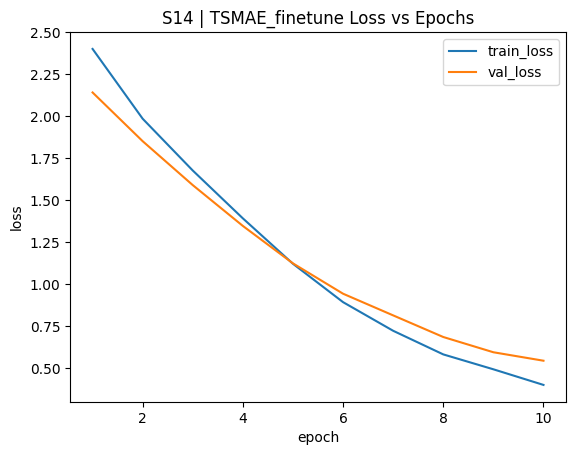

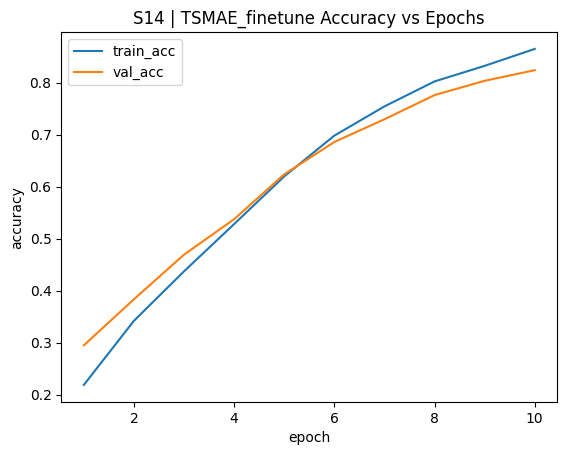


LOSO TEST SUBJECT: S15

--- CNN ---
Params total=232,273 | trainable=232,273 | size≈0.89 MB
Epoch 1/10 | time=2.81s | tr_loss=2.2748 tr_acc=0.2624 | va_loss=2.0922 va_acc=0.3142
Epoch 2/10 | time=2.94s | tr_loss=1.9242 tr_acc=0.3647 | va_loss=1.8974 va_acc=0.3745
Epoch 3/10 | time=3.37s | tr_loss=1.7179 tr_acc=0.4312 | va_loss=1.7620 va_acc=0.4144
Epoch 4/10 | time=2.70s | tr_loss=1.5566 tr_acc=0.4814 | va_loss=1.5664 va_acc=0.4754
Epoch 5/10 | time=2.65s | tr_loss=1.4332 tr_acc=0.5225 | va_loss=1.5698 va_acc=0.4640
Epoch 6/10 | time=2.68s | tr_loss=1.3271 tr_acc=0.5591 | va_loss=1.4795 va_acc=0.5012
Epoch 7/10 | time=3.11s | tr_loss=1.2244 tr_acc=0.5913 | va_loss=1.3815 va_acc=0.5321
Epoch 8/10 | time=3.23s | tr_loss=1.1481 tr_acc=0.6159 | va_loss=1.5487 va_acc=0.4853
Epoch 9/10 | time=2.72s | tr_loss=1.0843 tr_acc=0.6375 | va_loss=1.2804 va_acc=0.5615
Epoch 10/10 | time=2.74s | tr_loss=1.0172 tr_acc=0.6603 | va_loss=1.2487 va_acc=0.5705
TEST: acc=0.3028, precision=0.3035, recall=0.3

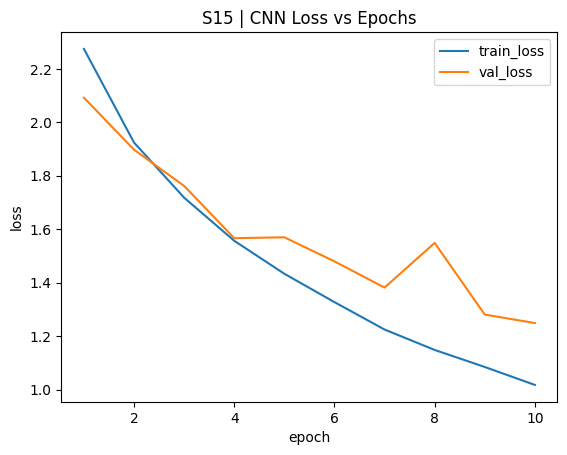

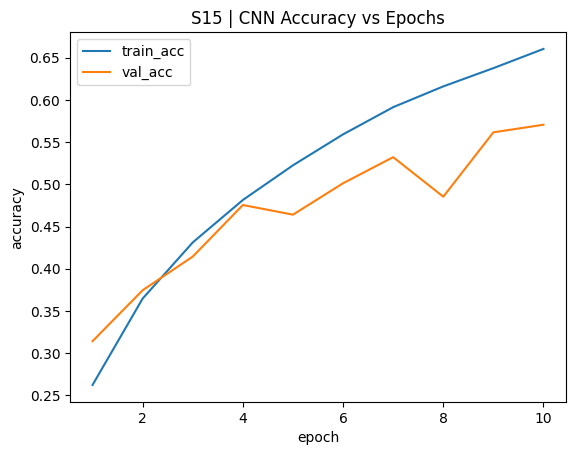


--- BiLSTM ---
Params total=545,041 | trainable=545,041 | size≈2.08 MB
Epoch 1/10 | time=12.51s | tr_loss=2.4927 tr_acc=0.1898 | va_loss=2.2659 va_acc=0.2543
Epoch 2/10 | time=12.50s | tr_loss=2.1606 tr_acc=0.2838 | va_loss=2.1563 va_acc=0.2924
Epoch 3/10 | time=12.47s | tr_loss=1.9313 tr_acc=0.3531 | va_loss=1.8041 va_acc=0.3969
Epoch 4/10 | time=12.48s | tr_loss=1.7010 tr_acc=0.4255 | va_loss=1.6251 va_acc=0.4547
Epoch 5/10 | time=12.47s | tr_loss=1.4987 tr_acc=0.4941 | va_loss=1.4253 va_acc=0.5167
Epoch 6/10 | time=12.48s | tr_loss=1.3339 tr_acc=0.5457 | va_loss=1.2996 va_acc=0.5624
Epoch 7/10 | time=12.49s | tr_loss=1.1838 tr_acc=0.5973 | va_loss=1.1668 va_acc=0.5956
Epoch 8/10 | time=12.51s | tr_loss=1.0581 tr_acc=0.6394 | va_loss=1.0384 va_acc=0.6403
Epoch 9/10 | time=12.49s | tr_loss=0.9386 tr_acc=0.6782 | va_loss=0.9459 va_acc=0.6731
Epoch 10/10 | time=12.50s | tr_loss=0.8437 tr_acc=0.7089 | va_loss=0.8761 va_acc=0.6933
TEST: acc=0.3195, precision=0.3289, recall=0.3183, f1=0.3

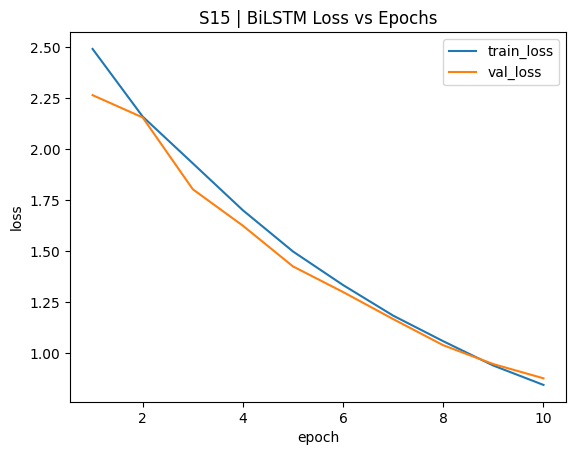

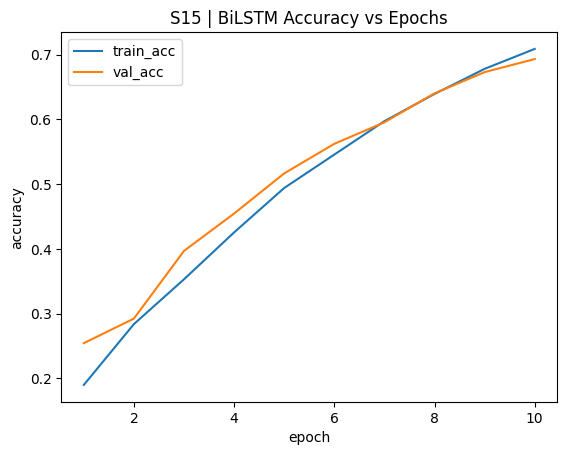


--- Transformer ---
Params total=797,201 | trainable=797,201 | size≈3.04 MB
Epoch 1/10 | time=23.63s | tr_loss=2.1040 tr_acc=0.3077 | va_loss=1.6995 va_acc=0.4316
Epoch 2/10 | time=23.58s | tr_loss=1.4972 tr_acc=0.4890 | va_loss=1.3131 va_acc=0.5468
Epoch 3/10 | time=23.52s | tr_loss=1.1810 tr_acc=0.5905 | va_loss=1.0826 va_acc=0.6223
Epoch 4/10 | time=23.49s | tr_loss=0.9705 tr_acc=0.6591 | va_loss=0.9090 va_acc=0.6856
Epoch 5/10 | time=23.45s | tr_loss=0.8226 tr_acc=0.7115 | va_loss=0.8131 va_acc=0.7189
Epoch 6/10 | time=23.58s | tr_loss=0.7086 tr_acc=0.7473 | va_loss=0.7037 va_acc=0.7564
Epoch 7/10 | time=23.53s | tr_loss=0.6269 tr_acc=0.7750 | va_loss=0.6653 va_acc=0.7645
Epoch 8/10 | time=23.48s | tr_loss=0.5650 tr_acc=0.7970 | va_loss=0.6086 va_acc=0.7824
Epoch 9/10 | time=23.48s | tr_loss=0.5004 tr_acc=0.8210 | va_loss=0.5835 va_acc=0.7961
Epoch 10/10 | time=23.53s | tr_loss=0.4517 tr_acc=0.8372 | va_loss=0.5129 va_acc=0.8177
TEST: acc=0.2626, precision=0.2621, recall=0.2730, f

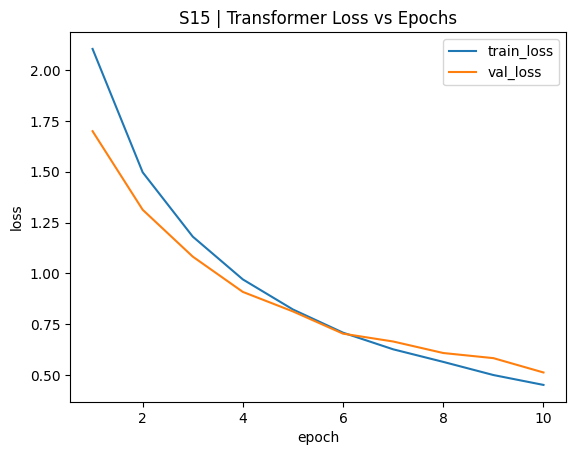

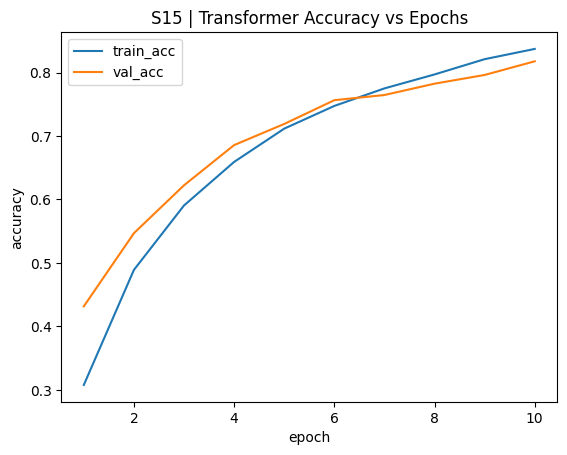


[TSMAE] Pretraining...


Pretrain epoch 1/10 | time=5.28s | loss=1.0206


Pretrain epoch 2/10 | time=6.96s | loss=1.0192


Pretrain epoch 3/10 | time=5.45s | loss=1.0189


Pretrain epoch 4/10 | time=5.64s | loss=1.0160


Pretrain epoch 5/10 | time=6.67s | loss=1.0221


Pretrain epoch 6/10 | time=5.23s | loss=1.0177


Pretrain epoch 7/10 | time=6.20s | loss=1.0213


Pretrain epoch 8/10 | time=5.61s | loss=1.0130


Pretrain epoch 9/10 | time=5.31s | loss=1.0290


Pretrain epoch 10/10 | time=6.98s | loss=1.0108
TSMAE pretrain total time (s): 59.33194899559021
[TSMAE] Fine-tuning...

--- TSMAE_finetune ---
Params total=892,681 | trainable=892,681 | size≈3.41 MB


Epoch 1/10 | time=4.83s | tr_loss=2.4230 tr_acc=0.2129 | va_loss=2.1672 va_acc=0.2860
Epoch 2/10 | time=5.10s | tr_loss=2.0218 tr_acc=0.3311 | va_loss=1.8697 va_acc=0.3777
Epoch 3/10 | time=5.33s | tr_loss=1.6993 tr_acc=0.4302 | va_loss=1.5668 va_acc=0.4714
Epoch 4/10 | time=4.74s | tr_loss=1.4049 tr_acc=0.5234 | va_loss=1.3348 va_acc=0.5529
Epoch 5/10 | time=5.67s | tr_loss=1.1361 tr_acc=0.6142 | va_loss=1.1230 va_acc=0.6182
Epoch 6/10 | time=4.81s | tr_loss=0.9129 tr_acc=0.6887 | va_loss=0.9397 va_acc=0.6855
Epoch 7/10 | time=4.75s | tr_loss=0.7318 tr_acc=0.7507 | va_loss=0.8217 va_acc=0.7227
Epoch 8/10 | time=5.62s | tr_loss=0.5956 tr_acc=0.7983 | va_loss=0.7055 va_acc=0.7632
Epoch 9/10 | time=4.74s | tr_loss=0.5030 tr_acc=0.8300 | va_loss=0.6398 va_acc=0.7885
Epoch 10/10 | time=5.47s | tr_loss=0.4239 tr_acc=0.8563 | va_loss=0.5394 va_acc=0.8266
TEST: acc=0.2363, precision=0.2237, recall=0.2535, f1=0.2302
Train time: per-epoch mean=5.11s | total=51.07s
Confusion matrix shape: (17, 1

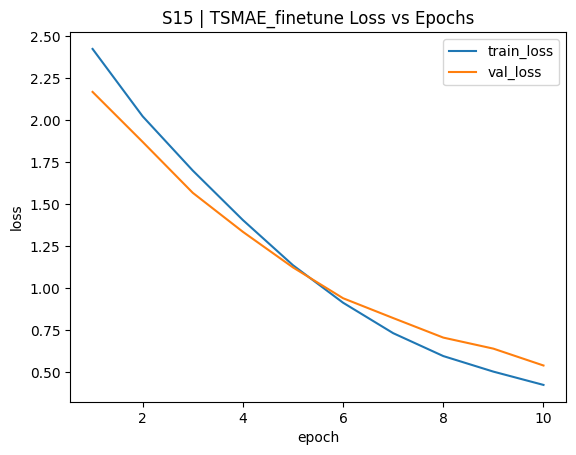

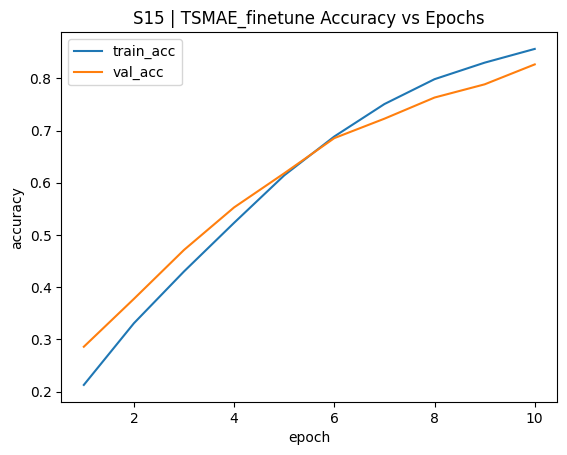


LOSO TEST SUBJECT: S16

--- CNN ---
Params total=232,273 | trainable=232,273 | size≈0.89 MB
Epoch 1/10 | time=2.82s | tr_loss=2.2035 tr_acc=0.2835 | va_loss=2.0311 va_acc=0.3262
Epoch 2/10 | time=2.72s | tr_loss=1.8335 tr_acc=0.3961 | va_loss=1.8429 va_acc=0.3881
Epoch 3/10 | time=2.68s | tr_loss=1.6316 tr_acc=0.4598 | va_loss=1.7871 va_acc=0.4134
Epoch 4/10 | time=3.58s | tr_loss=1.4815 tr_acc=0.5081 | va_loss=1.5340 va_acc=0.4913
Epoch 5/10 | time=2.74s | tr_loss=1.3520 tr_acc=0.5508 | va_loss=1.5187 va_acc=0.4848
Epoch 6/10 | time=2.71s | tr_loss=1.2523 tr_acc=0.5843 | va_loss=1.4929 va_acc=0.5058
Epoch 7/10 | time=2.71s | tr_loss=1.1615 tr_acc=0.6142 | va_loss=1.4241 va_acc=0.5220
Epoch 8/10 | time=3.03s | tr_loss=1.0776 tr_acc=0.6414 | va_loss=1.3658 va_acc=0.5481
Epoch 9/10 | time=3.23s | tr_loss=1.0190 tr_acc=0.6625 | va_loss=1.2033 va_acc=0.5981
Epoch 10/10 | time=2.75s | tr_loss=0.9557 tr_acc=0.6834 | va_loss=1.2145 va_acc=0.5865
TEST: acc=0.0351, precision=0.0475, recall=0.0

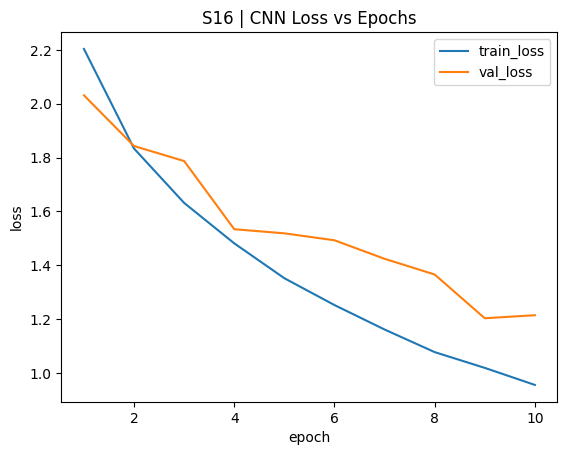

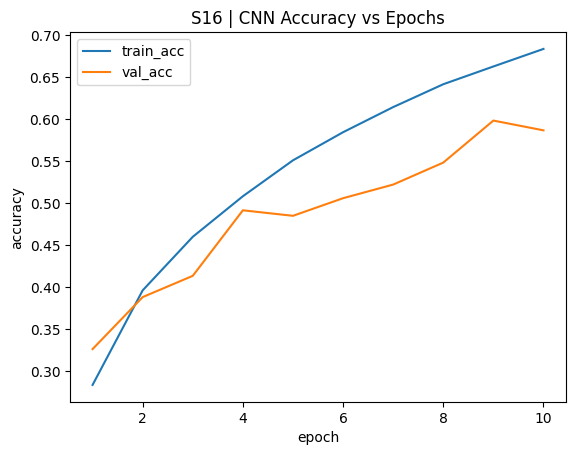


--- BiLSTM ---
Params total=545,041 | trainable=545,041 | size≈2.08 MB
Epoch 1/10 | time=12.58s | tr_loss=2.4796 tr_acc=0.1961 | va_loss=2.2521 va_acc=0.2569
Epoch 2/10 | time=12.52s | tr_loss=2.1103 tr_acc=0.3003 | va_loss=2.0374 va_acc=0.3233
Epoch 3/10 | time=12.49s | tr_loss=1.8719 tr_acc=0.3740 | va_loss=1.7632 va_acc=0.3977
Epoch 4/10 | time=12.52s | tr_loss=1.6481 tr_acc=0.4449 | va_loss=1.5880 va_acc=0.4630
Epoch 5/10 | time=12.53s | tr_loss=1.4499 tr_acc=0.5089 | va_loss=1.3713 va_acc=0.5272
Epoch 6/10 | time=12.51s | tr_loss=1.2648 tr_acc=0.5688 | va_loss=1.2109 va_acc=0.5899
Epoch 7/10 | time=12.61s | tr_loss=1.1390 tr_acc=0.6081 | va_loss=1.1651 va_acc=0.6069
Epoch 8/10 | time=12.67s | tr_loss=1.0007 tr_acc=0.6545 | va_loss=0.9984 va_acc=0.6518
Epoch 9/10 | time=12.70s | tr_loss=0.9006 tr_acc=0.6886 | va_loss=0.9110 va_acc=0.6839
Epoch 10/10 | time=12.72s | tr_loss=0.8056 tr_acc=0.7212 | va_loss=0.8448 va_acc=0.7122
TEST: acc=0.0631, precision=0.0514, recall=0.0639, f1=0.0

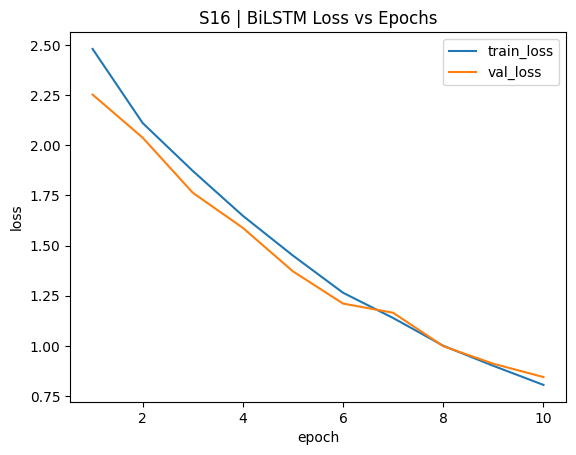

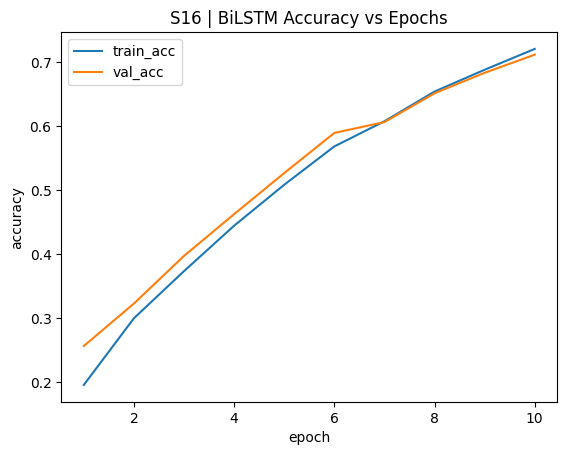


--- Transformer ---
Params total=797,201 | trainable=797,201 | size≈3.04 MB
Epoch 1/10 | time=23.53s | tr_loss=2.0576 tr_acc=0.3241 | va_loss=1.7082 va_acc=0.4206
Epoch 2/10 | time=23.52s | tr_loss=1.4647 tr_acc=0.5015 | va_loss=1.3082 va_acc=0.5579
Epoch 3/10 | time=23.54s | tr_loss=1.1448 tr_acc=0.6040 | va_loss=1.0416 va_acc=0.6385
Epoch 4/10 | time=23.58s | tr_loss=0.9345 tr_acc=0.6732 | va_loss=0.9212 va_acc=0.6789
Epoch 5/10 | time=23.62s | tr_loss=0.7956 tr_acc=0.7186 | va_loss=0.8225 va_acc=0.7146
Epoch 6/10 | time=23.57s | tr_loss=0.6753 tr_acc=0.7600 | va_loss=0.7083 va_acc=0.7467
Epoch 7/10 | time=23.57s | tr_loss=0.5917 tr_acc=0.7886 | va_loss=0.6356 va_acc=0.7739
Epoch 8/10 | time=23.57s | tr_loss=0.5274 tr_acc=0.8114 | va_loss=0.5816 va_acc=0.7919
Epoch 9/10 | time=23.51s | tr_loss=0.4744 tr_acc=0.8297 | va_loss=0.5417 va_acc=0.8097
Epoch 10/10 | time=23.61s | tr_loss=0.4264 tr_acc=0.8462 | va_loss=0.5016 va_acc=0.8203
TEST: acc=0.1205, precision=0.0811, recall=0.1179, f

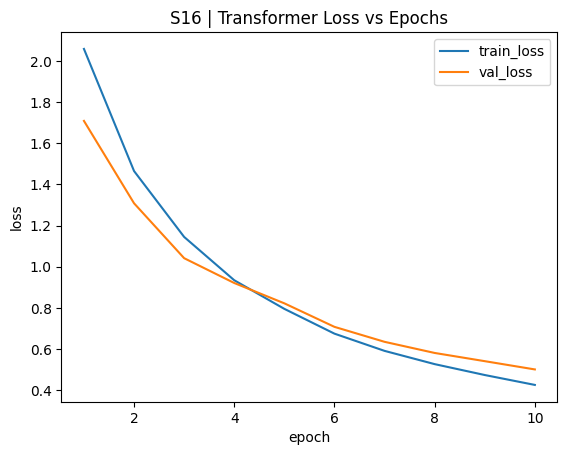

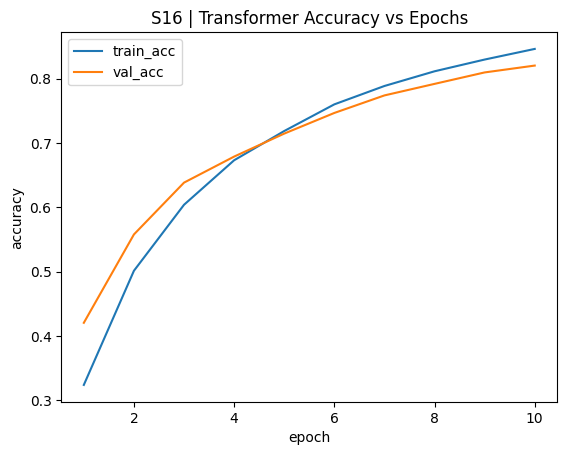


[TSMAE] Pretraining...


Pretrain epoch 1/10 | time=5.35s | loss=1.0036


Pretrain epoch 2/10 | time=5.84s | loss=1.0081


Pretrain epoch 3/10 | time=6.16s | loss=1.0141


Pretrain epoch 4/10 | time=5.22s | loss=1.0088


Pretrain epoch 5/10 | time=6.97s | loss=1.0091


Pretrain epoch 6/10 | time=5.44s | loss=0.9983


Pretrain epoch 7/10 | time=5.91s | loss=1.0011


Pretrain epoch 8/10 | time=6.28s | loss=0.9997


Pretrain epoch 9/10 | time=5.30s | loss=1.0066


Pretrain epoch 10/10 | time=6.97s | loss=1.0010
TSMAE pretrain total time (s): 59.435608863830566
[TSMAE] Fine-tuning...

--- TSMAE_finetune ---
Params total=892,681 | trainable=892,681 | size≈3.41 MB


Epoch 1/10 | time=4.78s | tr_loss=2.4222 tr_acc=0.2128 | va_loss=2.1262 va_acc=0.2947
Epoch 2/10 | time=4.81s | tr_loss=1.9630 tr_acc=0.3491 | va_loss=1.8220 va_acc=0.3850
Epoch 3/10 | time=5.51s | tr_loss=1.6313 tr_acc=0.4511 | va_loss=1.5137 va_acc=0.4882
Epoch 4/10 | time=4.71s | tr_loss=1.3292 tr_acc=0.5503 | va_loss=1.2649 va_acc=0.5711
Epoch 5/10 | time=5.37s | tr_loss=1.0773 tr_acc=0.6347 | va_loss=1.0695 va_acc=0.6371
Epoch 6/10 | time=4.92s | tr_loss=0.8613 tr_acc=0.7069 | va_loss=0.8994 va_acc=0.6902
Epoch 7/10 | time=4.65s | tr_loss=0.6848 tr_acc=0.7666 | va_loss=0.7843 va_acc=0.7353
Epoch 8/10 | time=5.60s | tr_loss=0.5646 tr_acc=0.8085 | va_loss=0.6949 va_acc=0.7737
Epoch 9/10 | time=4.69s | tr_loss=0.4623 tr_acc=0.8437 | va_loss=0.5813 va_acc=0.8081
Epoch 10/10 | time=4.97s | tr_loss=0.3983 tr_acc=0.8656 | va_loss=0.5107 va_acc=0.8328
TEST: acc=0.0463, precision=0.0594, recall=0.0451, f1=0.0406
Train time: per-epoch mean=5.00s | total=50.00s
Confusion matrix shape: (17, 1

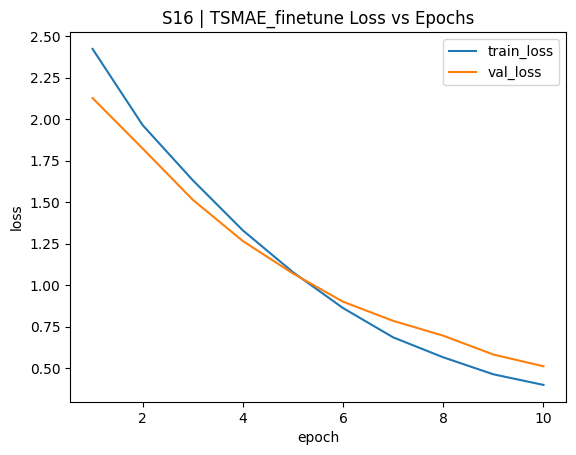

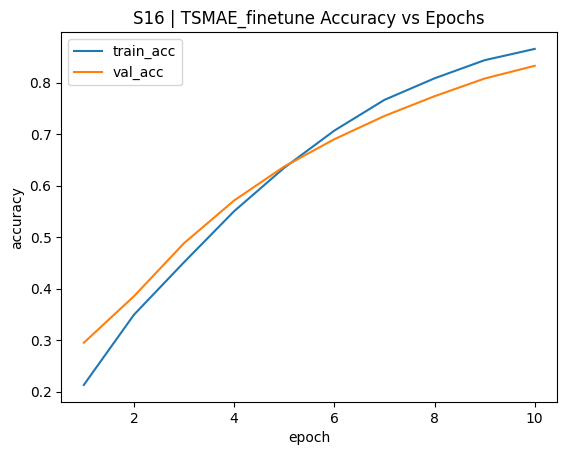


LOSO TEST SUBJECT: S17

--- CNN ---
Params total=232,273 | trainable=232,273 | size≈0.89 MB
Epoch 1/10 | time=2.78s | tr_loss=2.2283 tr_acc=0.2739 | va_loss=2.0486 va_acc=0.3263
Epoch 2/10 | time=2.61s | tr_loss=1.8799 tr_acc=0.3763 | va_loss=1.8383 va_acc=0.3832
Epoch 3/10 | time=2.59s | tr_loss=1.6942 tr_acc=0.4383 | va_loss=1.8482 va_acc=0.3935
Epoch 4/10 | time=2.74s | tr_loss=1.5395 tr_acc=0.4874 | va_loss=1.7066 va_acc=0.4336
Epoch 5/10 | time=3.39s | tr_loss=1.4270 tr_acc=0.5254 | va_loss=1.6122 va_acc=0.4505
Epoch 6/10 | time=2.61s | tr_loss=1.3177 tr_acc=0.5604 | va_loss=1.5003 va_acc=0.5030
Epoch 7/10 | time=2.63s | tr_loss=1.2349 tr_acc=0.5889 | va_loss=1.4489 va_acc=0.5134
Epoch 8/10 | time=2.60s | tr_loss=1.1472 tr_acc=0.6178 | va_loss=1.3141 va_acc=0.5596
Epoch 9/10 | time=2.98s | tr_loss=1.0824 tr_acc=0.6397 | va_loss=1.3507 va_acc=0.5367
Epoch 10/10 | time=3.17s | tr_loss=1.0293 tr_acc=0.6589 | va_loss=1.1978 va_acc=0.5901
TEST: acc=0.1381, precision=0.1977, recall=0.1

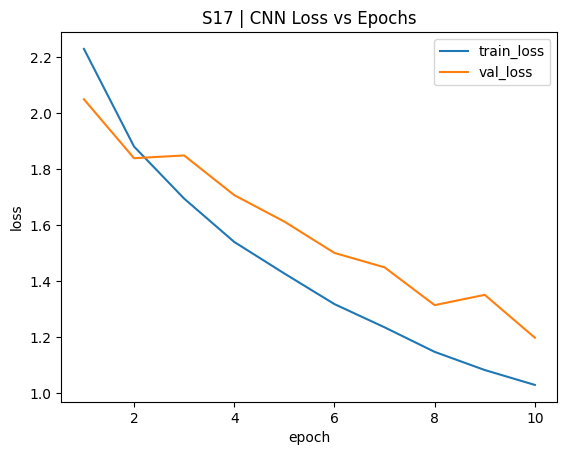

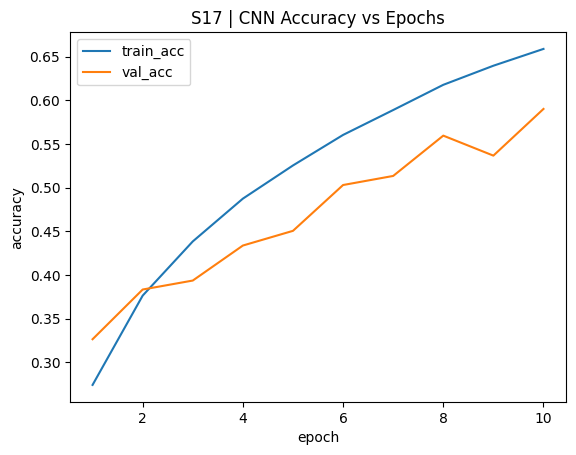


--- BiLSTM ---
Params total=545,041 | trainable=545,041 | size≈2.08 MB
Epoch 1/10 | time=12.25s | tr_loss=2.4609 tr_acc=0.1958 | va_loss=2.2252 va_acc=0.2632
Epoch 2/10 | time=12.36s | tr_loss=2.1068 tr_acc=0.2996 | va_loss=2.0165 va_acc=0.3309
Epoch 3/10 | time=12.39s | tr_loss=1.9017 tr_acc=0.3634 | va_loss=1.8323 va_acc=0.3847
Epoch 4/10 | time=12.44s | tr_loss=1.7172 tr_acc=0.4265 | va_loss=1.7097 va_acc=0.4255
Epoch 5/10 | time=12.39s | tr_loss=1.5441 tr_acc=0.4816 | va_loss=1.5176 va_acc=0.4905
Epoch 6/10 | time=12.32s | tr_loss=1.3957 tr_acc=0.5287 | va_loss=1.3921 va_acc=0.5269
Epoch 7/10 | time=12.24s | tr_loss=1.2595 tr_acc=0.5742 | va_loss=1.2269 va_acc=0.5788
Epoch 8/10 | time=12.24s | tr_loss=1.1390 tr_acc=0.6113 | va_loss=1.1200 va_acc=0.6169
Epoch 9/10 | time=12.23s | tr_loss=1.0168 tr_acc=0.6532 | va_loss=1.0123 va_acc=0.6535
Epoch 10/10 | time=12.23s | tr_loss=0.9104 tr_acc=0.6875 | va_loss=0.9476 va_acc=0.6735
TEST: acc=0.1017, precision=0.1417, recall=0.1080, f1=0.0

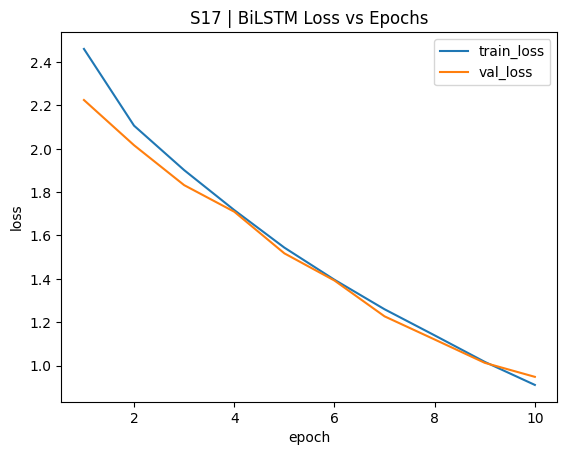

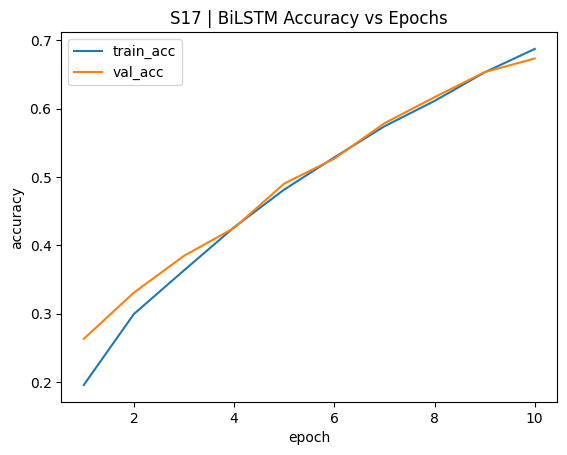


--- Transformer ---
Params total=797,201 | trainable=797,201 | size≈3.04 MB
Epoch 1/10 | time=22.99s | tr_loss=2.0642 tr_acc=0.3199 | va_loss=1.7216 va_acc=0.4262
Epoch 2/10 | time=23.05s | tr_loss=1.5161 tr_acc=0.4857 | va_loss=1.3273 va_acc=0.5362
Epoch 3/10 | time=23.14s | tr_loss=1.1953 tr_acc=0.5879 | va_loss=1.0941 va_acc=0.6190
Epoch 4/10 | time=23.12s | tr_loss=0.9796 tr_acc=0.6610 | va_loss=0.9312 va_acc=0.6721
Epoch 5/10 | time=23.03s | tr_loss=0.8294 tr_acc=0.7080 | va_loss=0.7983 va_acc=0.7146
Epoch 6/10 | time=23.01s | tr_loss=0.7149 tr_acc=0.7475 | va_loss=0.7453 va_acc=0.7403
Epoch 7/10 | time=23.16s | tr_loss=0.6289 tr_acc=0.7771 | va_loss=0.6526 va_acc=0.7691
Epoch 8/10 | time=23.07s | tr_loss=0.5583 tr_acc=0.8003 | va_loss=0.6166 va_acc=0.7808
Epoch 9/10 | time=23.08s | tr_loss=0.5031 tr_acc=0.8210 | va_loss=0.5619 va_acc=0.8003
Epoch 10/10 | time=23.12s | tr_loss=0.4555 tr_acc=0.8372 | va_loss=0.5146 va_acc=0.8133
TEST: acc=0.1409, precision=0.1364, recall=0.1495, f

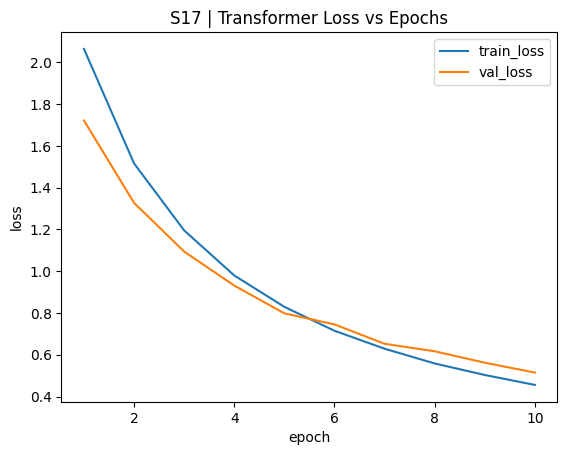

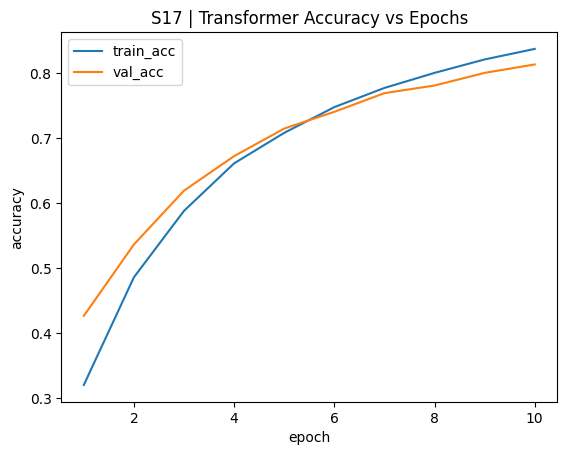


[TSMAE] Pretraining...


Pretrain epoch 1/10 | time=5.30s | loss=1.0181


Pretrain epoch 2/10 | time=6.96s | loss=1.0109


Pretrain epoch 3/10 | time=5.42s | loss=1.0125


Pretrain epoch 4/10 | time=6.62s | loss=1.0150


Pretrain epoch 5/10 | time=6.05s | loss=1.0188


Pretrain epoch 6/10 | time=5.33s | loss=1.0182


Pretrain epoch 7/10 | time=7.24s | loss=1.0140


Pretrain epoch 8/10 | time=5.34s | loss=1.0097


Pretrain epoch 9/10 | time=6.52s | loss=1.0125


Pretrain epoch 10/10 | time=6.23s | loss=1.0123
TSMAE pretrain total time (s): 61.011927127838135
[TSMAE] Fine-tuning...

--- TSMAE_finetune ---
Params total=892,681 | trainable=892,681 | size≈3.41 MB


Epoch 1/10 | time=4.73s | tr_loss=2.3747 tr_acc=0.2248 | va_loss=2.1346 va_acc=0.2899
Epoch 2/10 | time=5.67s | tr_loss=1.9734 tr_acc=0.3443 | va_loss=1.8164 va_acc=0.3924
Epoch 3/10 | time=4.63s | tr_loss=1.6657 tr_acc=0.4459 | va_loss=1.5748 va_acc=0.4777
Epoch 4/10 | time=4.97s | tr_loss=1.3707 tr_acc=0.5440 | va_loss=1.3331 va_acc=0.5567
Epoch 5/10 | time=5.39s | tr_loss=1.1117 tr_acc=0.6261 | va_loss=1.1358 va_acc=0.6249
Epoch 6/10 | time=4.64s | tr_loss=0.8806 tr_acc=0.7046 | va_loss=0.9651 va_acc=0.6804
Epoch 7/10 | time=5.58s | tr_loss=0.6944 tr_acc=0.7656 | va_loss=0.7947 va_acc=0.7374
Epoch 8/10 | time=4.61s | tr_loss=0.5658 tr_acc=0.8096 | va_loss=0.7158 va_acc=0.7717
Epoch 9/10 | time=4.59s | tr_loss=0.4650 tr_acc=0.8439 | va_loss=0.6279 va_acc=0.7987
Epoch 10/10 | time=5.59s | tr_loss=0.3962 tr_acc=0.8670 | va_loss=0.5722 va_acc=0.8175
TEST: acc=0.0914, precision=0.1205, recall=0.0948, f1=0.0901
Train time: per-epoch mean=5.04s | total=50.40s
Confusion matrix shape: (17, 1

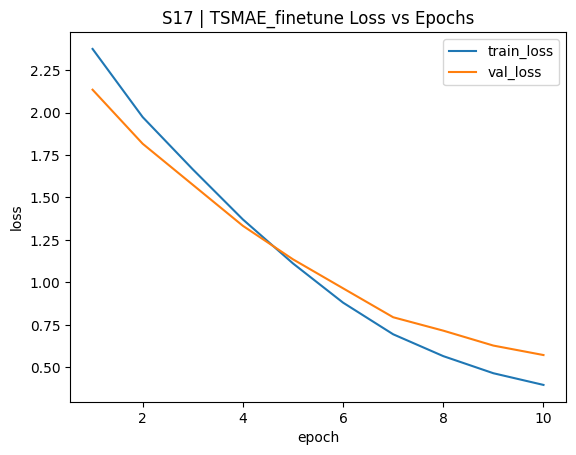

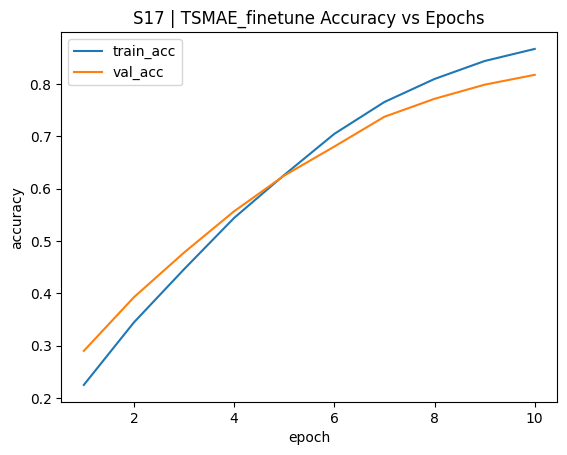


LOSO TEST SUBJECT: S18

--- CNN ---
Params total=232,273 | trainable=232,273 | size≈0.89 MB
Epoch 1/10 | time=3.24s | tr_loss=2.2651 tr_acc=0.2672 | va_loss=2.1295 va_acc=0.3012
Epoch 2/10 | time=3.16s | tr_loss=1.9154 tr_acc=0.3738 | va_loss=1.8449 va_acc=0.3871
Epoch 3/10 | time=3.99s | tr_loss=1.7130 tr_acc=0.4341 | va_loss=1.8032 va_acc=0.3901
Epoch 4/10 | time=3.09s | tr_loss=1.5448 tr_acc=0.4903 | va_loss=1.6152 va_acc=0.4649
Epoch 5/10 | time=3.10s | tr_loss=1.4253 tr_acc=0.5300 | va_loss=1.6463 va_acc=0.4584
Epoch 6/10 | time=3.08s | tr_loss=1.3210 tr_acc=0.5652 | va_loss=1.4864 va_acc=0.5176
Epoch 7/10 | time=3.99s | tr_loss=1.2287 tr_acc=0.5939 | va_loss=1.4628 va_acc=0.5105
Epoch 8/10 | time=3.12s | tr_loss=1.1484 tr_acc=0.6188 | va_loss=1.4130 va_acc=0.5259
Epoch 9/10 | time=3.14s | tr_loss=1.0848 tr_acc=0.6416 | va_loss=1.4586 va_acc=0.5189
Epoch 10/10 | time=3.17s | tr_loss=1.0231 tr_acc=0.6604 | va_loss=1.2890 va_acc=0.5726
TEST: acc=0.2619, precision=0.2862, recall=0.2

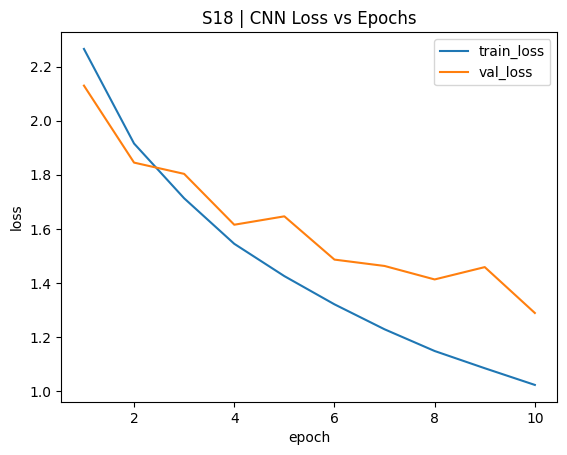

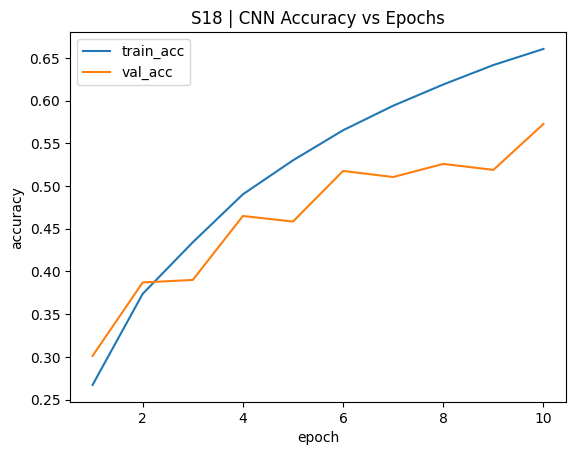


--- BiLSTM ---
Params total=545,041 | trainable=545,041 | size≈2.08 MB
Epoch 1/10 | time=12.79s | tr_loss=2.5138 tr_acc=0.1845 | va_loss=2.2905 va_acc=0.2521
Epoch 2/10 | time=12.70s | tr_loss=2.1564 tr_acc=0.2865 | va_loss=2.0281 va_acc=0.3226
Epoch 3/10 | time=12.76s | tr_loss=1.9117 tr_acc=0.3621 | va_loss=1.8134 va_acc=0.3988
Epoch 4/10 | time=12.72s | tr_loss=1.6832 tr_acc=0.4370 | va_loss=1.5930 va_acc=0.4686
Epoch 5/10 | time=12.84s | tr_loss=1.4873 tr_acc=0.4995 | va_loss=1.4334 va_acc=0.5176
Epoch 6/10 | time=12.74s | tr_loss=1.3268 tr_acc=0.5532 | va_loss=1.2909 va_acc=0.5657
Epoch 7/10 | time=12.72s | tr_loss=1.1877 tr_acc=0.5982 | va_loss=1.1682 va_acc=0.6055
Epoch 8/10 | time=12.75s | tr_loss=1.0586 tr_acc=0.6421 | va_loss=1.0563 va_acc=0.6419
Epoch 9/10 | time=12.72s | tr_loss=0.9514 tr_acc=0.6774 | va_loss=0.9517 va_acc=0.6694
Epoch 10/10 | time=12.94s | tr_loss=0.8413 tr_acc=0.7125 | va_loss=0.8553 va_acc=0.7044
TEST: acc=0.1894, precision=0.2777, recall=0.2197, f1=0.2

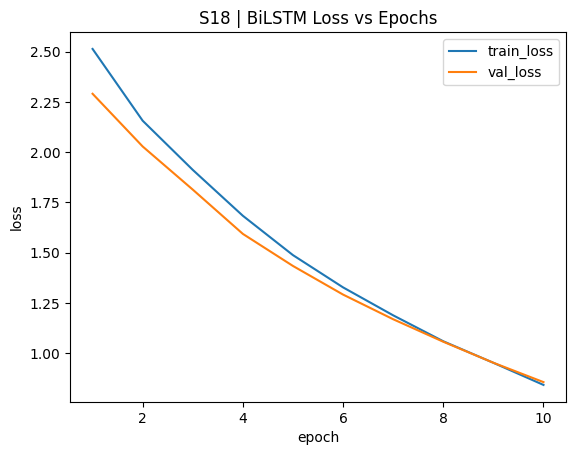

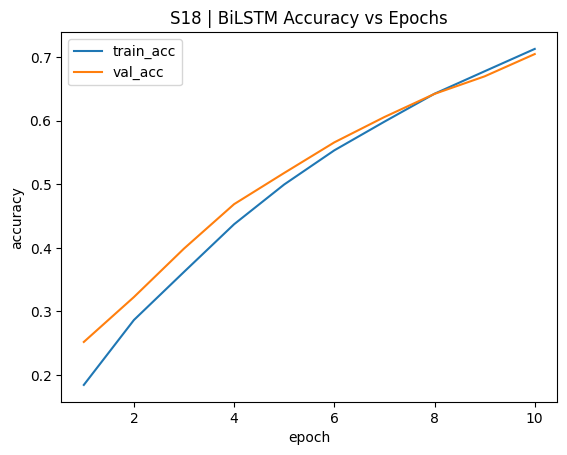


--- Transformer ---
Params total=797,201 | trainable=797,201 | size≈3.04 MB
Epoch 1/10 | time=23.98s | tr_loss=2.0924 tr_acc=0.3153 | va_loss=1.7086 va_acc=0.4283
Epoch 2/10 | time=23.58s | tr_loss=1.4898 tr_acc=0.4940 | va_loss=1.3034 va_acc=0.5603
Epoch 3/10 | time=23.80s | tr_loss=1.1555 tr_acc=0.5991 | va_loss=1.0629 va_acc=0.6311
Epoch 4/10 | time=24.26s | tr_loss=0.9363 tr_acc=0.6720 | va_loss=0.8995 va_acc=0.6855
Epoch 5/10 | time=24.04s | tr_loss=0.7961 tr_acc=0.7163 | va_loss=0.7632 va_acc=0.7314
Epoch 6/10 | time=24.27s | tr_loss=0.6878 tr_acc=0.7546 | va_loss=0.6989 va_acc=0.7493
Epoch 7/10 | time=24.05s | tr_loss=0.6111 tr_acc=0.7807 | va_loss=0.6178 va_acc=0.7803
Epoch 8/10 | time=24.03s | tr_loss=0.5376 tr_acc=0.8065 | va_loss=0.5861 va_acc=0.7889
Epoch 9/10 | time=24.36s | tr_loss=0.4834 tr_acc=0.8263 | va_loss=0.5773 va_acc=0.8012
Epoch 10/10 | time=24.52s | tr_loss=0.4388 tr_acc=0.8411 | va_loss=0.5105 va_acc=0.8239
TEST: acc=0.2106, precision=0.2648, recall=0.2302, f

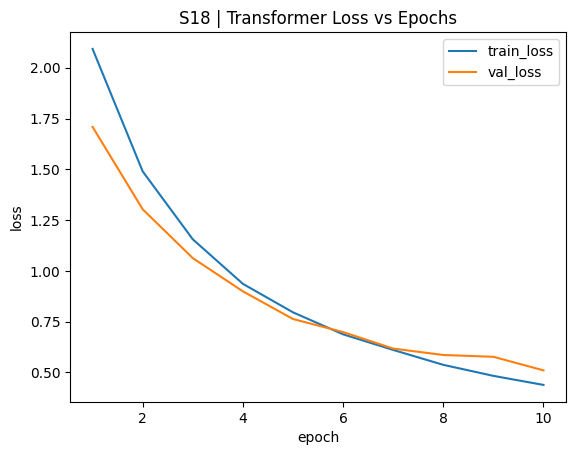

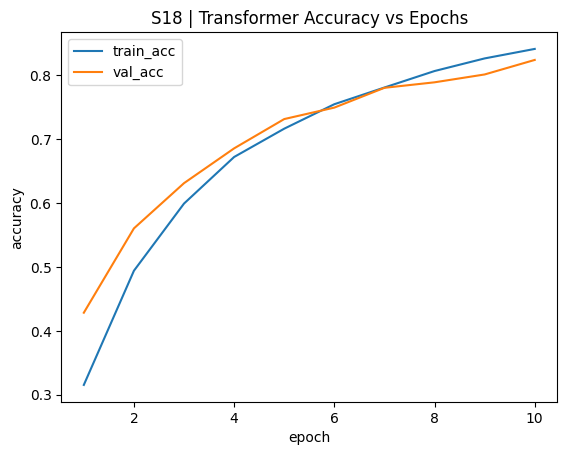


[TSMAE] Pretraining...


Pretrain epoch 1/10 | time=5.47s | loss=1.0258


Pretrain epoch 2/10 | time=6.20s | loss=1.0238


Pretrain epoch 3/10 | time=6.61s | loss=1.0133


Pretrain epoch 4/10 | time=5.74s | loss=1.0103


Pretrain epoch 5/10 | time=7.04s | loss=1.0198


Pretrain epoch 6/10 | time=5.62s | loss=1.0227


Pretrain epoch 7/10 | time=6.91s | loss=1.0165


Pretrain epoch 8/10 | time=6.10s | loss=1.0147


Pretrain epoch 9/10 | time=5.54s | loss=1.0153


Pretrain epoch 10/10 | time=6.56s | loss=1.0217
TSMAE pretrain total time (s): 61.78079152107239
[TSMAE] Fine-tuning...

--- TSMAE_finetune ---
Params total=892,681 | trainable=892,681 | size≈3.41 MB


Epoch 1/10 | time=5.18s | tr_loss=2.4237 tr_acc=0.2149 | va_loss=2.1848 va_acc=0.2766
Epoch 2/10 | time=5.05s | tr_loss=2.0110 tr_acc=0.3375 | va_loss=1.8695 va_acc=0.3880
Epoch 3/10 | time=5.43s | tr_loss=1.6911 tr_acc=0.4379 | va_loss=1.6000 va_acc=0.4739
Epoch 4/10 | time=4.78s | tr_loss=1.3862 tr_acc=0.5368 | va_loss=1.3620 va_acc=0.5475
Epoch 5/10 | time=5.61s | tr_loss=1.1139 tr_acc=0.6248 | va_loss=1.1513 va_acc=0.6132
Epoch 6/10 | time=4.69s | tr_loss=0.8908 tr_acc=0.6990 | va_loss=0.9570 va_acc=0.6821
Epoch 7/10 | time=4.72s | tr_loss=0.7176 tr_acc=0.7582 | va_loss=0.8071 va_acc=0.7273
Epoch 8/10 | time=5.61s | tr_loss=0.5806 tr_acc=0.8048 | va_loss=0.6915 va_acc=0.7755
Epoch 9/10 | time=4.71s | tr_loss=0.4714 tr_acc=0.8413 | va_loss=0.6356 va_acc=0.7933
Epoch 10/10 | time=5.45s | tr_loss=0.4032 tr_acc=0.8634 | va_loss=0.5385 va_acc=0.8268
TEST: acc=0.1899, precision=0.2215, recall=0.2117, f1=0.1897
Train time: per-epoch mean=5.12s | total=51.23s
Confusion matrix shape: (17, 1

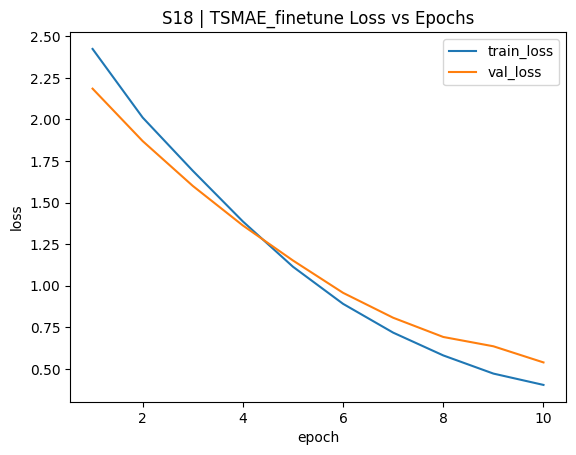

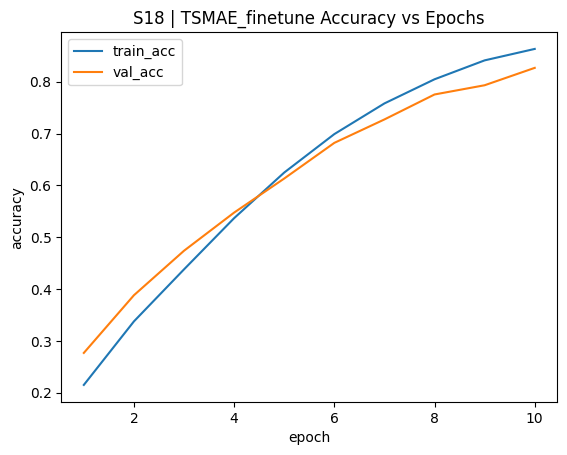


LOSO TEST SUBJECT: S19

--- CNN ---
Params total=232,273 | trainable=232,273 | size≈0.89 MB
Epoch 1/10 | time=2.77s | tr_loss=2.2503 tr_acc=0.2744 | va_loss=2.0601 va_acc=0.3309
Epoch 2/10 | time=2.75s | tr_loss=1.9035 tr_acc=0.3783 | va_loss=1.9013 va_acc=0.3783
Epoch 3/10 | time=2.72s | tr_loss=1.7016 tr_acc=0.4420 | va_loss=1.7556 va_acc=0.4207
Epoch 4/10 | time=3.39s | tr_loss=1.5507 tr_acc=0.4903 | va_loss=1.6379 va_acc=0.4519
Epoch 5/10 | time=2.94s | tr_loss=1.4217 tr_acc=0.5307 | va_loss=1.6522 va_acc=0.4594
Epoch 6/10 | time=2.72s | tr_loss=1.3160 tr_acc=0.5658 | va_loss=1.5366 va_acc=0.4866
Epoch 7/10 | time=2.68s | tr_loss=1.2258 tr_acc=0.5956 | va_loss=1.4785 va_acc=0.5075
Epoch 8/10 | time=2.75s | tr_loss=1.1464 tr_acc=0.6207 | va_loss=1.6010 va_acc=0.4802
Epoch 9/10 | time=3.54s | tr_loss=1.0730 tr_acc=0.6453 | va_loss=1.2630 va_acc=0.5773
Epoch 10/10 | time=2.72s | tr_loss=1.0153 tr_acc=0.6648 | va_loss=1.4203 va_acc=0.5205
TEST: acc=0.1496, precision=0.2487, recall=0.1

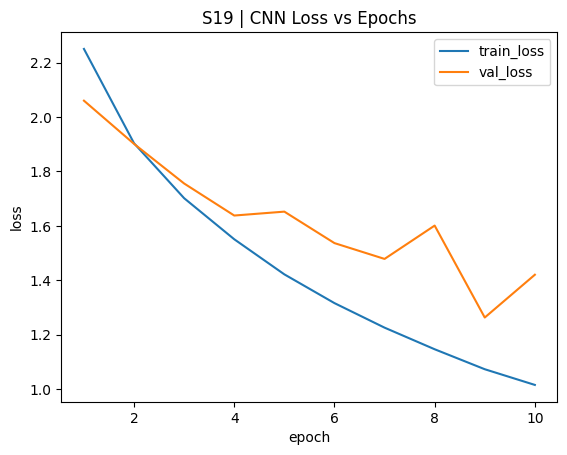

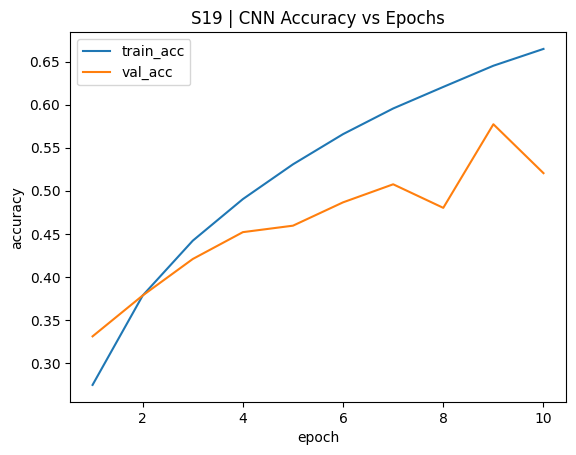


--- BiLSTM ---
Params total=545,041 | trainable=545,041 | size≈2.08 MB
Epoch 1/10 | time=12.33s | tr_loss=2.4943 tr_acc=0.1918 | va_loss=2.2596 va_acc=0.2627
Epoch 2/10 | time=12.34s | tr_loss=2.1512 tr_acc=0.2891 | va_loss=2.0219 va_acc=0.3288
Epoch 3/10 | time=12.32s | tr_loss=1.9183 tr_acc=0.3582 | va_loss=1.8154 va_acc=0.3934
Epoch 4/10 | time=12.32s | tr_loss=1.7032 tr_acc=0.4269 | va_loss=1.6113 va_acc=0.4530
Epoch 5/10 | time=12.44s | tr_loss=1.5180 tr_acc=0.4893 | va_loss=1.4464 va_acc=0.5105
Epoch 6/10 | time=12.47s | tr_loss=1.3476 tr_acc=0.5440 | va_loss=1.3172 va_acc=0.5616
Epoch 7/10 | time=12.60s | tr_loss=1.1866 tr_acc=0.5971 | va_loss=1.1862 va_acc=0.5932
Epoch 8/10 | time=12.52s | tr_loss=1.0570 tr_acc=0.6406 | va_loss=1.0644 va_acc=0.6333
Epoch 9/10 | time=12.46s | tr_loss=0.9429 tr_acc=0.6792 | va_loss=0.9836 va_acc=0.6614
Epoch 10/10 | time=12.36s | tr_loss=0.8452 tr_acc=0.7105 | va_loss=0.8922 va_acc=0.6913
TEST: acc=0.1649, precision=0.1928, recall=0.1751, f1=0.1

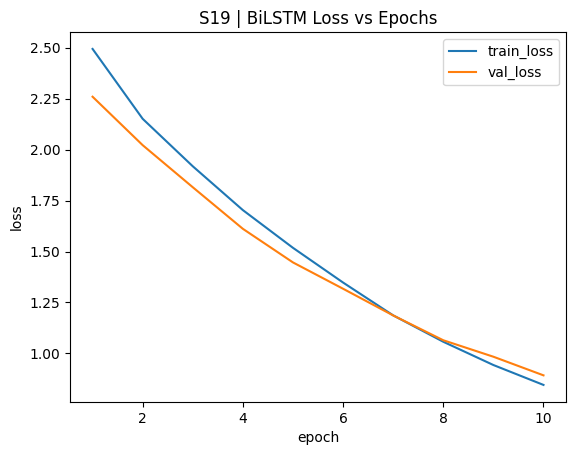

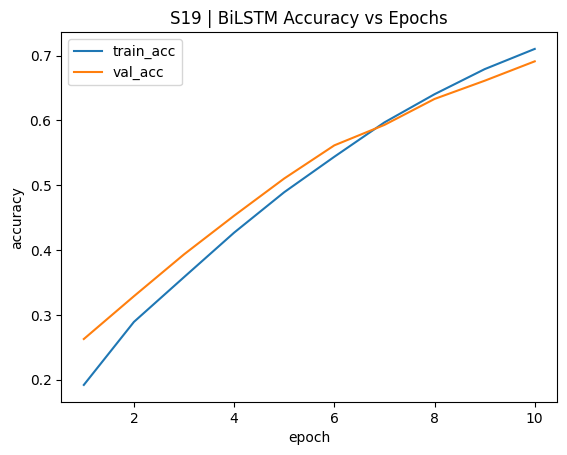


--- Transformer ---
Params total=797,201 | trainable=797,201 | size≈3.04 MB
Epoch 1/10 | time=23.24s | tr_loss=2.0894 tr_acc=0.3146 | va_loss=1.6879 va_acc=0.4336
Epoch 2/10 | time=23.23s | tr_loss=1.4829 tr_acc=0.4953 | va_loss=1.2739 va_acc=0.5618
Epoch 3/10 | time=23.24s | tr_loss=1.1515 tr_acc=0.6022 | va_loss=1.0869 va_acc=0.6197
Epoch 4/10 | time=23.31s | tr_loss=0.9420 tr_acc=0.6695 | va_loss=0.8831 va_acc=0.6927
Epoch 5/10 | time=23.27s | tr_loss=0.7961 tr_acc=0.7180 | va_loss=0.7920 va_acc=0.7246
Epoch 6/10 | time=23.18s | tr_loss=0.6876 tr_acc=0.7562 | va_loss=0.6959 va_acc=0.7515
Epoch 7/10 | time=23.19s | tr_loss=0.6070 tr_acc=0.7833 | va_loss=0.6374 va_acc=0.7761
Epoch 8/10 | time=23.27s | tr_loss=0.5456 tr_acc=0.8053 | va_loss=0.6054 va_acc=0.7791
Epoch 9/10 | time=23.20s | tr_loss=0.4833 tr_acc=0.8266 | va_loss=0.5674 va_acc=0.7952
Epoch 10/10 | time=23.27s | tr_loss=0.4430 tr_acc=0.8410 | va_loss=0.5392 va_acc=0.8153
TEST: acc=0.1941, precision=0.2588, recall=0.2055, f

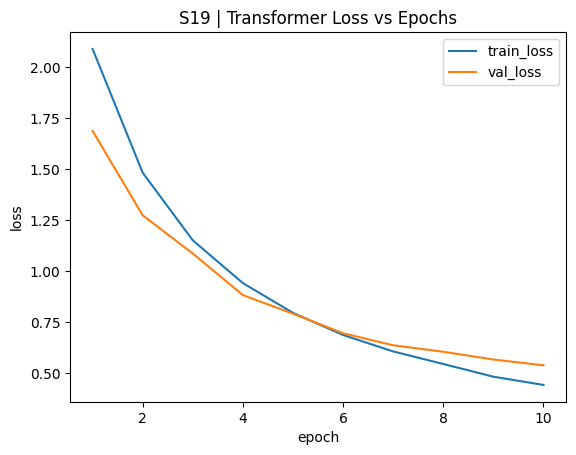

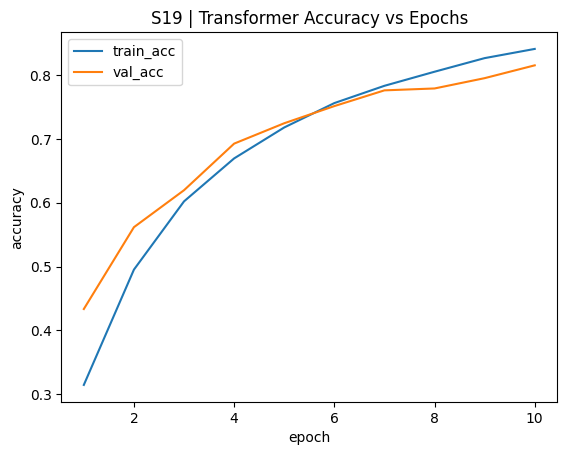


[TSMAE] Pretraining...


Pretrain epoch 1/10 | time=7.43s | loss=1.0118


Pretrain epoch 2/10 | time=5.64s | loss=1.0078


Pretrain epoch 3/10 | time=6.84s | loss=1.0132


Pretrain epoch 4/10 | time=6.26s | loss=1.0034


Pretrain epoch 5/10 | time=5.61s | loss=1.0110


Pretrain epoch 6/10 | time=6.92s | loss=1.0150


Pretrain epoch 7/10 | time=5.64s | loss=1.0029


Pretrain epoch 8/10 | time=7.77s | loss=1.0027


Pretrain epoch 9/10 | time=5.62s | loss=1.0051


Pretrain epoch 10/10 | time=6.62s | loss=1.0087
TSMAE pretrain total time (s): 64.35145950317383
[TSMAE] Fine-tuning...

--- TSMAE_finetune ---
Params total=892,681 | trainable=892,681 | size≈3.41 MB
Epoch 1/10 | time=5.34s | tr_loss=2.4001 tr_acc=0.2223 | va_loss=2.1179 va_acc=0.2999
Epoch 2/10 | time=4.73s | tr_loss=1.9731 tr_acc=0.3459 | va_loss=1.7929 va_acc=0.4064
Epoch 3/10 | time=5.61s | tr_loss=1.6456 tr_acc=0.4527 | va_loss=1.5328 va_acc=0.4899
Epoch 4/10 | time=4.74s | tr_loss=1.3404 tr_acc=0.5506 | va_loss=1.2886 va_acc=0.5761
Epoch 5/10 | time=4.83s | tr_loss=1.0710 tr_acc=0.6401 | va_loss=1.0987 va_acc=0.6383
Epoch 6/10 | time=5.53s | tr_loss=0.8479 tr_acc=0.7146 | va_loss=0.8908 va_acc=0.7039
Epoch 7/10 | time=4.68s | tr_loss=0.6790 tr_acc=0.7712 | va_loss=0.7634 va_acc=0.7510
Epoch 8/10 | time=5.44s | tr_loss=0.5467 tr_acc=0.8155 | va_loss=0.6702 va_acc=0.7867
Epoch 9/10 | time=4.91s | tr_loss=0.4535 tr_acc=0.8471 | va_loss=0.6063 va_acc=0.8063
Epoch 10/10 | time=4.62s |

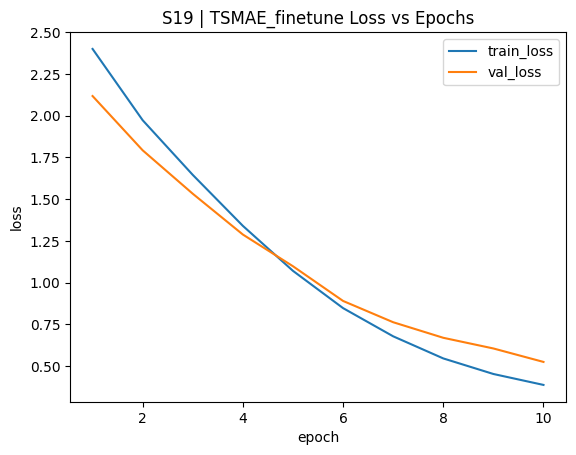

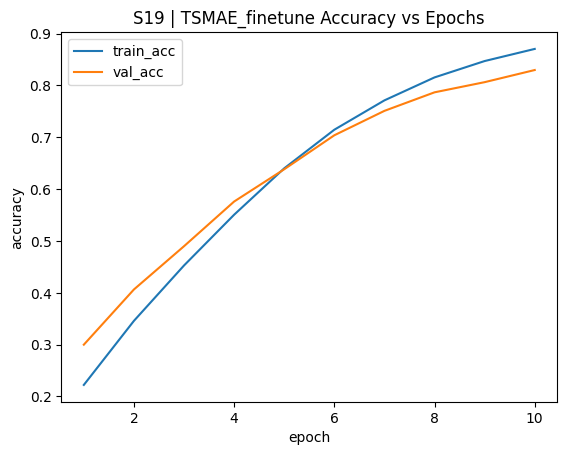


LOSO TEST SUBJECT: S20

--- CNN ---
Params total=232,273 | trainable=232,273 | size≈0.89 MB
Epoch 1/10 | time=3.39s | tr_loss=2.2444 tr_acc=0.2700 | va_loss=2.0926 va_acc=0.3155
Epoch 2/10 | time=2.75s | tr_loss=1.9069 tr_acc=0.3709 | va_loss=1.9327 va_acc=0.3550
Epoch 3/10 | time=2.67s | tr_loss=1.7088 tr_acc=0.4365 | va_loss=1.6981 va_acc=0.4360
Epoch 4/10 | time=2.70s | tr_loss=1.5425 tr_acc=0.4898 | va_loss=1.7094 va_acc=0.4407
Epoch 5/10 | time=3.28s | tr_loss=1.4209 tr_acc=0.5289 | va_loss=1.8813 va_acc=0.4056
Epoch 6/10 | time=2.90s | tr_loss=1.3189 tr_acc=0.5631 | va_loss=1.6175 va_acc=0.4659
Epoch 7/10 | time=2.69s | tr_loss=1.2192 tr_acc=0.5944 | va_loss=1.4251 va_acc=0.5283
Epoch 8/10 | time=2.69s | tr_loss=1.1376 tr_acc=0.6228 | va_loss=1.6032 va_acc=0.4669
Epoch 9/10 | time=2.75s | tr_loss=1.0746 tr_acc=0.6429 | va_loss=1.4453 va_acc=0.5233
Epoch 10/10 | time=3.51s | tr_loss=1.0083 tr_acc=0.6665 | va_loss=1.3295 va_acc=0.5542
TEST: acc=0.1066, precision=0.1323, recall=0.1

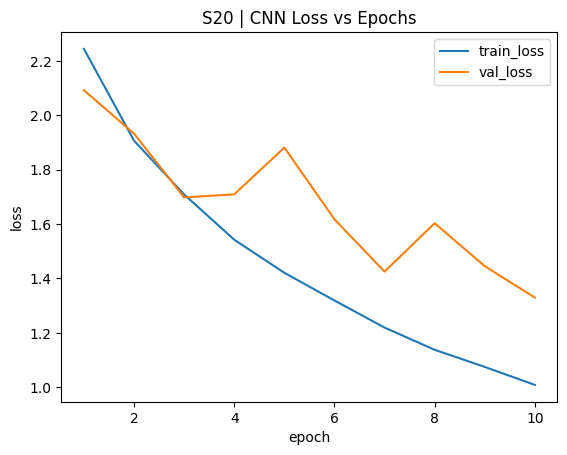

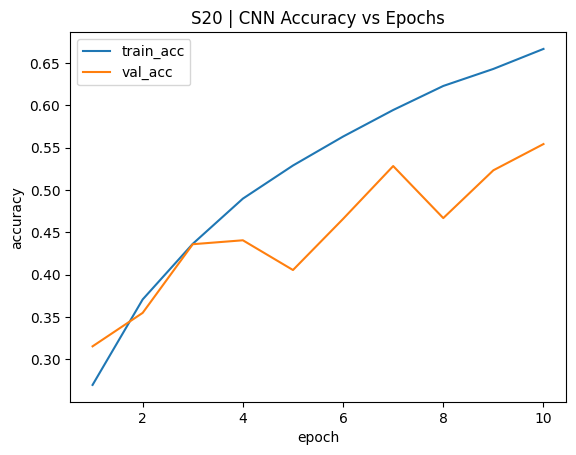


--- BiLSTM ---
Params total=545,041 | trainable=545,041 | size≈2.08 MB
Epoch 1/10 | time=12.54s | tr_loss=2.4628 tr_acc=0.1982 | va_loss=2.2300 va_acc=0.2712
Epoch 2/10 | time=12.59s | tr_loss=2.1027 tr_acc=0.3038 | va_loss=1.9906 va_acc=0.3402
Epoch 3/10 | time=12.63s | tr_loss=1.8781 tr_acc=0.3729 | va_loss=1.8048 va_acc=0.4024
Epoch 4/10 | time=12.68s | tr_loss=1.6763 tr_acc=0.4370 | va_loss=1.7087 va_acc=0.4297
Epoch 5/10 | time=12.61s | tr_loss=1.5068 tr_acc=0.4929 | va_loss=1.4704 va_acc=0.5147
Epoch 6/10 | time=12.63s | tr_loss=1.3492 tr_acc=0.5431 | va_loss=1.3212 va_acc=0.5638
Epoch 7/10 | time=12.56s | tr_loss=1.1922 tr_acc=0.5951 | va_loss=1.2145 va_acc=0.5939
Epoch 8/10 | time=12.51s | tr_loss=1.0692 tr_acc=0.6353 | va_loss=1.0660 va_acc=0.6422
Epoch 9/10 | time=12.44s | tr_loss=0.9568 tr_acc=0.6721 | va_loss=1.0225 va_acc=0.6561
Epoch 10/10 | time=12.44s | tr_loss=0.8585 tr_acc=0.7048 | va_loss=0.9347 va_acc=0.6846
TEST: acc=0.1235, precision=0.1150, recall=0.1152, f1=0.0

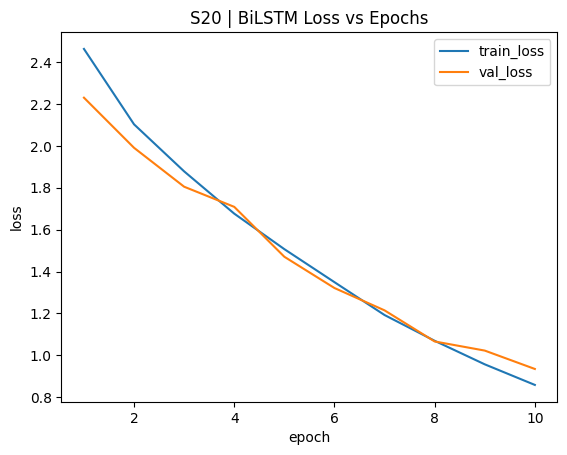

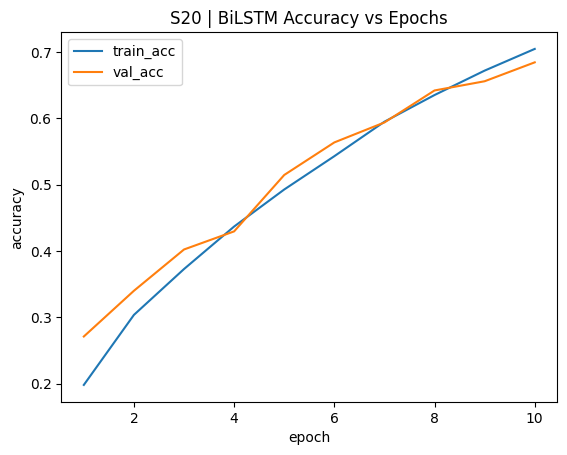


--- Transformer ---
Params total=797,201 | trainable=797,201 | size≈3.04 MB
Epoch 1/10 | time=23.36s | tr_loss=2.1032 tr_acc=0.3123 | va_loss=1.7074 va_acc=0.4380
Epoch 2/10 | time=23.41s | tr_loss=1.5196 tr_acc=0.4826 | va_loss=1.3093 va_acc=0.5515
Epoch 3/10 | time=23.40s | tr_loss=1.1838 tr_acc=0.5892 | va_loss=1.0788 va_acc=0.6221
Epoch 4/10 | time=23.48s | tr_loss=0.9679 tr_acc=0.6606 | va_loss=0.9058 va_acc=0.6819
Epoch 5/10 | time=23.47s | tr_loss=0.8115 tr_acc=0.7138 | va_loss=0.8607 va_acc=0.7010
Epoch 6/10 | time=23.42s | tr_loss=0.7016 tr_acc=0.7519 | va_loss=0.7261 va_acc=0.7500
Epoch 7/10 | time=23.40s | tr_loss=0.6114 tr_acc=0.7815 | va_loss=0.6629 va_acc=0.7651
Epoch 8/10 | time=23.38s | tr_loss=0.5444 tr_acc=0.8056 | va_loss=0.6154 va_acc=0.7830
Epoch 9/10 | time=23.49s | tr_loss=0.4819 tr_acc=0.8271 | va_loss=0.5662 va_acc=0.8006
Epoch 10/10 | time=23.42s | tr_loss=0.4364 tr_acc=0.8437 | va_loss=0.5615 va_acc=0.8088
TEST: acc=0.1250, precision=0.0715, recall=0.1173, f

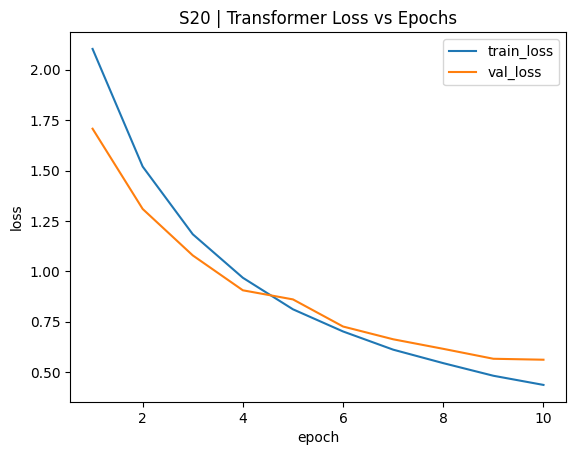

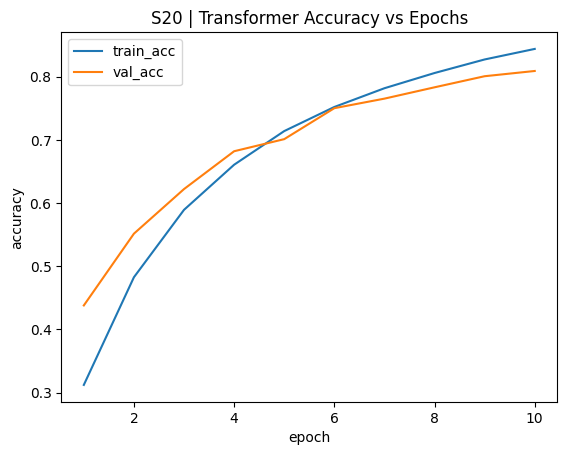


[TSMAE] Pretraining...


Pretrain epoch 1/10 | time=7.21s | loss=1.0315


Pretrain epoch 2/10 | time=5.70s | loss=1.0260


Pretrain epoch 3/10 | time=7.09s | loss=1.0168


Pretrain epoch 4/10 | time=5.86s | loss=1.0311


Pretrain epoch 5/10 | time=5.70s | loss=1.0256


Pretrain epoch 6/10 | time=7.27s | loss=1.0249


Pretrain epoch 7/10 | time=5.68s | loss=1.0257


Pretrain epoch 8/10 | time=7.26s | loss=1.0273


Pretrain epoch 9/10 | time=5.54s | loss=1.0253


Pretrain epoch 10/10 | time=6.47s | loss=1.0299
TSMAE pretrain total time (s): 63.77464699745178
[TSMAE] Fine-tuning...

--- TSMAE_finetune ---
Params total=892,681 | trainable=892,681 | size≈3.41 MB


Epoch 1/10 | time=5.33s | tr_loss=2.3973 tr_acc=0.2217 | va_loss=2.1753 va_acc=0.2904
Epoch 2/10 | time=4.69s | tr_loss=1.9925 tr_acc=0.3398 | va_loss=1.8831 va_acc=0.3772
Epoch 3/10 | time=5.52s | tr_loss=1.6709 tr_acc=0.4391 | va_loss=1.6055 va_acc=0.4655
Epoch 4/10 | time=4.69s | tr_loss=1.3719 tr_acc=0.5373 | va_loss=1.3301 va_acc=0.5526
Epoch 5/10 | time=4.69s | tr_loss=1.1056 tr_acc=0.6251 | va_loss=1.1392 va_acc=0.6259
Epoch 6/10 | time=5.51s | tr_loss=0.8811 tr_acc=0.7036 | va_loss=0.9506 va_acc=0.6847
Epoch 7/10 | time=4.71s | tr_loss=0.7111 tr_acc=0.7592 | va_loss=0.8388 va_acc=0.7221
Epoch 8/10 | time=5.31s | tr_loss=0.5831 tr_acc=0.8037 | va_loss=0.6759 va_acc=0.7827
Epoch 9/10 | time=4.97s | tr_loss=0.4759 tr_acc=0.8401 | va_loss=0.6512 va_acc=0.7934
Epoch 10/10 | time=4.67s | tr_loss=0.4056 tr_acc=0.8639 | va_loss=0.5368 va_acc=0.8224
TEST: acc=0.1160, precision=0.1185, recall=0.1072, f1=0.0917
Train time: per-epoch mean=5.01s | total=50.10s
Confusion matrix shape: (17, 1

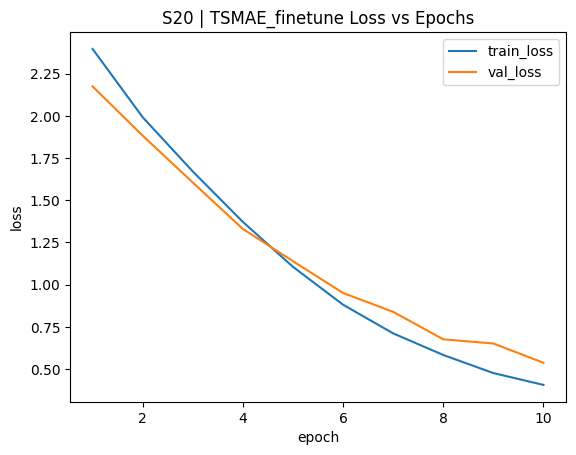

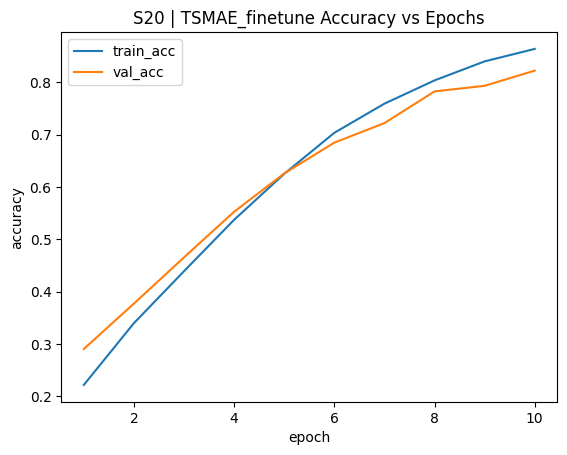


DONE LOSO (no augmentation).


In [ ]:
all_folds_results = []

for test_subj in subjects:
    print("\n" + "="*80)
    print("LOSO TEST SUBJECT:", test_subj)

    tr_loader, va_loader, te_loader, L, C = make_fold_loaders(test_subj)
    fold_out = {"test_subject": test_subj, "models": {}}

    # CNN
    res = train_one_model("CNN", CNN1D(C, n_classes), tr_loader, va_loader, te_loader, augment=False)
    fold_out["models"]["CNN"] = res
    plot_history(res["history"], title_prefix=f"{test_subj} | CNN")

    # BiLSTM
    res = train_one_model("BiLSTM", BiLSTM(C, n_classes), tr_loader, va_loader, te_loader, augment=False)
    fold_out["models"]["BiLSTM"] = res
    plot_history(res["history"], title_prefix=f"{test_subj} | BiLSTM")

    # Transformer
    res = train_one_model("Transformer", TransformerClassifier(C, n_classes, cfg.d_model, cfg.n_heads, cfg.n_layers, cfg.dropout),
                          tr_loader, va_loader, te_loader, augment=False)
    fold_out["models"]["Transformer"] = res
    plot_history(res["history"], title_prefix=f"{test_subj} | Transformer")

    # TSMAE pretrain + finetune
    tsmae = TSMAE(C, seq_len=L, patch_len=cfg.patch_len, d_model=cfg.d_model,
                 n_heads=cfg.n_heads, n_layers=cfg.n_layers,
                 dropout=cfg.dropout, mask_ratio=cfg.mask_ratio)
    tsmae.set_num_classes(n_classes)

    # pretrain data = training X only
    X_pre = tr_loader.dataset.X.numpy()
    pre_ds = WindowDataset(X_pre, y=None)
    pre_loader = DataLoader(pre_ds, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers, drop_last=True)

    print("\n[TSMAE] Pretraining...")
    pre_hist, pre_times = pretrain_tsmae(tsmae.to(device), pre_loader, cfg.tsmae_pretrain_epochs, cfg.tsmae_pretrain_lr)
    print("TSMAE pretrain total time (s):", float(np.sum(pre_times)))

    print("[TSMAE] Fine-tuning...")
    res = train_one_model("TSMAE_finetune", tsmae, tr_loader, va_loader, te_loader, augment=False)
    res["pretrain_history"] = pre_hist
    res["pretrain_epoch_times_sec"] = pre_times
    fold_out["models"]["TSMAE_finetune"] = res
    plot_history(res["history"], title_prefix=f"{test_subj} | TSMAE_finetune")

    all_folds_results.append(fold_out)

print("\nDONE LOSO (no augmentation).")

In [ ]:
def summarize(results):
    model_names = list(results[0]["models"].keys())
    print("\n===== LOSO SUMMARY (mean ± std) =====")
    for m in model_names:
        accs, precs, recs, f1s, times = [], [], [], [], []
        for fold in results:
            r = fold["models"][m]
            accs.append(r["acc"])
            precs.append(r["precision_macro"])
            recs.append(r["recall_macro"])
            f1s.append(r["f1_macro"])
            times.append(r["total_train_time_sec"])
        print(f"\nModel: {m}")
        print(f"  Acc:   {np.mean(accs):.4f} ± {np.std(accs):.4f}")
        print(f"  Prec:  {np.mean(precs):.4f} ± {np.std(precs):.4f}")
        print(f"  Recall:{np.mean(recs):.4f} ± {np.std(recs):.4f}")
        print(f"  F1:    {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
        print(f"  Train time (s): {np.mean(times):.2f} ± {np.std(times):.2f}")

summarize(all_folds_results)



===== LOSO SUMMARY (mean ± std) =====

Model: CNN
  Acc:   0.1898 ± 0.0699
  Prec:  0.2321 ± 0.0675
  Recall:0.2018 ± 0.0769
  F1:    0.1725 ± 0.0682
  Train time (s): 29.62 ± 2.25

Model: BiLSTM
  Acc:   0.1901 ± 0.0635
  Prec:  0.2156 ± 0.0684
  Recall:0.2051 ± 0.0683
  F1:    0.1756 ± 0.0662
  Train time (s): 125.07 ± 1.90

Model: Transformer
  Acc:   0.1898 ± 0.0469
  Prec:  0.2141 ± 0.0613
  Recall:0.2039 ± 0.0510
  F1:    0.1711 ± 0.0540
  Train time (s): 234.31 ± 3.50

Model: TSMAE_finetune
  Acc:   0.1715 ± 0.0550
  Prec:  0.1855 ± 0.0489
  Recall:0.1802 ± 0.0631
  F1:    0.1600 ± 0.0538
  Train time (s): 50.71 ± 1.76



LOSO TEST SUBJECT (AUG): S1

--- CNN_aug ---
Params total=232,273 | trainable=232,273 | size≈0.89 MB
Epoch 1/10 | time=5.86s | tr_loss=2.3096 tr_acc=0.2533 | va_loss=2.1635 va_acc=0.2904
Epoch 2/10 | time=7.31s | tr_loss=1.9893 tr_acc=0.3527 | va_loss=1.9094 va_acc=0.3671
Epoch 3/10 | time=4.33s | tr_loss=1.8300 tr_acc=0.4018 | va_loss=1.8216 va_acc=0.3821
Epoch 4/10 | time=4.25s | tr_loss=1.6946 tr_acc=0.4478 | va_loss=1.6837 va_acc=0.4418
Epoch 5/10 | time=3.79s | tr_loss=1.5863 tr_acc=0.4820 | va_loss=1.6309 va_acc=0.4625
Epoch 6/10 | time=3.58s | tr_loss=1.5197 tr_acc=0.5055 | va_loss=1.6133 va_acc=0.4603
Epoch 7/10 | time=3.66s | tr_loss=1.4523 tr_acc=0.5301 | va_loss=1.4281 va_acc=0.5137
Epoch 8/10 | time=4.18s | tr_loss=1.4047 tr_acc=0.5457 | va_loss=1.4945 va_acc=0.4993
Epoch 9/10 | time=3.54s | tr_loss=1.3444 tr_acc=0.5640 | va_loss=1.4027 va_acc=0.5325
Epoch 10/10 | time=3.62s | tr_loss=1.2962 tr_acc=0.5787 | va_loss=1.3138 va_acc=0.5606
TEST: acc=0.1726, precision=0.2748, r

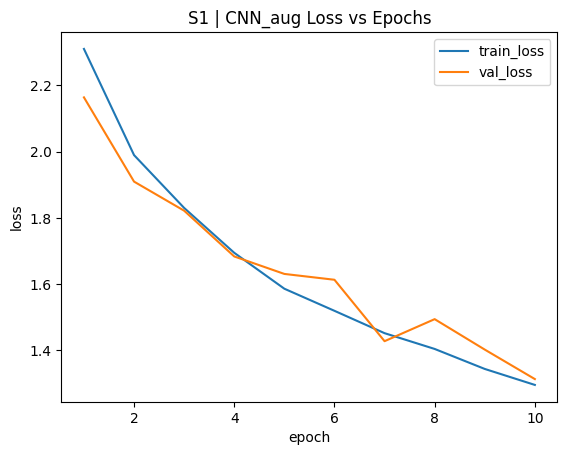

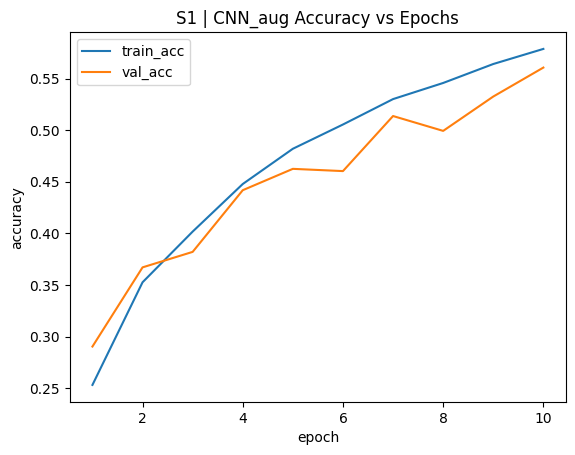


--- BiLSTM_aug ---
Params total=545,041 | trainable=545,041 | size≈2.08 MB
Epoch 1/10 | time=12.74s | tr_loss=2.5083 tr_acc=0.1874 | va_loss=2.2449 va_acc=0.2608
Epoch 2/10 | time=12.77s | tr_loss=2.2057 tr_acc=0.2755 | va_loss=2.0255 va_acc=0.3183
Epoch 3/10 | time=12.74s | tr_loss=2.0168 tr_acc=0.3326 | va_loss=1.8461 va_acc=0.3785
Epoch 4/10 | time=12.80s | tr_loss=1.8342 tr_acc=0.3964 | va_loss=1.6787 va_acc=0.4331
Epoch 5/10 | time=12.85s | tr_loss=1.6775 tr_acc=0.4479 | va_loss=1.5209 va_acc=0.4845
Epoch 6/10 | time=13.05s | tr_loss=1.5150 tr_acc=0.4984 | va_loss=1.3495 va_acc=0.5484
Epoch 7/10 | time=13.05s | tr_loss=1.4074 tr_acc=0.5364 | va_loss=1.2306 va_acc=0.5782
Epoch 8/10 | time=12.75s | tr_loss=1.2867 tr_acc=0.5763 | va_loss=1.1304 va_acc=0.6132
Epoch 9/10 | time=12.88s | tr_loss=1.1665 tr_acc=0.6134 | va_loss=1.0119 va_acc=0.6519
Epoch 10/10 | time=12.89s | tr_loss=1.0914 tr_acc=0.6419 | va_loss=0.9416 va_acc=0.6780
TEST: acc=0.2362, precision=0.2218, recall=0.2624, f1

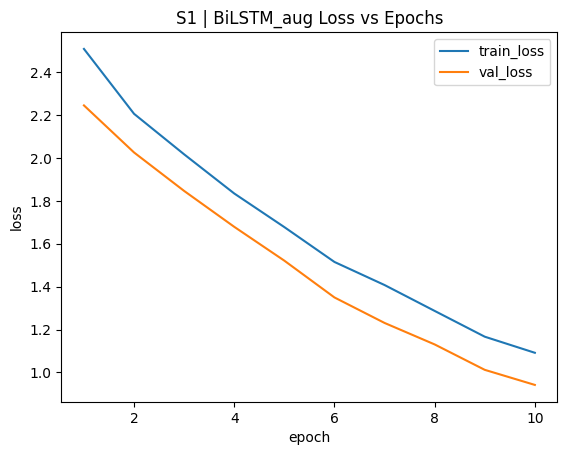

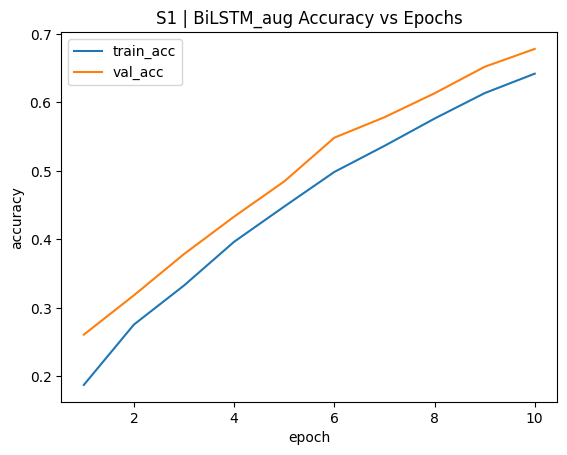


--- Transformer_aug ---
Params total=797,201 | trainable=797,201 | size≈3.04 MB
Epoch 1/10 | time=24.34s | tr_loss=2.2043 tr_acc=0.2828 | va_loss=1.8251 va_acc=0.3873
Epoch 2/10 | time=24.24s | tr_loss=1.6783 tr_acc=0.4413 | va_loss=1.4013 va_acc=0.5245
Epoch 3/10 | time=24.23s | tr_loss=1.3683 tr_acc=0.5412 | va_loss=1.1753 va_acc=0.5970
Epoch 4/10 | time=24.37s | tr_loss=1.2281 tr_acc=0.5921 | va_loss=0.9857 va_acc=0.6550
Epoch 5/10 | time=24.33s | tr_loss=1.0873 tr_acc=0.6373 | va_loss=0.9018 va_acc=0.6852
Epoch 6/10 | time=24.36s | tr_loss=1.0075 tr_acc=0.6645 | va_loss=0.8289 va_acc=0.7103
Epoch 7/10 | time=24.28s | tr_loss=0.9483 tr_acc=0.6850 | va_loss=0.7856 va_acc=0.7295
Epoch 8/10 | time=24.38s | tr_loss=0.8361 tr_acc=0.7204 | va_loss=0.7506 va_acc=0.7342
Epoch 9/10 | time=24.35s | tr_loss=0.7788 tr_acc=0.7392 | va_loss=0.6219 va_acc=0.7787
Epoch 10/10 | time=24.31s | tr_loss=0.7732 tr_acc=0.7430 | va_loss=0.5874 va_acc=0.7912
TEST: acc=0.1484, precision=0.1965, recall=0.160

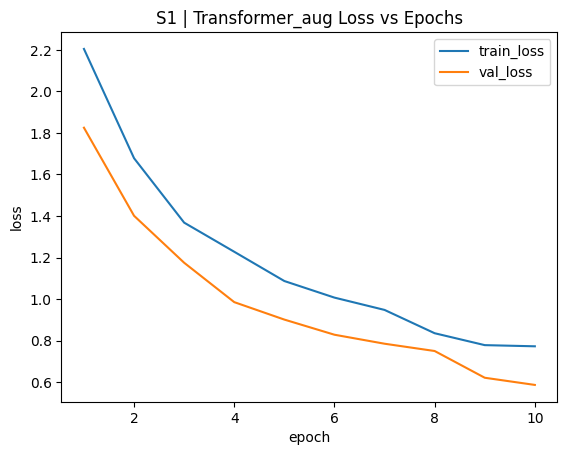

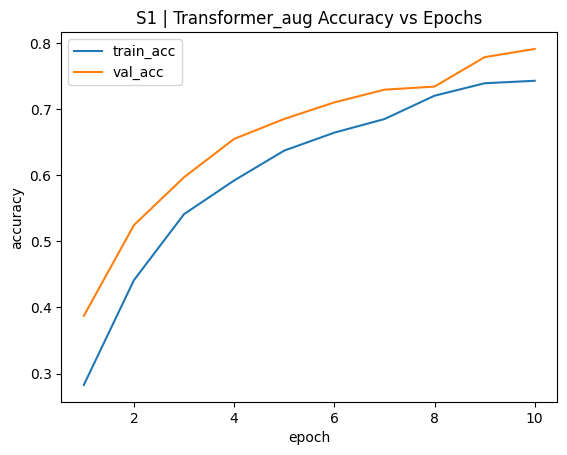


LOSO TEST SUBJECT (AUG): S2

--- CNN_aug ---
Params total=232,273 | trainable=232,273 | size≈0.89 MB
Epoch 1/10 | time=3.39s | tr_loss=2.2937 tr_acc=0.2597 | va_loss=2.0893 va_acc=0.3230
Epoch 2/10 | time=3.76s | tr_loss=1.9864 tr_acc=0.3531 | va_loss=1.9520 va_acc=0.3452
Epoch 3/10 | time=4.20s | tr_loss=1.8215 tr_acc=0.4050 | va_loss=1.7549 va_acc=0.4199
Epoch 4/10 | time=3.51s | tr_loss=1.6895 tr_acc=0.4463 | va_loss=1.6607 va_acc=0.4475
Epoch 5/10 | time=3.61s | tr_loss=1.5588 tr_acc=0.4897 | va_loss=1.5471 va_acc=0.4798
Epoch 6/10 | time=4.42s | tr_loss=1.5043 tr_acc=0.5081 | va_loss=1.4386 va_acc=0.5143
Epoch 7/10 | time=3.59s | tr_loss=1.4264 tr_acc=0.5326 | va_loss=1.3265 va_acc=0.5619
Epoch 8/10 | time=3.56s | tr_loss=1.3856 tr_acc=0.5500 | va_loss=1.3545 va_acc=0.5392
Epoch 9/10 | time=4.21s | tr_loss=1.3112 tr_acc=0.5708 | va_loss=1.3334 va_acc=0.5414
Epoch 10/10 | time=4.04s | tr_loss=1.2759 tr_acc=0.5868 | va_loss=1.2574 va_acc=0.5698
TEST: acc=0.1492, precision=0.1654, r

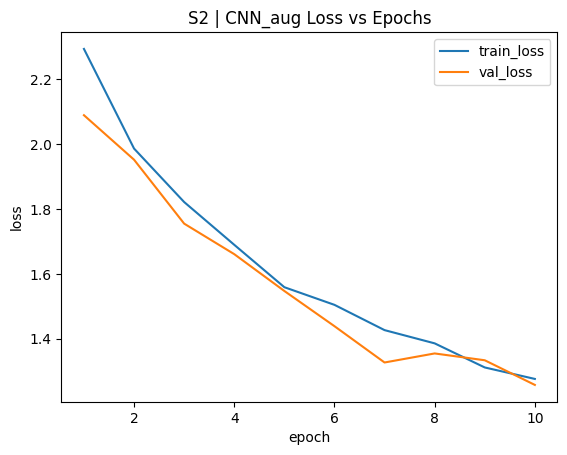

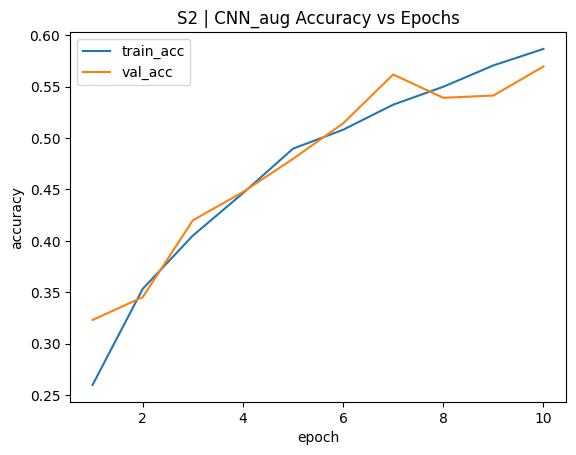


--- BiLSTM_aug ---
Params total=545,041 | trainable=545,041 | size≈2.08 MB
Epoch 1/10 | time=12.72s | tr_loss=2.4904 tr_acc=0.1919 | va_loss=2.2352 va_acc=0.2700
Epoch 2/10 | time=12.70s | tr_loss=2.1719 tr_acc=0.2847 | va_loss=2.0256 va_acc=0.3267
Epoch 3/10 | time=12.76s | tr_loss=1.9883 tr_acc=0.3418 | va_loss=1.8763 va_acc=0.3743
Epoch 4/10 | time=12.75s | tr_loss=1.8093 tr_acc=0.4006 | va_loss=1.6658 va_acc=0.4384
Epoch 5/10 | time=12.67s | tr_loss=1.6675 tr_acc=0.4492 | va_loss=1.4993 va_acc=0.4915
Epoch 6/10 | time=12.71s | tr_loss=1.5102 tr_acc=0.4995 | va_loss=1.3412 va_acc=0.5444
Epoch 7/10 | time=12.64s | tr_loss=1.3813 tr_acc=0.5409 | va_loss=1.2734 va_acc=0.5733
Epoch 8/10 | time=12.82s | tr_loss=1.2786 tr_acc=0.5776 | va_loss=1.1187 va_acc=0.6235
Epoch 9/10 | time=12.69s | tr_loss=1.1974 tr_acc=0.6042 | va_loss=1.0216 va_acc=0.6486
Epoch 10/10 | time=12.84s | tr_loss=1.1298 tr_acc=0.6279 | va_loss=0.9627 va_acc=0.6730
TEST: acc=0.1303, precision=0.1536, recall=0.1473, f1

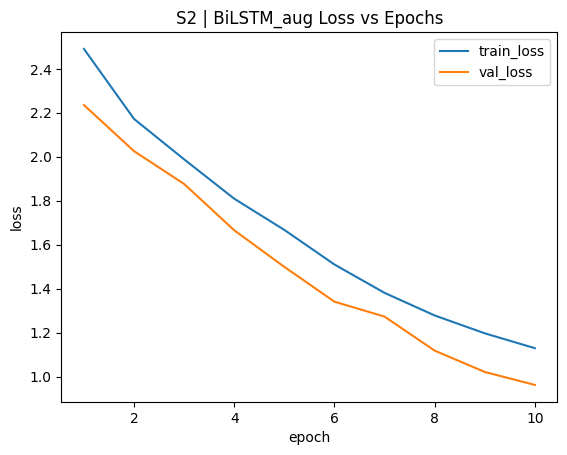

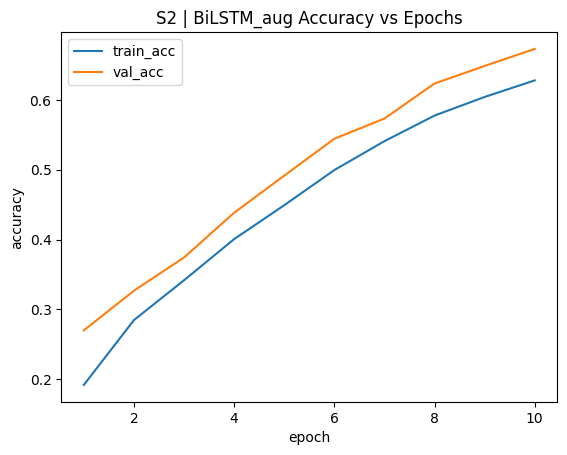


--- Transformer_aug ---
Params total=797,201 | trainable=797,201 | size≈3.04 MB
Epoch 1/10 | time=24.06s | tr_loss=2.1239 tr_acc=0.3063 | va_loss=1.7237 va_acc=0.4243
Epoch 2/10 | time=24.16s | tr_loss=1.6117 tr_acc=0.4609 | va_loss=1.3383 va_acc=0.5362
Epoch 3/10 | time=24.04s | tr_loss=1.3730 tr_acc=0.5394 | va_loss=1.1039 va_acc=0.6132
Epoch 4/10 | time=24.19s | tr_loss=1.1991 tr_acc=0.5965 | va_loss=0.9987 va_acc=0.6495
Epoch 5/10 | time=24.13s | tr_loss=1.0472 tr_acc=0.6469 | va_loss=0.8844 va_acc=0.6933
Epoch 6/10 | time=24.21s | tr_loss=0.9366 tr_acc=0.6847 | va_loss=0.7944 va_acc=0.7262
Epoch 7/10 | time=24.16s | tr_loss=0.9111 tr_acc=0.6967 | va_loss=0.7257 va_acc=0.7366
Epoch 8/10 | time=24.13s | tr_loss=0.8431 tr_acc=0.7198 | va_loss=0.6592 va_acc=0.7630
Epoch 9/10 | time=24.16s | tr_loss=0.7985 tr_acc=0.7351 | va_loss=0.6184 va_acc=0.7782
Epoch 10/10 | time=24.17s | tr_loss=0.7505 tr_acc=0.7526 | va_loss=0.5700 va_acc=0.7936
TEST: acc=0.1440, precision=0.1910, recall=0.158

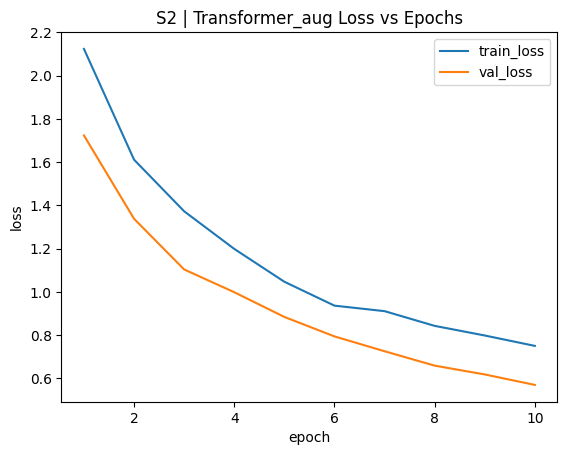

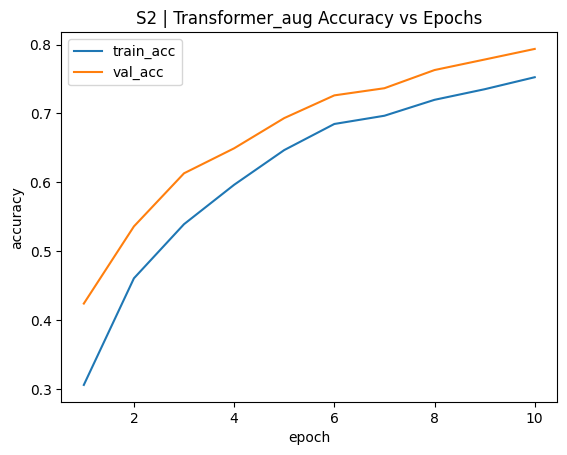


LOSO TEST SUBJECT (AUG): S3

--- CNN_aug ---
Params total=232,273 | trainable=232,273 | size≈0.89 MB
Epoch 1/10 | time=4.94s | tr_loss=2.2868 tr_acc=0.2601 | va_loss=2.1082 va_acc=0.3164
Epoch 2/10 | time=3.96s | tr_loss=1.9907 tr_acc=0.3489 | va_loss=1.9083 va_acc=0.3543
Epoch 3/10 | time=4.00s | tr_loss=1.8387 tr_acc=0.3974 | va_loss=1.8031 va_acc=0.3990
Epoch 4/10 | time=4.83s | tr_loss=1.6878 tr_acc=0.4479 | va_loss=1.6728 va_acc=0.4432
Epoch 5/10 | time=4.20s | tr_loss=1.6216 tr_acc=0.4704 | va_loss=1.5340 va_acc=0.4854
Epoch 6/10 | time=4.00s | tr_loss=1.5034 tr_acc=0.5089 | va_loss=1.4980 va_acc=0.5032
Epoch 7/10 | time=4.82s | tr_loss=1.4374 tr_acc=0.5299 | va_loss=1.4876 va_acc=0.4931
Epoch 8/10 | time=4.14s | tr_loss=1.3838 tr_acc=0.5467 | va_loss=1.3708 va_acc=0.5477
Epoch 9/10 | time=3.92s | tr_loss=1.3195 tr_acc=0.5691 | va_loss=1.2887 va_acc=0.5668
Epoch 10/10 | time=4.48s | tr_loss=1.2935 tr_acc=0.5781 | va_loss=1.2605 va_acc=0.5794
TEST: acc=0.2391, precision=0.2329, r

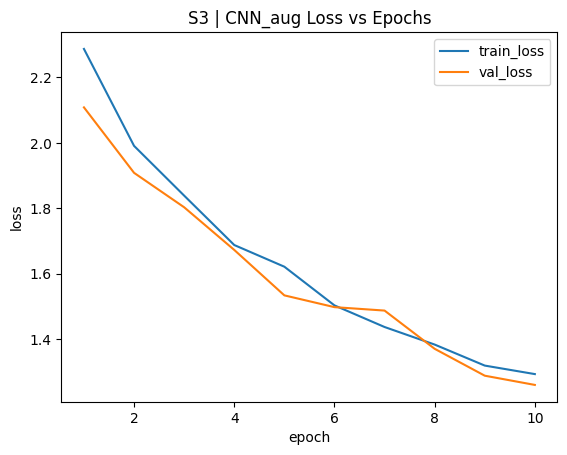

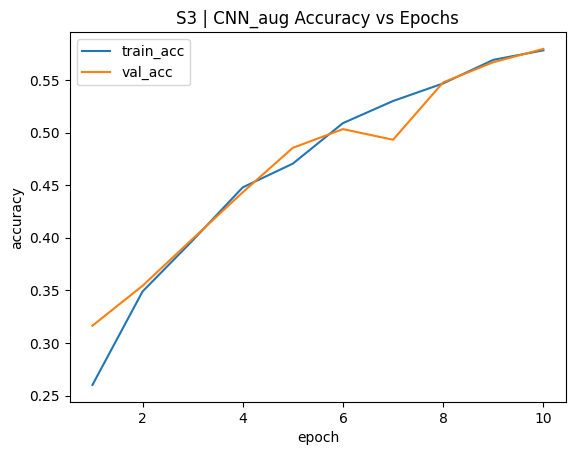


--- BiLSTM_aug ---
Params total=545,041 | trainable=545,041 | size≈2.08 MB
Epoch 1/10 | time=13.29s | tr_loss=2.4985 tr_acc=0.1870 | va_loss=2.2723 va_acc=0.2587
Epoch 2/10 | time=13.14s | tr_loss=2.2003 tr_acc=0.2765 | va_loss=2.0577 va_acc=0.3113
Epoch 3/10 | time=13.28s | tr_loss=2.0168 tr_acc=0.3290 | va_loss=1.8512 va_acc=0.3815
Epoch 4/10 | time=13.18s | tr_loss=1.8309 tr_acc=0.3937 | va_loss=1.6880 va_acc=0.4244
Epoch 5/10 | time=13.21s | tr_loss=1.6844 tr_acc=0.4412 | va_loss=1.5125 va_acc=0.4921
Epoch 6/10 | time=13.17s | tr_loss=1.5499 tr_acc=0.4867 | va_loss=1.3557 va_acc=0.5427
Epoch 7/10 | time=13.15s | tr_loss=1.4081 tr_acc=0.5340 | va_loss=1.2635 va_acc=0.5706
Epoch 8/10 | time=13.18s | tr_loss=1.3272 tr_acc=0.5631 | va_loss=1.1748 va_acc=0.6017
Epoch 9/10 | time=13.25s | tr_loss=1.1979 tr_acc=0.6064 | va_loss=1.0645 va_acc=0.6359
Epoch 10/10 | time=13.03s | tr_loss=1.1222 tr_acc=0.6306 | va_loss=0.9744 va_acc=0.6705
TEST: acc=0.2259, precision=0.2910, recall=0.2479, f1

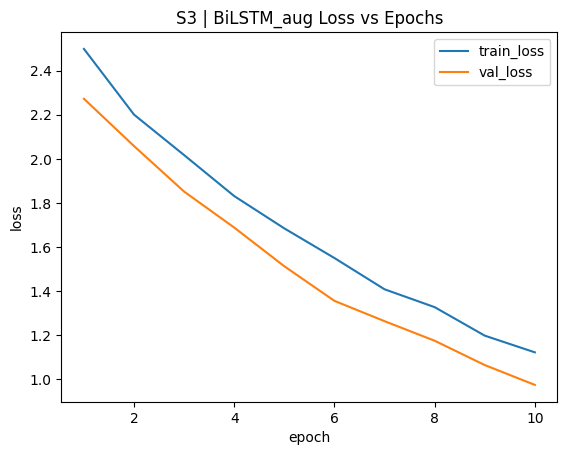

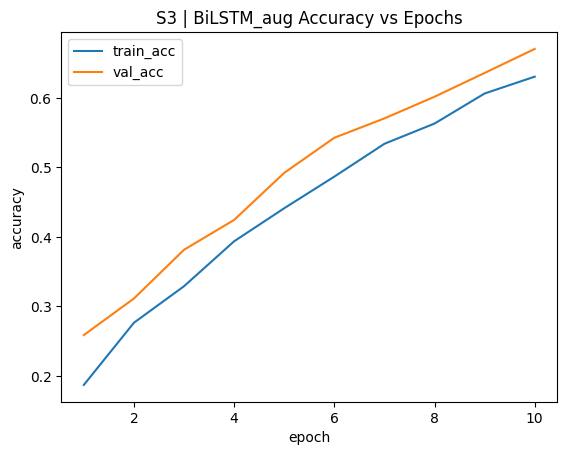


--- Transformer_aug ---
Params total=797,201 | trainable=797,201 | size≈3.04 MB
Epoch 1/10 | time=25.24s | tr_loss=2.1533 tr_acc=0.2930 | va_loss=1.7361 va_acc=0.4087
Epoch 2/10 | time=25.19s | tr_loss=1.6548 tr_acc=0.4472 | va_loss=1.3621 va_acc=0.5350
Epoch 3/10 | time=25.33s | tr_loss=1.3776 tr_acc=0.5357 | va_loss=1.1564 va_acc=0.5952
Epoch 4/10 | time=25.46s | tr_loss=1.2282 tr_acc=0.5871 | va_loss=0.9979 va_acc=0.6479
Epoch 5/10 | time=25.17s | tr_loss=1.0837 tr_acc=0.6373 | va_loss=0.8666 va_acc=0.6991
Epoch 6/10 | time=24.23s | tr_loss=0.9780 tr_acc=0.6714 | va_loss=0.7745 va_acc=0.7256
Epoch 7/10 | time=24.23s | tr_loss=0.9189 tr_acc=0.6917 | va_loss=0.7118 va_acc=0.7475
Epoch 8/10 | time=24.13s | tr_loss=0.8706 tr_acc=0.7129 | va_loss=0.6648 va_acc=0.7637
Epoch 9/10 | time=24.16s | tr_loss=0.7764 tr_acc=0.7379 | va_loss=0.6175 va_acc=0.7763
Epoch 10/10 | time=24.15s | tr_loss=0.7388 tr_acc=0.7543 | va_loss=0.5992 va_acc=0.7838
TEST: acc=0.2110, precision=0.2689, recall=0.240

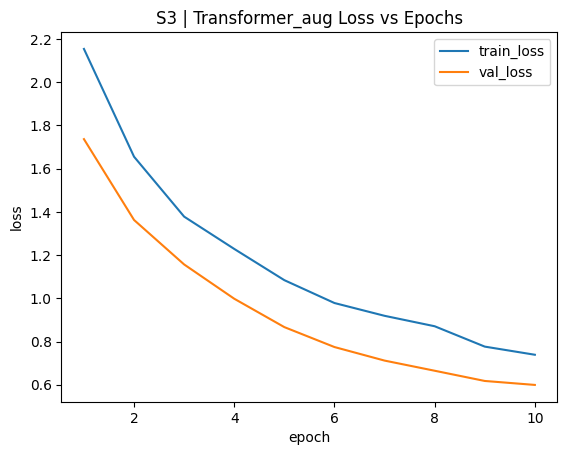

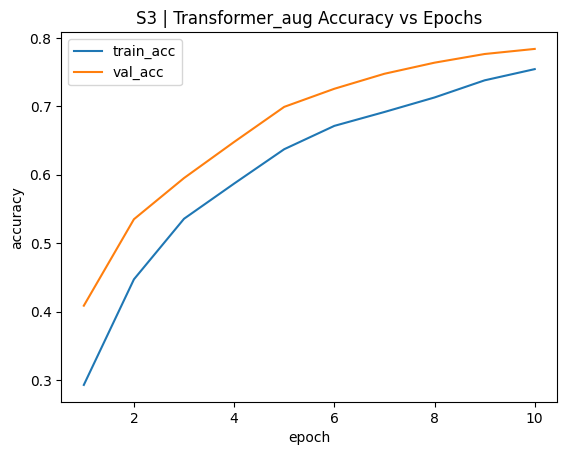


LOSO TEST SUBJECT (AUG): S4

--- CNN_aug ---
Params total=232,273 | trainable=232,273 | size≈0.89 MB
Epoch 1/10 | time=3.53s | tr_loss=2.3011 tr_acc=0.2556 | va_loss=2.1055 va_acc=0.3193
Epoch 2/10 | time=3.77s | tr_loss=2.0008 tr_acc=0.3460 | va_loss=1.9170 va_acc=0.3725
Epoch 3/10 | time=4.55s | tr_loss=1.8338 tr_acc=0.4001 | va_loss=1.8148 va_acc=0.4098
Epoch 4/10 | time=3.66s | tr_loss=1.6893 tr_acc=0.4469 | va_loss=1.6928 va_acc=0.4364
Epoch 5/10 | time=3.52s | tr_loss=1.5930 tr_acc=0.4803 | va_loss=1.5033 va_acc=0.5078
Epoch 6/10 | time=4.03s | tr_loss=1.5017 tr_acc=0.5091 | va_loss=1.4559 va_acc=0.5172
Epoch 7/10 | time=4.04s | tr_loss=1.4350 tr_acc=0.5316 | va_loss=1.3940 va_acc=0.5445
Epoch 8/10 | time=3.57s | tr_loss=1.3729 tr_acc=0.5527 | va_loss=1.3479 va_acc=0.5455
Epoch 9/10 | time=3.52s | tr_loss=1.3258 tr_acc=0.5697 | va_loss=1.3901 va_acc=0.5302
Epoch 10/10 | time=4.47s | tr_loss=1.2674 tr_acc=0.5897 | va_loss=1.2757 va_acc=0.5771
TEST: acc=0.1828, precision=0.1956, r

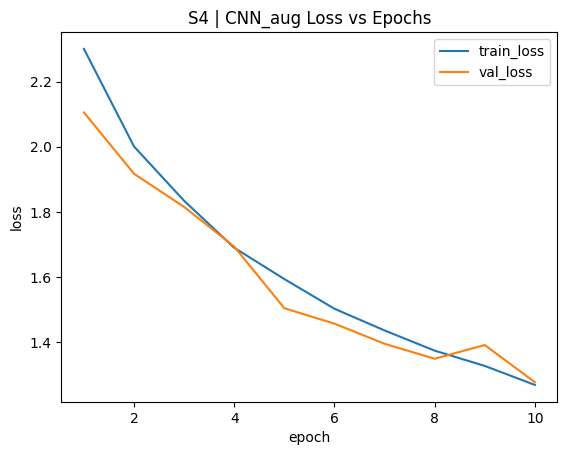

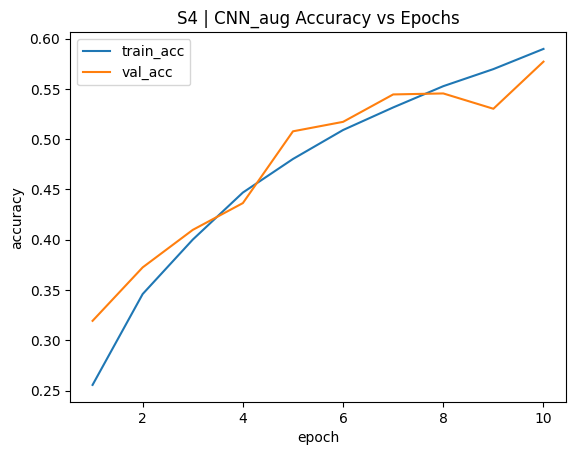


--- BiLSTM_aug ---
Params total=545,041 | trainable=545,041 | size≈2.08 MB
Epoch 1/10 | time=12.66s | tr_loss=2.4951 tr_acc=0.1921 | va_loss=2.2993 va_acc=0.2435
Epoch 2/10 | time=12.65s | tr_loss=2.1841 tr_acc=0.2824 | va_loss=2.0184 va_acc=0.3284
Epoch 3/10 | time=12.81s | tr_loss=1.9989 tr_acc=0.3403 | va_loss=1.8737 va_acc=0.3798
Epoch 4/10 | time=12.56s | tr_loss=1.8244 tr_acc=0.3969 | va_loss=1.6788 va_acc=0.4424
Epoch 5/10 | time=12.56s | tr_loss=1.6782 tr_acc=0.4456 | va_loss=1.5244 va_acc=0.4900
Epoch 6/10 | time=12.64s | tr_loss=1.5273 tr_acc=0.4946 | va_loss=1.4008 va_acc=0.5306
Epoch 7/10 | time=12.57s | tr_loss=1.4011 tr_acc=0.5366 | va_loss=1.2588 va_acc=0.5788
Epoch 8/10 | time=12.53s | tr_loss=1.2957 tr_acc=0.5719 | va_loss=1.1559 va_acc=0.6146
Epoch 9/10 | time=12.69s | tr_loss=1.1963 tr_acc=0.6051 | va_loss=1.0666 va_acc=0.6413
Epoch 10/10 | time=12.48s | tr_loss=1.1446 tr_acc=0.6262 | va_loss=0.9720 va_acc=0.6737
TEST: acc=0.1392, precision=0.1891, recall=0.1574, f1

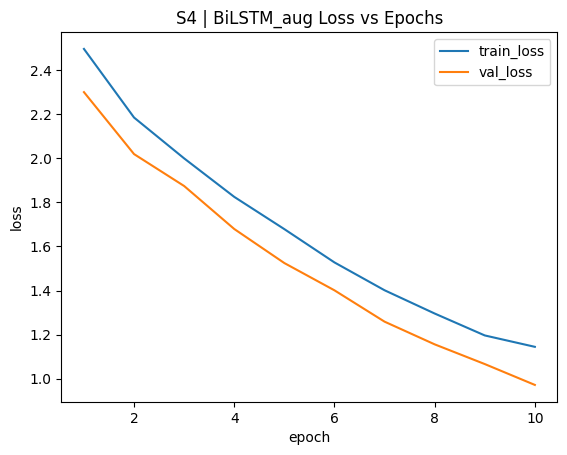

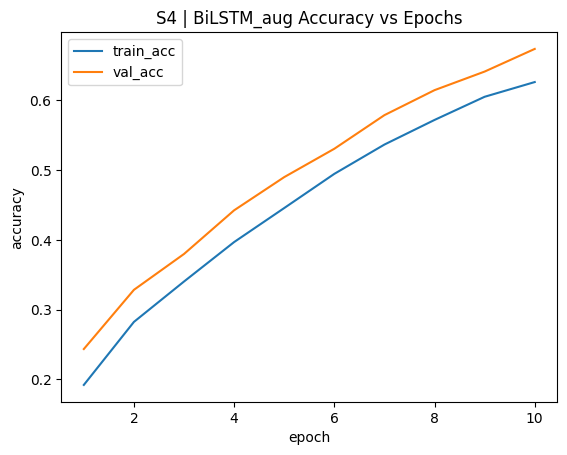


--- Transformer_aug ---
Params total=797,201 | trainable=797,201 | size≈3.04 MB
Epoch 1/10 | time=23.90s | tr_loss=2.1379 tr_acc=0.3046 | va_loss=1.7308 va_acc=0.4275
Epoch 2/10 | time=23.76s | tr_loss=1.6255 tr_acc=0.4591 | va_loss=1.3751 va_acc=0.5401
Epoch 3/10 | time=23.76s | tr_loss=1.3361 tr_acc=0.5513 | va_loss=1.1058 va_acc=0.6258
Epoch 4/10 | time=23.72s | tr_loss=1.1522 tr_acc=0.6115 | va_loss=0.9717 va_acc=0.6653
Epoch 5/10 | time=23.84s | tr_loss=1.0665 tr_acc=0.6458 | va_loss=0.8581 va_acc=0.7109
Epoch 6/10 | time=23.81s | tr_loss=0.9481 tr_acc=0.6813 | va_loss=0.7872 va_acc=0.7257
Epoch 7/10 | time=23.76s | tr_loss=0.8911 tr_acc=0.7024 | va_loss=0.7256 va_acc=0.7418
Epoch 8/10 | time=23.87s | tr_loss=0.8189 tr_acc=0.7262 | va_loss=0.6649 va_acc=0.7631
Epoch 9/10 | time=23.79s | tr_loss=0.7567 tr_acc=0.7478 | va_loss=0.6660 va_acc=0.7638
Epoch 10/10 | time=23.93s | tr_loss=0.7285 tr_acc=0.7572 | va_loss=0.6005 va_acc=0.7917
TEST: acc=0.1645, precision=0.1903, recall=0.177

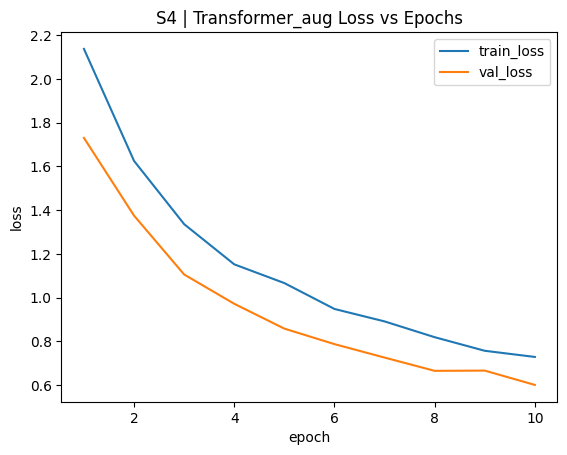

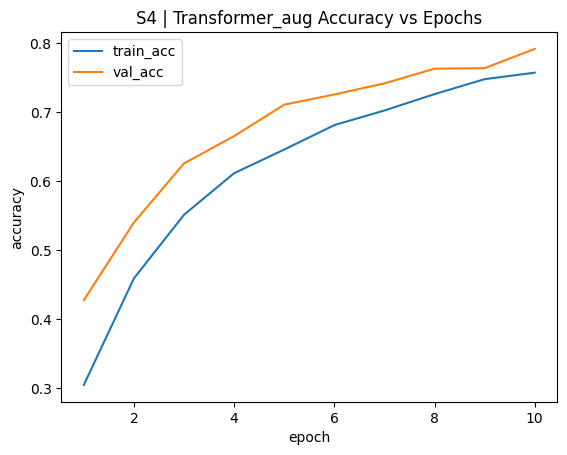


LOSO TEST SUBJECT (AUG): S5

--- CNN_aug ---
Params total=232,273 | trainable=232,273 | size≈0.89 MB
Epoch 1/10 | time=3.52s | tr_loss=2.3016 tr_acc=0.2572 | va_loss=2.0799 va_acc=0.3240
Epoch 2/10 | time=3.55s | tr_loss=1.9978 tr_acc=0.3515 | va_loss=1.8878 va_acc=0.3728
Epoch 3/10 | time=4.75s | tr_loss=1.8335 tr_acc=0.4011 | va_loss=1.7524 va_acc=0.4186
Epoch 4/10 | time=3.61s | tr_loss=1.7089 tr_acc=0.4407 | va_loss=1.6373 va_acc=0.4612
Epoch 5/10 | time=3.61s | tr_loss=1.6249 tr_acc=0.4688 | va_loss=1.6191 va_acc=0.4668
Epoch 6/10 | time=4.50s | tr_loss=1.5333 tr_acc=0.4979 | va_loss=1.5280 va_acc=0.5047
Epoch 7/10 | time=3.86s | tr_loss=1.4702 tr_acc=0.5201 | va_loss=1.4093 va_acc=0.5377
Epoch 8/10 | time=3.61s | tr_loss=1.4239 tr_acc=0.5369 | va_loss=1.3487 va_acc=0.5525
Epoch 9/10 | time=4.17s | tr_loss=1.3634 tr_acc=0.5568 | va_loss=1.3723 va_acc=0.5377
Epoch 10/10 | time=4.14s | tr_loss=1.3266 tr_acc=0.5716 | va_loss=1.4191 va_acc=0.5103
TEST: acc=0.1701, precision=0.2743, r

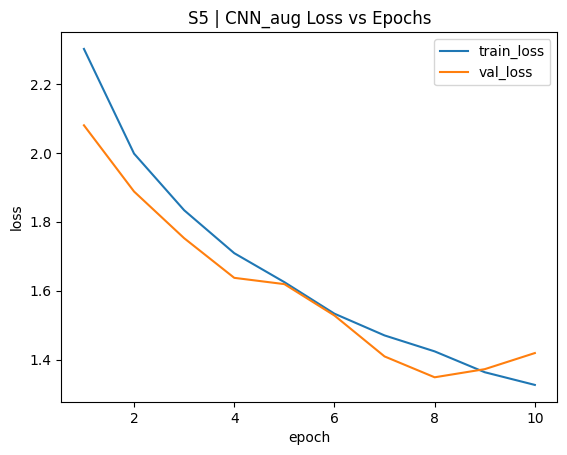

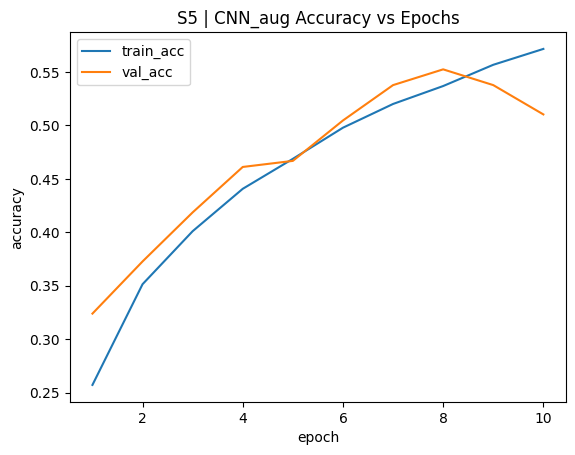


--- BiLSTM_aug ---
Params total=545,041 | trainable=545,041 | size≈2.08 MB
Epoch 1/10 | time=12.93s | tr_loss=2.5113 tr_acc=0.1868 | va_loss=2.2918 va_acc=0.2614
Epoch 2/10 | time=12.95s | tr_loss=2.1989 tr_acc=0.2774 | va_loss=2.0717 va_acc=0.3150
Epoch 3/10 | time=12.95s | tr_loss=2.0187 tr_acc=0.3330 | va_loss=1.8705 va_acc=0.3679
Epoch 4/10 | time=12.77s | tr_loss=1.8333 tr_acc=0.3948 | va_loss=1.6450 va_acc=0.4486
Epoch 5/10 | time=13.00s | tr_loss=1.6593 tr_acc=0.4537 | va_loss=1.4566 va_acc=0.5146
Epoch 6/10 | time=12.91s | tr_loss=1.5001 tr_acc=0.5055 | va_loss=1.3527 va_acc=0.5414
Epoch 7/10 | time=12.94s | tr_loss=1.3665 tr_acc=0.5483 | va_loss=1.2127 va_acc=0.5925
Epoch 8/10 | time=12.89s | tr_loss=1.2633 tr_acc=0.5848 | va_loss=1.1232 va_acc=0.6200
Epoch 9/10 | time=13.02s | tr_loss=1.1666 tr_acc=0.6165 | va_loss=1.0185 va_acc=0.6527
Epoch 10/10 | time=12.84s | tr_loss=1.1098 tr_acc=0.6367 | va_loss=0.9494 va_acc=0.6844
TEST: acc=0.2174, precision=0.2547, recall=0.2563, f1

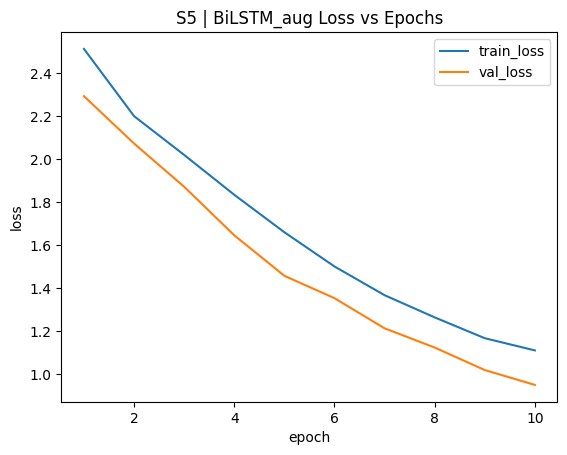

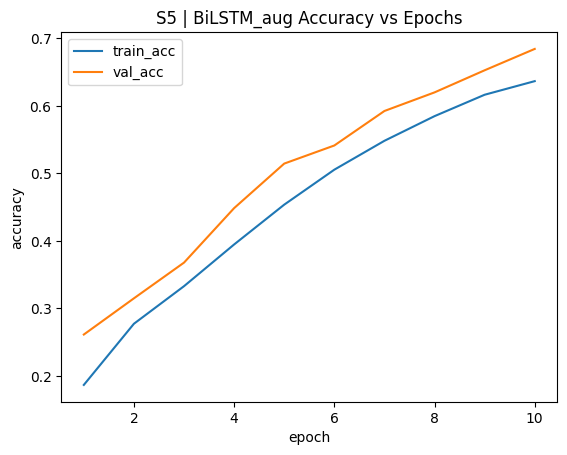


--- Transformer_aug ---
Params total=797,201 | trainable=797,201 | size≈3.04 MB
Epoch 1/10 | time=24.43s | tr_loss=2.1474 tr_acc=0.3022 | va_loss=1.7643 va_acc=0.4122
Epoch 2/10 | time=24.59s | tr_loss=1.6538 tr_acc=0.4457 | va_loss=1.3612 va_acc=0.5399
Epoch 3/10 | time=24.35s | tr_loss=1.3760 tr_acc=0.5407 | va_loss=1.1620 va_acc=0.6012
Epoch 4/10 | time=24.45s | tr_loss=1.2035 tr_acc=0.5985 | va_loss=0.9740 va_acc=0.6601
Epoch 5/10 | time=24.47s | tr_loss=1.0746 tr_acc=0.6403 | va_loss=0.8598 va_acc=0.6961
Epoch 6/10 | time=24.40s | tr_loss=0.9661 tr_acc=0.6769 | va_loss=0.8039 va_acc=0.7199
Epoch 7/10 | time=24.43s | tr_loss=0.9319 tr_acc=0.6899 | va_loss=0.7341 va_acc=0.7459
Epoch 8/10 | time=24.59s | tr_loss=0.8373 tr_acc=0.7214 | va_loss=0.7052 va_acc=0.7565
Epoch 9/10 | time=24.60s | tr_loss=0.7939 tr_acc=0.7365 | va_loss=0.6305 va_acc=0.7744
Epoch 10/10 | time=24.40s | tr_loss=0.7486 tr_acc=0.7504 | va_loss=0.5665 va_acc=0.8015
TEST: acc=0.2050, precision=0.2342, recall=0.231

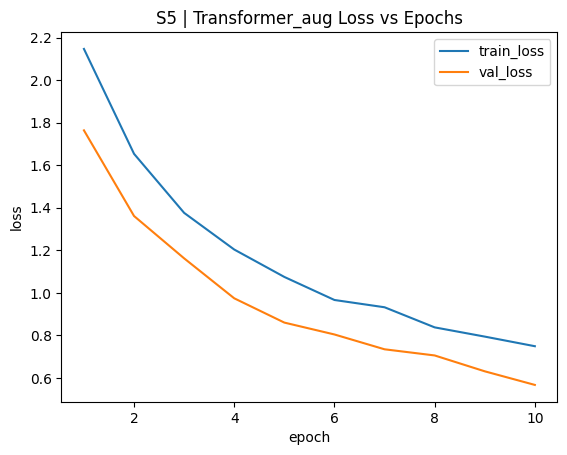

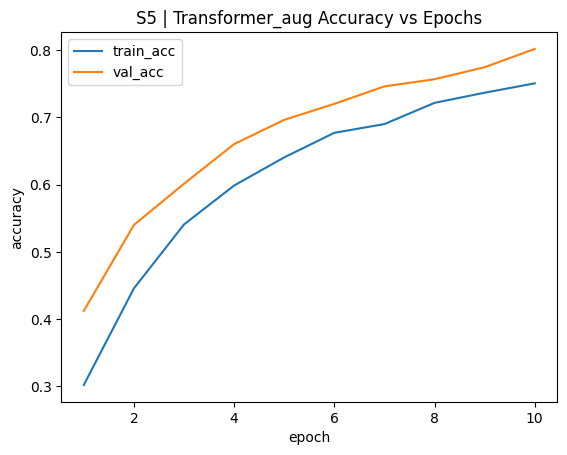


LOSO TEST SUBJECT (AUG): S6

--- CNN_aug ---
Params total=232,273 | trainable=232,273 | size≈0.89 MB
Epoch 1/10 | time=3.71s | tr_loss=2.2986 tr_acc=0.2582 | va_loss=2.1025 va_acc=0.3091
Epoch 2/10 | time=3.46s | tr_loss=1.9832 tr_acc=0.3524 | va_loss=1.9326 va_acc=0.3650
Epoch 3/10 | time=3.80s | tr_loss=1.8095 tr_acc=0.4074 | va_loss=1.7774 va_acc=0.4188
Epoch 4/10 | time=4.14s | tr_loss=1.6840 tr_acc=0.4488 | va_loss=1.7192 va_acc=0.4429
Epoch 5/10 | time=3.61s | tr_loss=1.5967 tr_acc=0.4771 | va_loss=1.5212 va_acc=0.4993
Epoch 6/10 | time=3.57s | tr_loss=1.5133 tr_acc=0.5071 | va_loss=1.5506 va_acc=0.4816
Epoch 7/10 | time=4.53s | tr_loss=1.4366 tr_acc=0.5289 | va_loss=1.3744 va_acc=0.5548
Epoch 8/10 | time=3.52s | tr_loss=1.3795 tr_acc=0.5498 | va_loss=1.3340 va_acc=0.5470
Epoch 9/10 | time=3.59s | tr_loss=1.3318 tr_acc=0.5670 | va_loss=1.2513 va_acc=0.5834
Epoch 10/10 | time=3.92s | tr_loss=1.2907 tr_acc=0.5817 | va_loss=1.3796 va_acc=0.5355
TEST: acc=0.1827, precision=0.1561, r

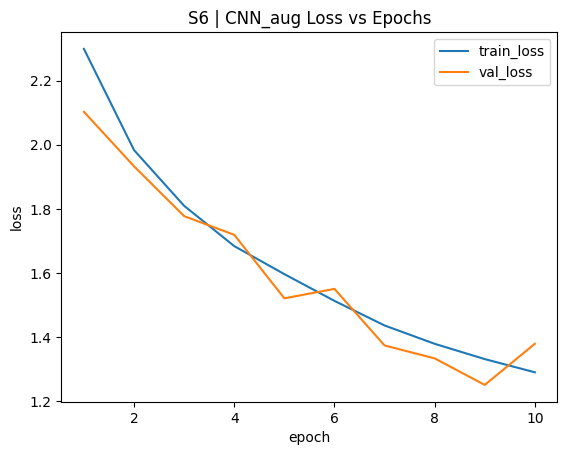

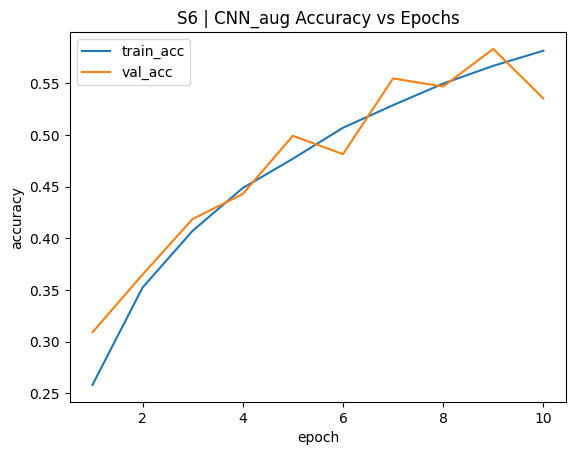


--- BiLSTM_aug ---
Params total=545,041 | trainable=545,041 | size≈2.08 MB
Epoch 1/10 | time=12.77s | tr_loss=2.5181 tr_acc=0.1817 | va_loss=2.2731 va_acc=0.2661
Epoch 2/10 | time=12.79s | tr_loss=2.2115 tr_acc=0.2751 | va_loss=2.0630 va_acc=0.3190
Epoch 3/10 | time=12.86s | tr_loss=2.0015 tr_acc=0.3397 | va_loss=1.8470 va_acc=0.3910
Epoch 4/10 | time=12.69s | tr_loss=1.8240 tr_acc=0.3950 | va_loss=1.6496 va_acc=0.4507
Epoch 5/10 | time=12.71s | tr_loss=1.6488 tr_acc=0.4550 | va_loss=1.4879 va_acc=0.5002
Epoch 6/10 | time=12.60s | tr_loss=1.4847 tr_acc=0.5065 | va_loss=1.3557 va_acc=0.5421
Epoch 7/10 | time=12.64s | tr_loss=1.3876 tr_acc=0.5401 | va_loss=1.2437 va_acc=0.5769
Epoch 8/10 | time=12.62s | tr_loss=1.3084 tr_acc=0.5696 | va_loss=1.1541 va_acc=0.6049
Epoch 9/10 | time=12.72s | tr_loss=1.1969 tr_acc=0.6065 | va_loss=1.0370 va_acc=0.6427
Epoch 10/10 | time=12.69s | tr_loss=1.1315 tr_acc=0.6281 | va_loss=0.9886 va_acc=0.6594
TEST: acc=0.1798, precision=0.1959, recall=0.2216, f1

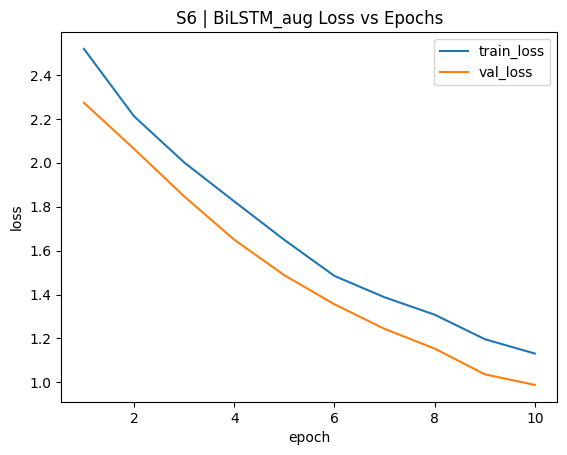

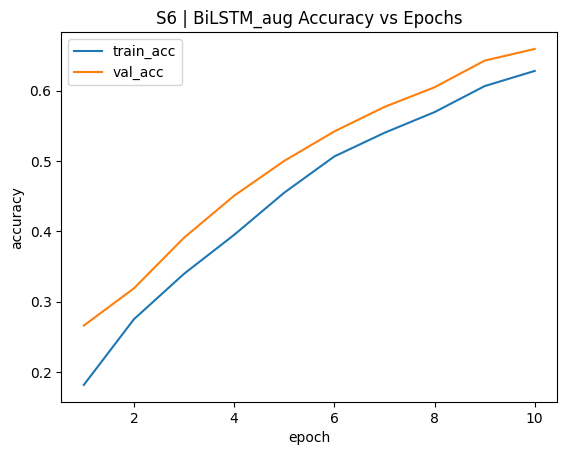


--- Transformer_aug ---
Params total=797,201 | trainable=797,201 | size≈3.04 MB
Epoch 1/10 | time=24.07s | tr_loss=2.1441 tr_acc=0.3005 | va_loss=1.6894 va_acc=0.4406
Epoch 2/10 | time=23.88s | tr_loss=1.6253 tr_acc=0.4574 | va_loss=1.3724 va_acc=0.5295
Epoch 3/10 | time=24.03s | tr_loss=1.3719 tr_acc=0.5385 | va_loss=1.1403 va_acc=0.6084
Epoch 4/10 | time=23.99s | tr_loss=1.2034 tr_acc=0.5961 | va_loss=1.0244 va_acc=0.6479
Epoch 5/10 | time=24.10s | tr_loss=1.0629 tr_acc=0.6420 | va_loss=0.8714 va_acc=0.6949
Epoch 6/10 | time=24.08s | tr_loss=0.9451 tr_acc=0.6815 | va_loss=0.7779 va_acc=0.7272
Epoch 7/10 | time=23.90s | tr_loss=0.9116 tr_acc=0.6964 | va_loss=0.6937 va_acc=0.7521
Epoch 8/10 | time=24.07s | tr_loss=0.8411 tr_acc=0.7177 | va_loss=0.6701 va_acc=0.7616
Epoch 9/10 | time=23.98s | tr_loss=0.7998 tr_acc=0.7340 | va_loss=0.6371 va_acc=0.7728
Epoch 10/10 | time=24.18s | tr_loss=0.7315 tr_acc=0.7576 | va_loss=0.6183 va_acc=0.7788
TEST: acc=0.1496, precision=0.1731, recall=0.199

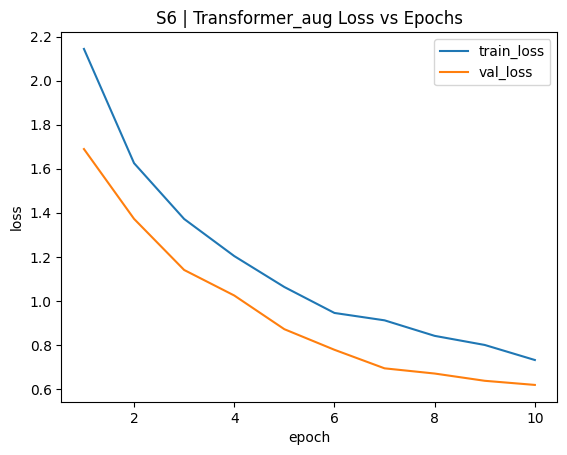

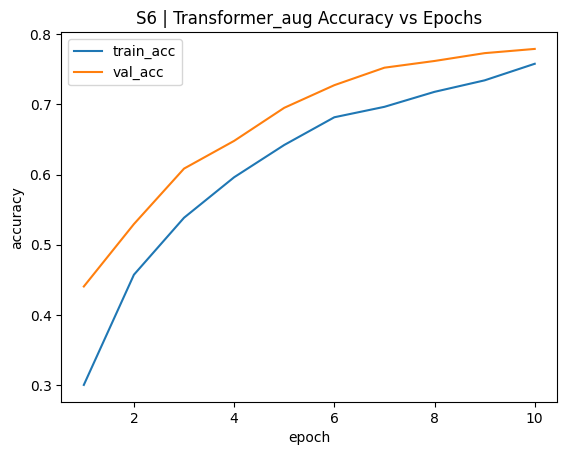


LOSO TEST SUBJECT (AUG): S7

--- CNN_aug ---
Params total=232,273 | trainable=232,273 | size≈0.89 MB
Epoch 1/10 | time=3.43s | tr_loss=2.2844 tr_acc=0.2637 | va_loss=2.1073 va_acc=0.3099
Epoch 2/10 | time=3.52s | tr_loss=1.9912 tr_acc=0.3532 | va_loss=1.9200 va_acc=0.3677
Epoch 3/10 | time=4.38s | tr_loss=1.8228 tr_acc=0.4059 | va_loss=1.7487 va_acc=0.4252
Epoch 4/10 | time=3.67s | tr_loss=1.6921 tr_acc=0.4499 | va_loss=1.6208 va_acc=0.4838
Epoch 5/10 | time=3.45s | tr_loss=1.5881 tr_acc=0.4843 | va_loss=1.5703 va_acc=0.4953
Epoch 6/10 | time=3.97s | tr_loss=1.4851 tr_acc=0.5163 | va_loss=1.5522 va_acc=0.4922
Epoch 7/10 | time=4.07s | tr_loss=1.4292 tr_acc=0.5349 | va_loss=1.4444 va_acc=0.5205
Epoch 8/10 | time=3.45s | tr_loss=1.3579 tr_acc=0.5608 | va_loss=1.3088 va_acc=0.5648
Epoch 9/10 | time=3.56s | tr_loss=1.3227 tr_acc=0.5697 | va_loss=1.2866 va_acc=0.5780
Epoch 10/10 | time=4.43s | tr_loss=1.2556 tr_acc=0.5957 | va_loss=1.2579 va_acc=0.5776
TEST: acc=0.1161, precision=0.2015, r

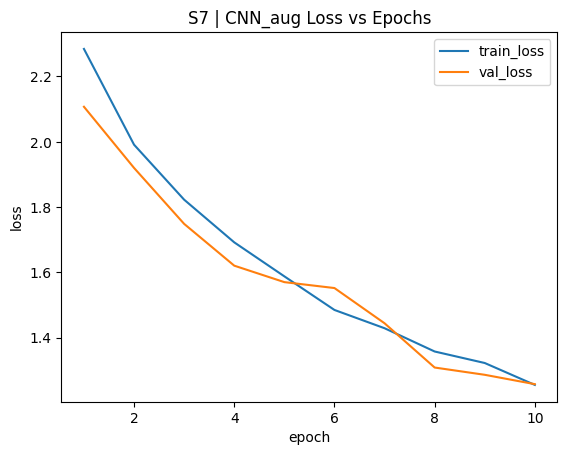

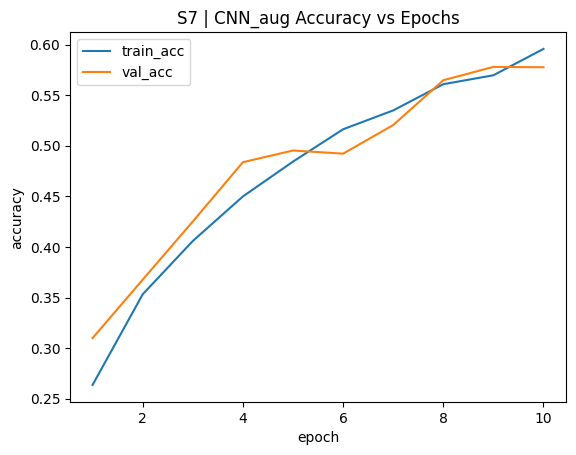


--- BiLSTM_aug ---
Params total=545,041 | trainable=545,041 | size≈2.08 MB
Epoch 1/10 | time=12.63s | tr_loss=2.5210 tr_acc=0.1842 | va_loss=2.3108 va_acc=0.2521
Epoch 2/10 | time=12.68s | tr_loss=2.2113 tr_acc=0.2785 | va_loss=2.0752 va_acc=0.3200
Epoch 3/10 | time=12.66s | tr_loss=2.0001 tr_acc=0.3380 | va_loss=1.8507 va_acc=0.3899
Epoch 4/10 | time=12.72s | tr_loss=1.8207 tr_acc=0.3998 | va_loss=1.6620 va_acc=0.4502
Epoch 5/10 | time=12.62s | tr_loss=1.6714 tr_acc=0.4506 | va_loss=1.5553 va_acc=0.4820
Epoch 6/10 | time=12.59s | tr_loss=1.5427 tr_acc=0.4952 | va_loss=1.3688 va_acc=0.5442
Epoch 7/10 | time=12.50s | tr_loss=1.4034 tr_acc=0.5379 | va_loss=1.2649 va_acc=0.5742
Epoch 8/10 | time=12.38s | tr_loss=1.2692 tr_acc=0.5835 | va_loss=1.1580 va_acc=0.6127
Epoch 9/10 | time=12.46s | tr_loss=1.1762 tr_acc=0.6141 | va_loss=1.0201 va_acc=0.6521
Epoch 10/10 | time=12.64s | tr_loss=1.1378 tr_acc=0.6300 | va_loss=0.9992 va_acc=0.6623
TEST: acc=0.1077, precision=0.1245, recall=0.1145, f1

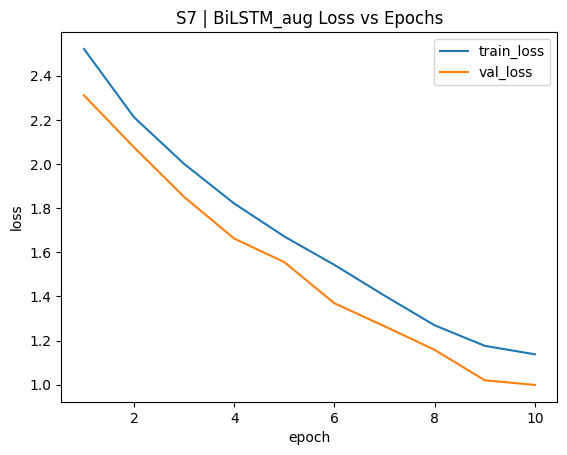

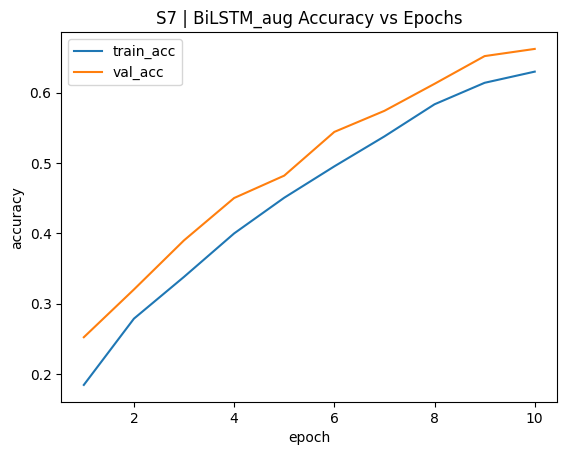


--- Transformer_aug ---
Params total=797,201 | trainable=797,201 | size≈3.04 MB
Epoch 1/10 | time=23.69s | tr_loss=2.1588 tr_acc=0.2966 | va_loss=1.7819 va_acc=0.4168
Epoch 2/10 | time=23.73s | tr_loss=1.6665 tr_acc=0.4486 | va_loss=1.3715 va_acc=0.5410
Epoch 3/10 | time=23.71s | tr_loss=1.3731 tr_acc=0.5430 | va_loss=1.1189 va_acc=0.6191
Epoch 4/10 | time=23.82s | tr_loss=1.2083 tr_acc=0.5986 | va_loss=1.0194 va_acc=0.6499
Epoch 5/10 | time=23.62s | tr_loss=1.0667 tr_acc=0.6459 | va_loss=0.8731 va_acc=0.6968
Epoch 6/10 | time=23.65s | tr_loss=0.9687 tr_acc=0.6787 | va_loss=0.8087 va_acc=0.7222
Epoch 7/10 | time=23.71s | tr_loss=0.9270 tr_acc=0.6968 | va_loss=0.7606 va_acc=0.7332
Epoch 8/10 | time=23.66s | tr_loss=0.8098 tr_acc=0.7324 | va_loss=0.6847 va_acc=0.7591
Epoch 9/10 | time=23.69s | tr_loss=0.7854 tr_acc=0.7412 | va_loss=0.6144 va_acc=0.7816
Epoch 10/10 | time=23.89s | tr_loss=0.7141 tr_acc=0.7651 | va_loss=0.5798 va_acc=0.7967
TEST: acc=0.1365, precision=0.2154, recall=0.149

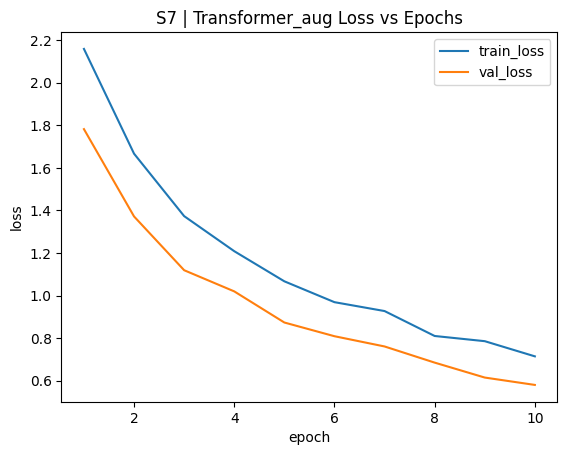

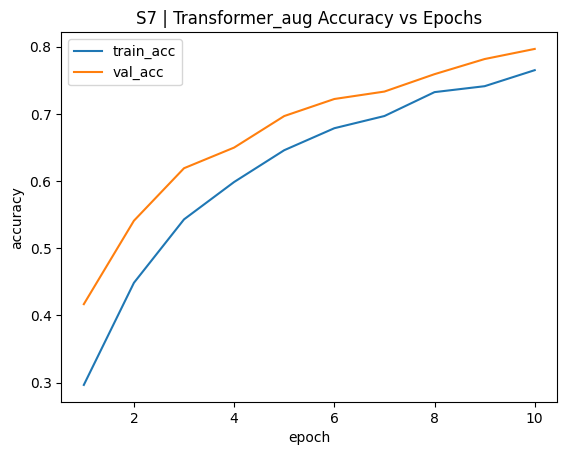


LOSO TEST SUBJECT (AUG): S8

--- CNN_aug ---
Params total=232,273 | trainable=232,273 | size≈0.89 MB
Epoch 1/10 | time=3.79s | tr_loss=2.2932 tr_acc=0.2588 | va_loss=2.0467 va_acc=0.3327
Epoch 2/10 | time=3.63s | tr_loss=1.9949 tr_acc=0.3491 | va_loss=1.8726 va_acc=0.3882
Epoch 3/10 | time=4.50s | tr_loss=1.8342 tr_acc=0.3993 | va_loss=1.6911 va_acc=0.4449
Epoch 4/10 | time=3.82s | tr_loss=1.6981 tr_acc=0.4435 | va_loss=1.6815 va_acc=0.4346
Epoch 5/10 | time=3.57s | tr_loss=1.5989 tr_acc=0.4779 | va_loss=1.6579 va_acc=0.4414
Epoch 6/10 | time=3.74s | tr_loss=1.5051 tr_acc=0.5078 | va_loss=1.4423 va_acc=0.5129
Epoch 7/10 | time=4.43s | tr_loss=1.4285 tr_acc=0.5328 | va_loss=1.3573 va_acc=0.5474
Epoch 8/10 | time=3.69s | tr_loss=1.3826 tr_acc=0.5492 | va_loss=1.3340 va_acc=0.5498
Epoch 9/10 | time=3.64s | tr_loss=1.3137 tr_acc=0.5716 | va_loss=1.2473 va_acc=0.5832
Epoch 10/10 | time=4.63s | tr_loss=1.2920 tr_acc=0.5780 | va_loss=1.2740 va_acc=0.5739
TEST: acc=0.1417, precision=0.3145, r

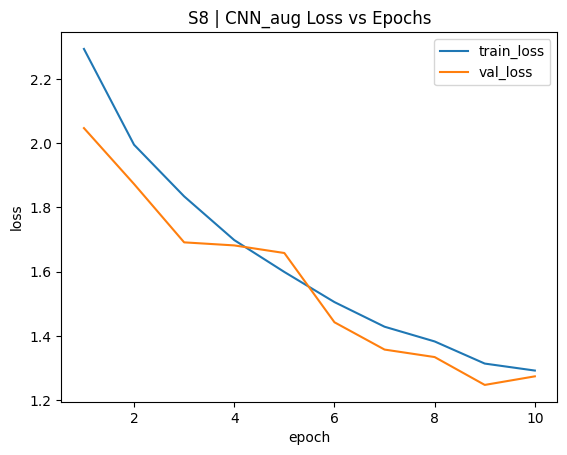

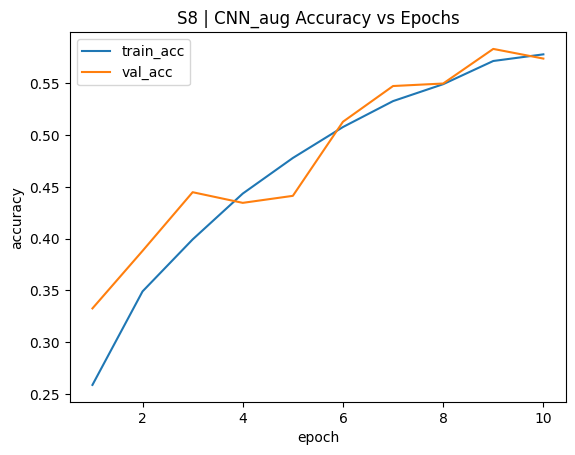


--- BiLSTM_aug ---
Params total=545,041 | trainable=545,041 | size≈2.08 MB
Epoch 1/10 | time=12.84s | tr_loss=2.4833 tr_acc=0.1938 | va_loss=2.2318 va_acc=0.2630
Epoch 2/10 | time=12.95s | tr_loss=2.1756 tr_acc=0.2851 | va_loss=2.0029 va_acc=0.3354
Epoch 3/10 | time=12.92s | tr_loss=1.9741 tr_acc=0.3487 | va_loss=1.8004 va_acc=0.3902
Epoch 4/10 | time=12.90s | tr_loss=1.8146 tr_acc=0.4019 | va_loss=1.6409 va_acc=0.4471
Epoch 5/10 | time=12.89s | tr_loss=1.6570 tr_acc=0.4512 | va_loss=1.4956 va_acc=0.4906
Epoch 6/10 | time=12.95s | tr_loss=1.5015 tr_acc=0.5013 | va_loss=1.3523 va_acc=0.5460
Epoch 7/10 | time=12.96s | tr_loss=1.3687 tr_acc=0.5461 | va_loss=1.2483 va_acc=0.5732
Epoch 8/10 | time=13.06s | tr_loss=1.2441 tr_acc=0.5855 | va_loss=1.1374 va_acc=0.6144
Epoch 9/10 | time=12.99s | tr_loss=1.1971 tr_acc=0.6070 | va_loss=1.0298 va_acc=0.6499
Epoch 10/10 | time=12.95s | tr_loss=1.0894 tr_acc=0.6394 | va_loss=0.9392 va_acc=0.6774
TEST: acc=0.1654, precision=0.2154, recall=0.1661, f1

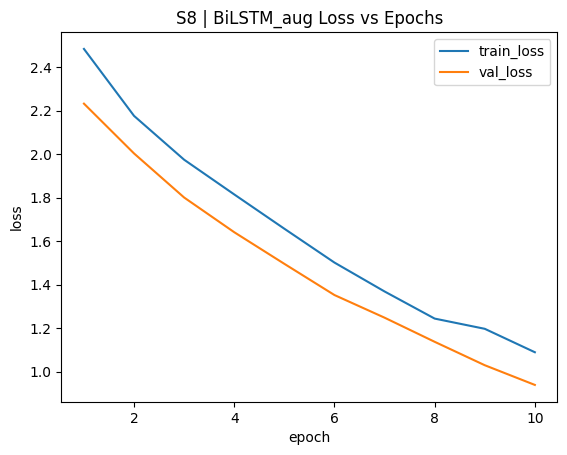

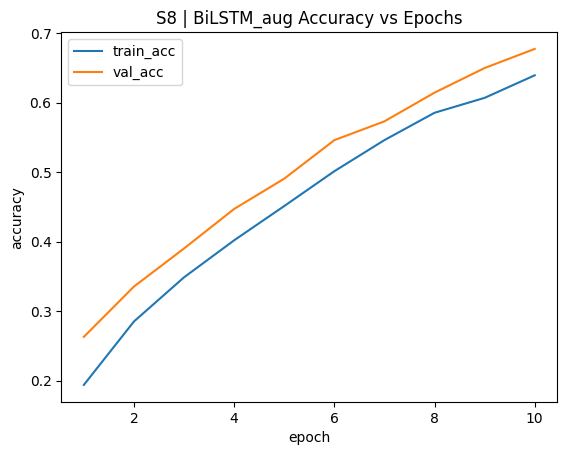


--- Transformer_aug ---
Params total=797,201 | trainable=797,201 | size≈3.04 MB
Epoch 1/10 | time=24.48s | tr_loss=2.1331 tr_acc=0.3040 | va_loss=1.7349 va_acc=0.4277
Epoch 2/10 | time=24.31s | tr_loss=1.6580 tr_acc=0.4499 | va_loss=1.4080 va_acc=0.5177
Epoch 3/10 | time=24.39s | tr_loss=1.3964 tr_acc=0.5289 | va_loss=1.1495 va_acc=0.6050
Epoch 4/10 | time=24.25s | tr_loss=1.2169 tr_acc=0.5913 | va_loss=1.0420 va_acc=0.6414
Epoch 5/10 | time=24.16s | tr_loss=1.0999 tr_acc=0.6312 | va_loss=0.8833 va_acc=0.6997
Epoch 6/10 | time=24.45s | tr_loss=0.9905 tr_acc=0.6696 | va_loss=0.8249 va_acc=0.7146
Epoch 7/10 | time=24.54s | tr_loss=0.9279 tr_acc=0.6921 | va_loss=0.7488 va_acc=0.7394
Epoch 8/10 | time=24.47s | tr_loss=0.8469 tr_acc=0.7190 | va_loss=0.7241 va_acc=0.7483
Epoch 9/10 | time=24.52s | tr_loss=0.8123 tr_acc=0.7304 | va_loss=0.6728 va_acc=0.7644
Epoch 10/10 | time=24.52s | tr_loss=0.7540 tr_acc=0.7496 | va_loss=0.5974 va_acc=0.7883
TEST: acc=0.1290, precision=0.1742, recall=0.130

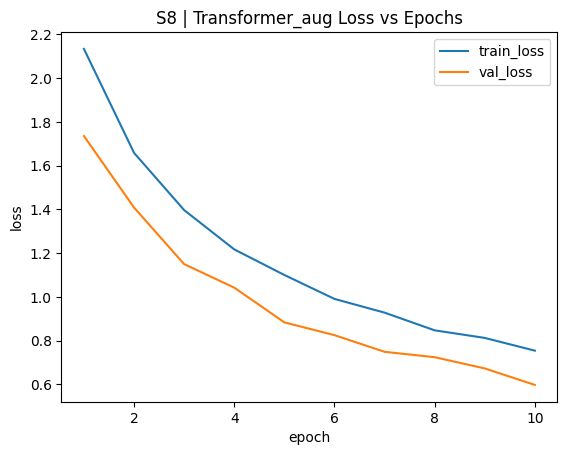

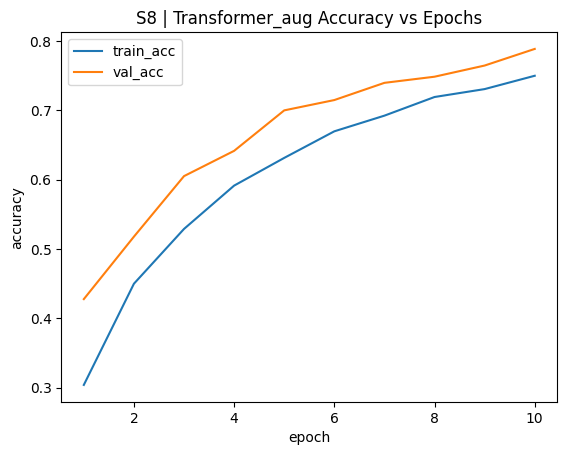


LOSO TEST SUBJECT (AUG): S9

--- CNN_aug ---
Params total=232,273 | trainable=232,273 | size≈0.89 MB
Epoch 1/10 | time=4.37s | tr_loss=2.3257 tr_acc=0.2489 | va_loss=2.1771 va_acc=0.2924
Epoch 2/10 | time=3.46s | tr_loss=2.0238 tr_acc=0.3392 | va_loss=2.0277 va_acc=0.3526
Epoch 3/10 | time=3.61s | tr_loss=1.8616 tr_acc=0.3902 | va_loss=1.9668 va_acc=0.3700
Epoch 4/10 | time=4.39s | tr_loss=1.7261 tr_acc=0.4363 | va_loss=1.7358 va_acc=0.4287
Epoch 5/10 | time=3.67s | tr_loss=1.6257 tr_acc=0.4679 | va_loss=1.6087 va_acc=0.4562
Epoch 6/10 | time=3.68s | tr_loss=1.5513 tr_acc=0.4942 | va_loss=1.5869 va_acc=0.4634
Epoch 7/10 | time=3.92s | tr_loss=1.4692 tr_acc=0.5217 | va_loss=1.3982 va_acc=0.5385
Epoch 8/10 | time=4.41s | tr_loss=1.4072 tr_acc=0.5400 | va_loss=1.4478 va_acc=0.5076
Epoch 9/10 | time=3.44s | tr_loss=1.3605 tr_acc=0.5554 | va_loss=1.4190 va_acc=0.5182
Epoch 10/10 | time=3.80s | tr_loss=1.3181 tr_acc=0.5723 | va_loss=1.3208 va_acc=0.5530
TEST: acc=0.3455, precision=0.3271, r

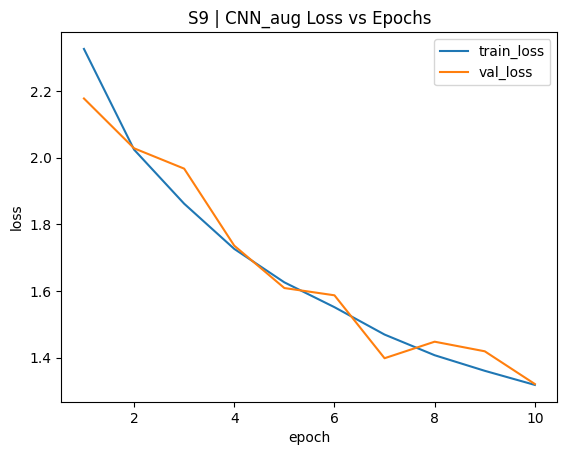

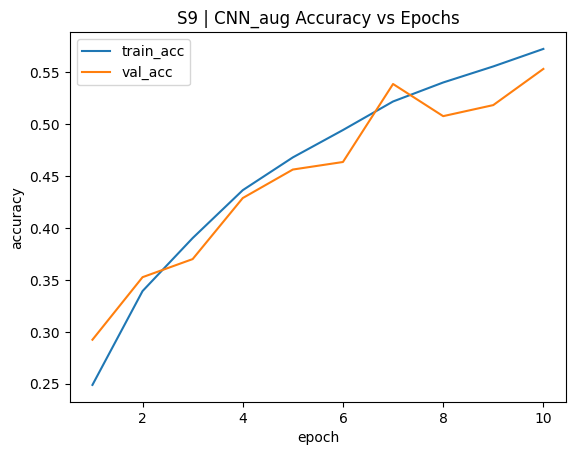


--- BiLSTM_aug ---
Params total=545,041 | trainable=545,041 | size≈2.08 MB
Epoch 1/10 | time=13.27s | tr_loss=2.5035 tr_acc=0.1844 | va_loss=2.2814 va_acc=0.2431
Epoch 2/10 | time=13.32s | tr_loss=2.2084 tr_acc=0.2716 | va_loss=2.0681 va_acc=0.3163
Epoch 3/10 | time=13.23s | tr_loss=2.0158 tr_acc=0.3292 | va_loss=1.8499 va_acc=0.3811
Epoch 4/10 | time=13.21s | tr_loss=1.8428 tr_acc=0.3890 | va_loss=1.6903 va_acc=0.4364
Epoch 5/10 | time=13.49s | tr_loss=1.6818 tr_acc=0.4395 | va_loss=1.5396 va_acc=0.4812
Epoch 6/10 | time=13.27s | tr_loss=1.5500 tr_acc=0.4860 | va_loss=1.3758 va_acc=0.5341
Epoch 7/10 | time=13.30s | tr_loss=1.4152 tr_acc=0.5309 | va_loss=1.2679 va_acc=0.5685
Epoch 8/10 | time=13.43s | tr_loss=1.3202 tr_acc=0.5625 | va_loss=1.1755 va_acc=0.5995
Epoch 9/10 | time=13.45s | tr_loss=1.2151 tr_acc=0.5991 | va_loss=1.0792 va_acc=0.6342
Epoch 10/10 | time=13.46s | tr_loss=1.1087 tr_acc=0.6330 | va_loss=1.0063 va_acc=0.6567
TEST: acc=0.2959, precision=0.2616, recall=0.3380, f1

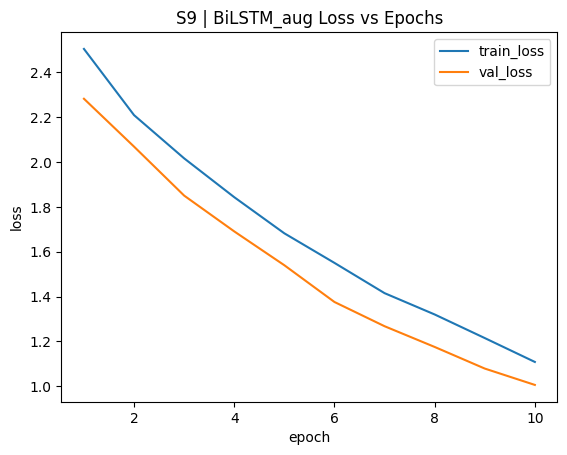

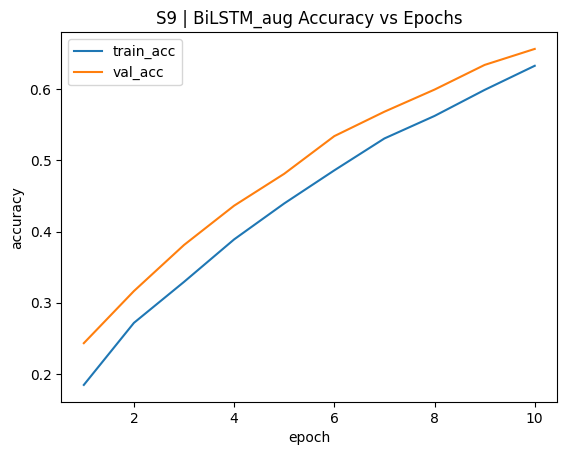


--- Transformer_aug ---
Params total=797,201 | trainable=797,201 | size≈3.04 MB
Epoch 1/10 | time=25.12s | tr_loss=2.1862 tr_acc=0.2859 | va_loss=1.7875 va_acc=0.4032
Epoch 2/10 | time=24.81s | tr_loss=1.6904 tr_acc=0.4371 | va_loss=1.3940 va_acc=0.5257
Epoch 3/10 | time=24.77s | tr_loss=1.4229 tr_acc=0.5243 | va_loss=1.1656 va_acc=0.6007
Epoch 4/10 | time=24.63s | tr_loss=1.2474 tr_acc=0.5818 | va_loss=1.0333 va_acc=0.6456
Epoch 5/10 | time=24.78s | tr_loss=1.1053 tr_acc=0.6288 | va_loss=0.9073 va_acc=0.6843
Epoch 6/10 | time=24.89s | tr_loss=1.0022 tr_acc=0.6661 | va_loss=0.8148 va_acc=0.7087
Epoch 7/10 | time=25.07s | tr_loss=0.9279 tr_acc=0.6899 | va_loss=0.7849 va_acc=0.7284
Epoch 8/10 | time=25.00s | tr_loss=0.8779 tr_acc=0.7085 | va_loss=0.7244 va_acc=0.7520


In [ ]:
all_folds_results_aug = []

for test_subj in subjects:
    print("\n" + "="*80)
    print("LOSO TEST SUBJECT (AUG):", test_subj)

    tr_loader, va_loader, te_loader, L, C = make_fold_loaders(test_subj)
    fold_out = {"test_subject": test_subj, "models": {}}

    # CNN
    res = train_one_model("CNN_aug", CNN1D(C, n_classes), tr_loader, va_loader, te_loader, augment=True)
    fold_out["models"]["CNN_aug"] = res
    plot_history(res["history"], title_prefix=f"{test_subj} | CNN_aug")

    # BiLSTM
    res = train_one_model("BiLSTM_aug", BiLSTM(C, n_classes), tr_loader, va_loader, te_loader, augment=True)
    fold_out["models"]["BiLSTM_aug"] = res
    plot_history(res["history"], title_prefix=f"{test_subj} | BiLSTM_aug")

    # Transformer
    res = train_one_model("Transformer_aug", TransformerClassifier(C, n_classes, cfg.d_model, cfg.n_heads, cfg.n_layers, cfg.dropout),
                          tr_loader, va_loader, te_loader, augment=True)
    fold_out["models"]["Transformer_aug"] = res
    plot_history(res["history"], title_prefix=f"{test_subj} | Transformer_aug")

    all_folds_results_aug.append(fold_out)

print("\nDONE LOSO (augmentation).")
